In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
from numpy import mean
import os
import csv
from multiprocessing import cpu_count
import itertools
from joblib import Parallel
from joblib import delayed
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from pandas import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, minmax_scale, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import accuracy_score
from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

print(os.listdir("../input"))

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


sns.set(style='ticks', context='poster')

['BITS AIC 2019 - Reflexis Raw Dataset.csv', 'Store Attributes - Store Attributes.csv']


In [2]:
df = pd.read_csv('../input/BITS AIC 2019 - Reflexis Raw Dataset.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index(['DATE']).dropna()
#df['SALES_ACTUAL'].plot()
df = df[df.index.get_level_values('DATE') != '2016-01-31']
df.head()

,STORE,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,SALES_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-02-01,203,49,22,424.50000,28.50000,29.75000
2016-02-02,203,85,20,878.20000,31.50000,25.50000
2016-02-03,203,84,25,937.80000,25.50000,27.50000
2016-02-04,203,69,13,572.70000,25.75000,27.25000
2016-02-05,203,53,8,384.50000,30.25000,31.50000


In [3]:
#setting seasons
df2 = df.groupby('STORE')['SALES_ACTUAL'].resample('M').sum().reset_index()
#df2 = df2.merge(df1.groupby('STORE')['TRAFFIC_ACTUAL'].resample('W').sum().reset_index(level=0))
#df2
df2 = df2.merge(df.groupby('STORE')['TRAFFIC_ACTUAL'].resample('M').sum().reset_index())
df2 = df2.merge(df.groupby('STORE')['TRANSACTIONS_ACTUAL'].resample('M').sum().reset_index())
#df2 = df2.merge(df.groupby('STORE')['MANAGER_SCHED_HOURS'].resample('W').mean().reset_index())
df2 = df2.merge(df.groupby('STORE')['MANAGER_SCHED_HOURS'].resample('W').mean().reset_index(level=0).groupby('STORE')['MANAGER_SCHED_HOURS'].resample('M').sum().reset_index())
df2 = df2.merge(df.groupby('STORE')['SYSTEM_SCHED_HOURS'].resample('W').mean().reset_index(level=0).groupby('STORE')['SYSTEM_SCHED_HOURS'].resample('M').sum().reset_index())
df2 = df2.set_index('DATE')
df2

,STORE,SALES_ACTUAL,TRAFFIC_ACTUAL,TRANSACTIONS_ACTUAL,MANAGER_SCHED_HOURS,SYSTEM_SCHED_HOURS
DATE,,,,,,
2016-02-29,203,38611.57000,3941,838,107.17857,111.10714
2016-03-31,203,39554.02000,3930,916,103.39286,120.00000
2016-04-30,203,40685.19000,3538,745,101.28571,107.89286
2016-05-31,203,49408.10000,3878,883,126.07143,132.28571
2016-06-30,203,46539.06000,3362,1058,101.35714,110.42857
2016-07-31,203,51576.10000,5074,1031,127.67857,133.82143
2016-08-31,203,69314.35000,6724,1400,104.50000,107.03571
2016-09-30,203,35112.64000,4191,913,91.50000,82.42857
2016-10-31,203,23176.92000,3540,554,108.89286,102.17857


In [4]:
def train_test_split_bydate(data, split_date):
    return data[data.index < split_date], data[data.index >= split_date]

In [5]:
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

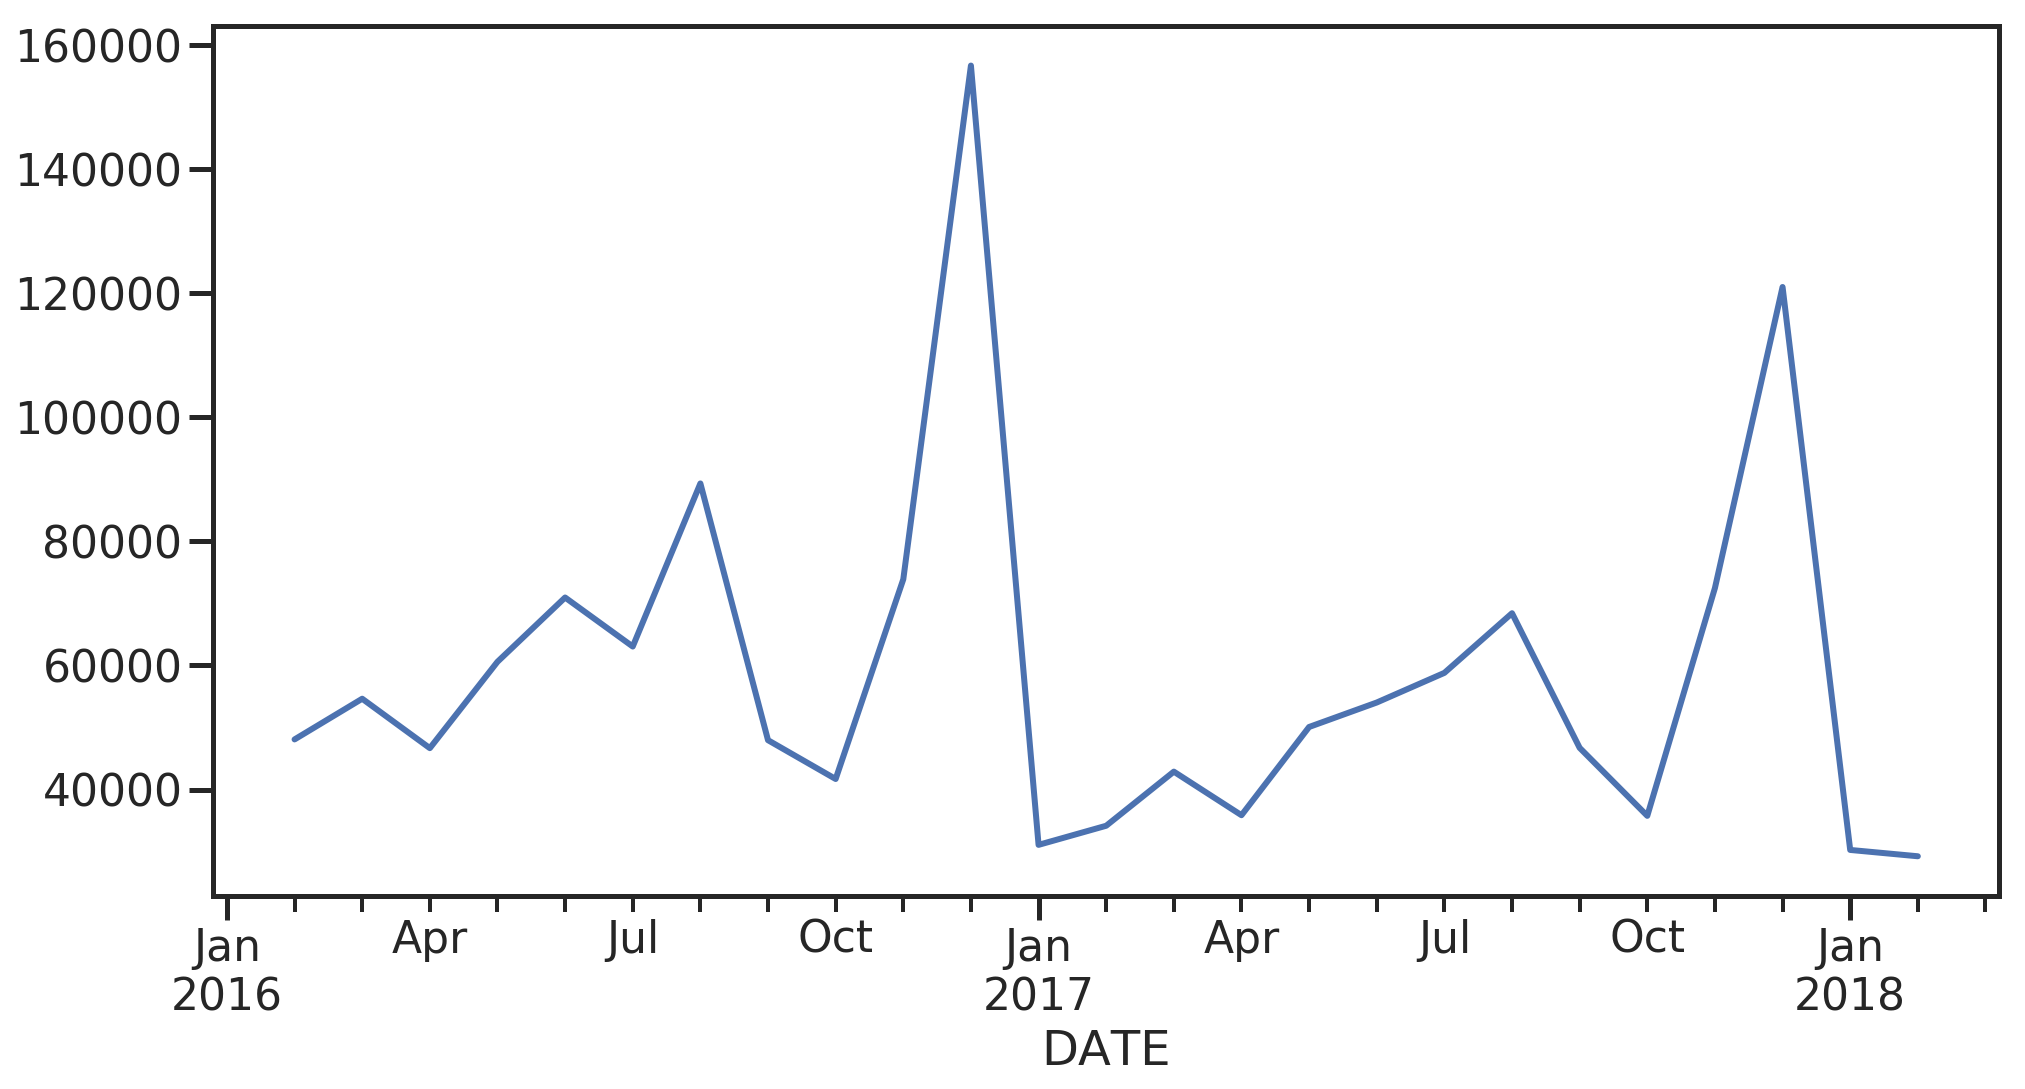

In [6]:
df_req = df2[df2['STORE']==210]
df_req['SALES_ACTUAL'].plot(figsize=(16,8))

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


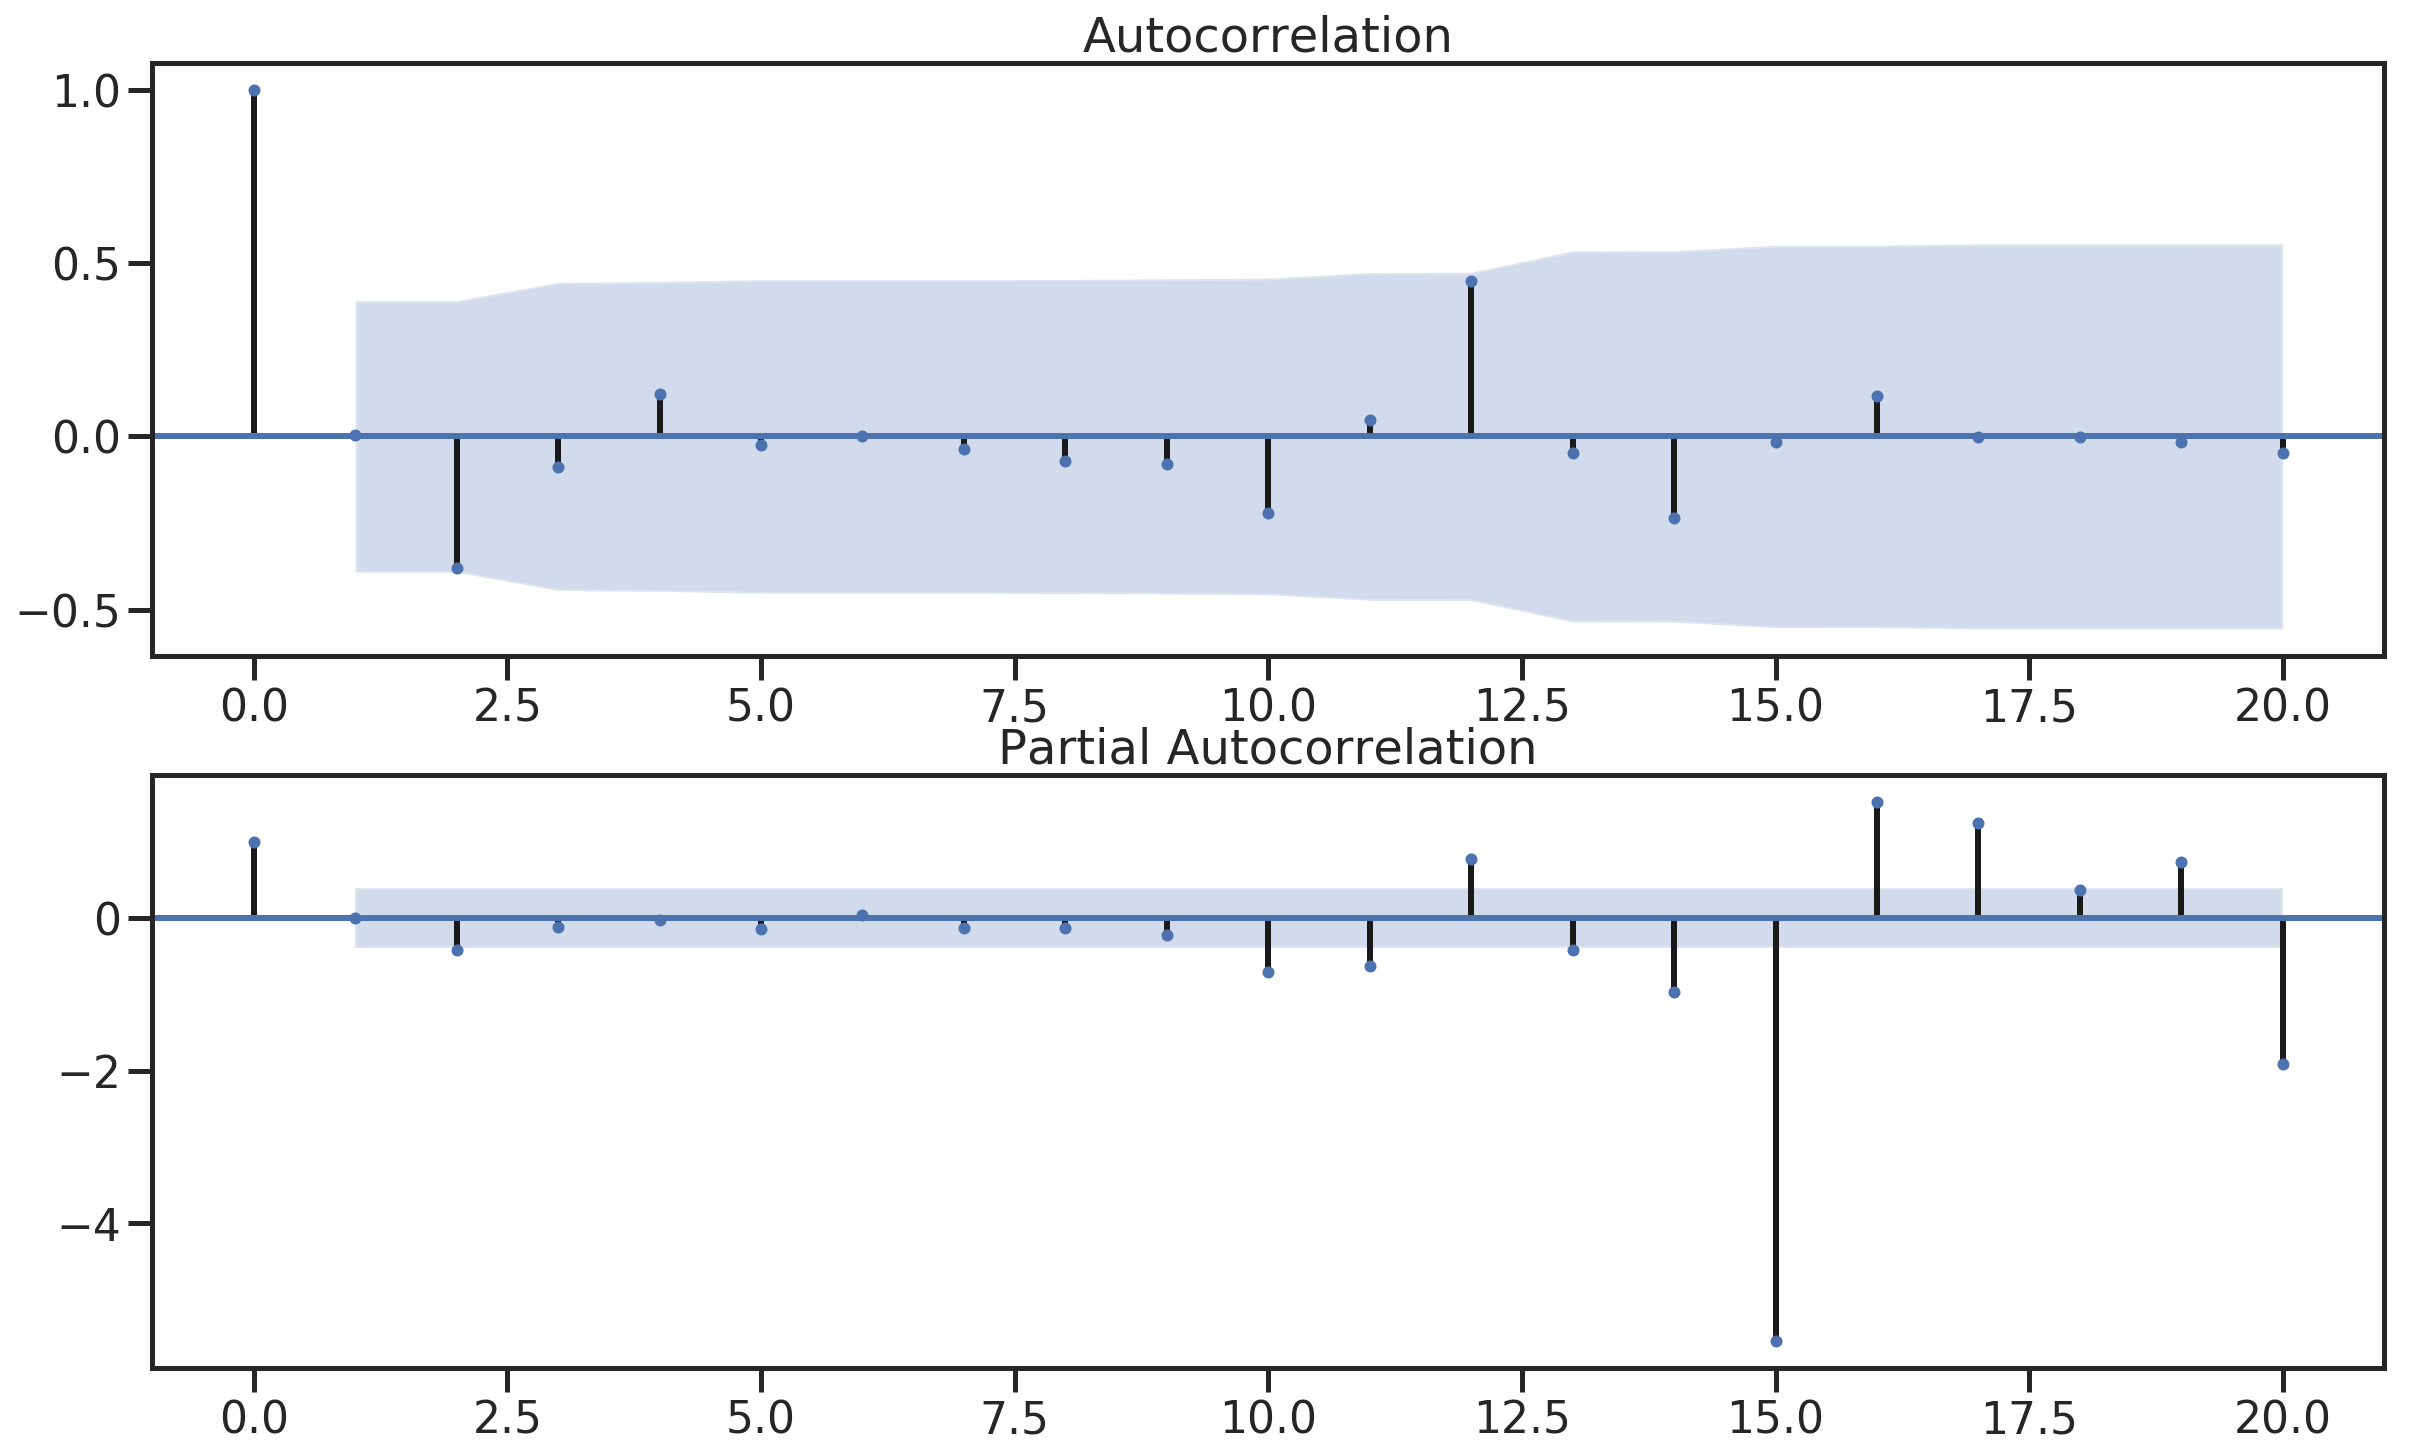

In [7]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_req['SALES_ACTUAL'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_req['SALES_ACTUAL'], lags=20, ax=ax2)
plt.show()

In [8]:
def SARIMAX_call(data, split_date):
    ns_ar = [0,1,2]
    ns_diff = [0,1,2]
    ns_ma = [0,1,2]
    s_ar = [0,1,2]
    s_diff = [0,1,2] 
    s_ma = [0,1,2]
    s_list = np.arange(13).tolist()
    #Splitting into training and testing
    training_ts, testing_ts = train_test_split_bydate(data, split_date)    
    error_table = pd.DataFrame(columns = ['p','d','q','P','D','Q','s','AIC','BIC','RMSE'], index = range(len(ns_ar)*len(ns_diff)*len(ns_ma)*len(s_ar)*len(s_diff)*len(s_ma)*len(s_list)))
    count = 0    
    for p in ns_ar:
        for d in ns_diff:
            for q in ns_ma:
                for P in s_ar:
                    for D in s_diff:
                        for Q in s_ma:
                            for s in s_list:
                                try:
                                #fitting the model
                                    SARIMAX_model = SARIMAX(training_ts.astype(float), order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_invertibility=False)
                                    SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
                                    AIC = np.round(SARIMAX_model_fit.aic,2)
                                    BIC = np.round(SARIMAX_model_fit.bic,2)
                                    predictions = SARIMAX_model_fit.forecast(steps=len(testing_ts),typ='levels')
                                    RMSE = measure_rmse(testing_ts.values,predictions.values)
                                    error_table['p'][count] = p
                                    error_table['d'][count] = d
                                    error_table['q'][count] = q
                                    error_table['P'][count] = P
                                    error_table['D'][count] = D
                                    error_table['Q'][count] = Q
                                    error_table['s'][count] = s
                                    error_table['AIC'][count] = AIC
                                    error_table['BIC'][count] = BIC
                                    error_table['RMSE'][count] = RMSE
                                    print(error_table[error_table.index==count])
                                except:
                                    print('error')
                                #populating error table

                                count+=1 #incrementing count        
        
    #returning the fitted model and values
    return error_table

In [9]:
error_table = SARIMAX_call(df_req['SALES_ACTUAL'], '2018-01-01')


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


   p  d  q  P  D  Q  s       AIC       BIC        RMSE
0  0  0  0  0  0  0  0 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
1  0  0  0  0  0  0  1 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
2  0  0  0  0  0  0  2 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
3  0  0  0  0  0  0  3 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
4  0  0  0  0  0  0  4 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
5  0  0  0  0  0  0  5 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
6  0  0  0  0  0  0  6 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
7  0  0  0  0  0  0  7 578.69000 579.82000 29763.06767
   p  d  q  P  D  Q  s       AIC       BIC        RMSE
8  0  0  0  0  0  0  8 578.69000 579.82000 29763.06767
   p  d  q

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

    p  d  q  P  D  Q  s       AIC       BIC        RMSE
13  0  0  0  0  0  1  0 570.99000 573.26000 26207.11162
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
14  0  0  0  0  0  1  1 570.99000 573.26000 26207.11162
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
15  0  0  0  0  0  1  2 574.54000 576.81000 15850.05705
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
16  0  0  0  0  0  1  3 574.53000 576.80000 17310.19349
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
17  0  0  0  0  0  1  4 570.37000 572.64000 18991.41567
    p  d  q  P  D  Q  s       AIC       BIC       RMSE
18  0  0  0  0  0  1  5 572.86000 575.14000 5284.35327
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
19  0  0  0  0  0  1  6 977.39000 979.66000 29763.06767


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

    p  d  q  P  D  Q  s        AIC        BIC        RMSE
20  0  0  0  0  0  1  7 1105.73000 1108.00000 29763.06767
error
error
error
error
error
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
26  0  0  0  0  0  2  0 570.93000 574.34000 33536.74914
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
27  0  0  0  0  0  2  1 570.93000 574.34000 33536.74914
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
28  0  0  0  0  0  2  2 571.38000 574.79000 18085.68629


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

    p  d  q  P  D  Q  s        AIC        BIC        RMSE
29  0  0  0  0  0  2  3 1114.92000 1118.32000 67968.13008
error
error
error
error
error
error
error
error
error
error
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
40  0  0  0  0  1  0  1 528.14000 529.24000 91229.03158
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
41  0  0  0  0  1  0  2 512.47000 513.52000 71403.64909
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
42  0  0  0  0  1  0  3 485.50000 486.49000 30809.86695
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
43  0  0  0  0  1  0  4 458.29000 459.23000 12510.98716
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
44  0  0  0  0  1  0  5 437.74000 438.63000 29666.57182
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
45  0  0  0  0  1  0  6 413.86000 414.70000 34263.56703
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
46  0  0  0  0  1  0  7 391.69000 392.47000 26812.07003
    p  d  q  P  D  Q  s       AIC       

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

    p  d  q  P  D  Q   s       AIC       BIC        RMSE
49  0  0  0  0  1  0  10 325.19000 325.75000 10074.66802
    p  d  q  P  D  Q   s       AIC       BIC        RMSE
50  0  0  0  0  1  0  11 291.23000 291.71000 10029.21639
    p  d  q  P  D  Q   s       AIC       BIC       RMSE
51  0  0  0  0  1  0  12 245.54000 245.94000 3525.54562
error
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
53  0  0  0  0  1  1  1 524.75000 526.93000 31615.80179
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
54  0  0  0  0  1  1  2 504.71000 506.80000 31420.20161
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
55  0  0  0  0  1  1  3 481.11000 483.10000 21353.92144


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


    p  d  q  P  D  Q  s       AIC       BIC        RMSE
56  0  0  0  0  1  1  4 457.58000 459.47000 13584.08480


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

    p  d  q  P  D  Q  s       AIC       BIC        RMSE
57  0  0  0  0  1  1  5 579.79000 581.58000 29666.57182
error
error
error
error
error
error
error
error
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
66  0  0  0  0  1  2  1 525.82000 529.09000 40570.50374
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
67  0  0  0  0  1  2  2 505.17000 508.31000 23008.63384
error
error
error
error
error
error
error
error
error
error
error
    p  d  q  P  D  Q  s       AIC       BIC         RMSE
79  0  0  0  0  2  0  1 523.99000 525.03000 165856.28898


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

    p  d  q  P  D  Q  s       AIC       BIC         RMSE
80  0  0  0  0  2  0  2 486.76000 487.70000 134041.15281
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
81  0  0  0  0  2  0  3 433.75000 434.58000 35663.72549
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
82  0  0  0  0  2  0  4 380.34000 381.05000 12437.65880
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
83  0  0  0  0  2  0  5 334.20000 334.77000 49275.80878
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
84  0  0  0  0  2  0  6 288.02000 288.42000 65394.41326
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
85  0  0  0  0  2  0  7 231.81000 232.00000 48379.95029
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
86  0  0  0  0  2  0  8 187.61000 187.56000 30477.80812
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
87  0  0  0  0  2  0  9 135.42000 135.03000 20060.51867
    p  d  q  P  D  Q   s      AIC      BIC        RMSE
88  0  0  0  0  2  0  10 87.05000 86.15000 2044

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

    p  d  q  P  D  Q   s     AIC  BIC        RMSE
90  0  0  0  0  2  0  12 2.00000  NaN 13202.46574
error
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
92  0  0  0  0  2  1  1 510.36000 512.45000 99358.58977
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
93  0  0  0  0  2  1  2 471.81000 473.70000 79510.13363
    p  d  q  P  D  Q  s       AIC       BIC        RMSE
94  0  0  0  0  2  1  3 421.41000 423.07000 36860.24151


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

    p  d  q  P  D  Q  s       AIC       BIC        RMSE
95  0  0  0  0  2  1  4 656.43000 657.85000 12437.65880
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
105  0  0  0  0  2  2  1 509.92000 513.06000 71851.15048
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
106  0  0  0  0  2  2  2 469.25000 472.08000 48488.82291
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
117  0  0  0  1  0  0  0 554.14000 556.41000 67986.04241


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
118  0  0  0  1  0  0  1 554.14000 556.41000 67986.04241
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
119  0  0  0  1  0  0  2 562.61000 564.88000 49697.27839
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
120  0  0  0  1  0  0  3 560.56000 562.83000 20176.81383
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
121  0  0  0  1  0  0  4 558.38000 560.65000 5721.51811
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
122  0  0  0  1  0  0  5 562.52000 564.79000 17511.21359
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
123  0  0  0  1  0  0  6 563.39000 565.66000 20515.30009
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
124  0  0  0  1  0  0  7 566.01000 568.29000 13658.76346
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
125  0  0  0  1  0  0  8 568.01000 570.29000 8481.46994
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
126  0  0  0  1  0  0  9 569.31000 5

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q   s       AIC       BIC       RMSE
127  0  0  0  1  0  0  10 572.35000 574.62000 5229.47618
     p  d  q  P  D  Q   s       AIC       BIC       RMSE
128  0  0  0  1  0  0  11 568.56000 570.83000 5584.98220
     p  d  q  P  D  Q   s       AIC       BIC       RMSE
129  0  0  0  1  0  0  12 547.70000 549.97000 2825.49660
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
130  0  0  0  1  0  1  0 550.86000 554.26000 31277.50355
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
131  0  0  0  1  0  1  1 550.86000 554.26000 31277.50355


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
132  0  0  0  1  0  1  2 553.79000 557.19000 30455.98148
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
133  0  0  0  1  0  1  3 555.77000 559.18000 22652.64102
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
134  0  0  0  1  0  1  4 552.72000 556.13000 15919.30610


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
135  0  0  0  1  0  1  5 561.84000 565.25000 21738.17710
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
143  0  0  0  1  0  2  0 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
144  0  0  0  1  0  2  1 551.66000 556.20000 37692.21419
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
145  0  0  0  1  0  2  2 552.48000 557.02000 19685.70814
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
157  0  0  0  1  1  0  1 528.74000 530.93000 80726.98550


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
158  0  0  0  1  1  0  2 505.42000 507.51000 33907.56927
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
159  0  0  0  1  1  0  3 483.65000 485.64000 31201.52877
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
160  0  0  0  1  1  0  4 459.23000 461.12000 13832.39801
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
161  0  0  0  1  1  0  5 438.79000 440.57000 26305.12958
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
162  0  0  0  1  1  0  6 488.79000 490.46000 23564.34476
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
163  0  0  0  1  1  0  7 392.86000 394.40000 48129.14070


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
164  0  0  0  1  1  0  8 365.73000 367.14000 19282.16077
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
170  0  0  0  1  1  1  1 525.81000 529.09000 38192.99504
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
171  0  0  0  1  1  1  2 505.16000 508.29000 21024.96948
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
172  0  0  0  1  1  1  3 483.11000 486.10000 21635.42576


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
173  0  0  0  1  1  1  4 459.45000 462.29000 13261.88232


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
174  0  0  0  1  1  1  5 904.01000 906.68000 37996.85056
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
183  0  0  0  1  1  2  1 527.70000 532.07000 37640.46543
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
184  0  0  0  1  1  2  2 506.59000 510.77000 18268.35357
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC         RMSE
196  0  0  0  1  2  0  1 519.92000 522.01000 158427.45908
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
197  0  0  0  1  2  0  2 474.24000 476.13000 68010.14971
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
198  0  0  0  1  2  0  3 424.93000 426.59000 41523.60517
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
199  0  0  0  1  2  0  4 377.50000 378.92000 16565.41598
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
200  0  0  0  1  2  0  5 329.40000 330.53000 36089.56683
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
201  0  0  0  1  2  0  6 280.31000 281.10000 8987.97926
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
209  0  0  0  1  2  1  1 511.50000 514.63000 90369.27914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
210  0  0  0  1  2  1  2 465.91000 468.74000 45761.40048
     p  d  q  P  D  Q  s       AIC       BIC  

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
212  0  0  0  1  2  1  4 378.50000 380.63000 16308.74379
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
222  0  0  0  1  2  2  1 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
223  0  0  0  1  2  2  2 469.65000 473.43000 39650.40926
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
234  0  0  0  2  0  0  0 555.15000 558.56000 65398.94747
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
235  0  0  0  2  0  0  1 555.15000 558.56000 65398.94747
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
236  0  0  0  2  0  0  2 556.16000 559.57000 25270.21799
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
237  0  0  0  2  0  0  3 558.36000 561.76000 24488.46664
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
238  0  0  0  2  0  0  4 559.33000 562.74000 8553.54796
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
239  0  0  0  2  0  0  5 564.35000 567.76000 14770.82515


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC       RMSE
240  0  0  0  2  0  0  6 542.32000 545.73000 5083.60043
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
241  0  0  0  2  0  0  7 563.54000 566.94000 69105.14023
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
249  0  0  0  2  0  1  2 553.54000 558.08000 18602.79644
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
250  0  0  0  2  0  1  3 557.31000 561.85000 22372.16261


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
251  0  0  0  2  0  1  4 555.42000 559.96000 15537.14103
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
252  0  0  0  2  0  1  5 563.56000 568.10000 22215.90909
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
260  0  0  0  2  0  2  0 553.45000 559.13000 34636.24924
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
261  0  0  0  2  0  2  1 553.45000 559.13000 34636.24924
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
262  0  0  0  2  0  2  2 554.04000 559.72000 20502.22369
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
274  0  0  0  2  1  0  1 527.43000 530.70000 55383.13007
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
275  0  0  0  2  1  0  2 505.59000 508.72000 28547.21398
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
276  0  0  0  2  1  0  3 485.34000 488.33000 28954.25929


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC       RMSE
277  0  0  0  2  1  0  4 531.66000 534.49000 7688.44948
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
287  0  0  0  2  1  1  1 526.68000 531.04000 28937.56720
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
288  0  0  0  2  1  1  2 507.60000 511.78000 27585.33060


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
289  0  0  0  2  1  1  3 485.06000 489.04000 21043.47718
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
290  0  0  0  2  1  1  4 460.59000 464.36000 8720.25226


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
291  0  0  0  2  1  1  5 440.66000 444.22000 26998.67077
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
300  0  0  0  2  1  2  1 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
301  0  0  0  2  1  2  2 508.50000 513.72000 16125.71017
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC         RMSE
313  0  0  0  2  2  0  1 516.89000 520.02000 127396.99533
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
314  0  0  0  2  2  0  2 468.44000 471.27000 50682.08033
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
315  0  0  0  2  2  0  3 424.75000 427.25000 44405.13940


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
316  0  0  0  2  2  0  4 384.55000 386.67000 30971.14954
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
317  0  0  0  2  2  0  5 344.92000 346.62000 24170.79179
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
326  0  0  0  2  2  1  1 511.54000 515.72000 65521.47206
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
327  0  0  0  2  2  1  2 467.02000 470.80000 43272.54733


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
328  0  0  0  2  2  1  3 423.41000 426.74000 37125.20018
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
329  0  0  0  2  2  1  4 391.80000 394.64000 21406.51545
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
339  0  0  0  2  2  2  1 511.70000 516.93000 71467.88172
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
351  0  0  1  0  0  0  0 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
352  0  0  1  0  0  0  1 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
353  0  0  1  0  0  0  2 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
354  0  0  1  0  0  0  3 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
355  0  0  1  0  0  0  4 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
356  0  0  1  0  0  0  5 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
357  0  0  1  0  0  0  6 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
359  0  0  1  0  0  0  8 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
360  0  0  1  0  0  0  9 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
361  0  0  1  0  0  0  10 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
362  0  0  1  0  0  0  11 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
363  0  0  1  0  0  0  12 570.99000 573.26000 26207.11162
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
364  0  0  1  0  0  1  0 571.56000 574.97000 28427.92830
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
365  0  0  1  0  0  1  1 571.56000 574.97000 28427.92830
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
366  0  0  1  0  0  1  2 570.23000 573.64000 35377.67472
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
367  0  0  1  0  0  1  3 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
369  0  0  1  0  0  1  5 571.50000 574.91000 24381.60085
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
370  0  0  1  0  0  1  6 2105.74000 2109.15000 29762.37101
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
371  0  0  1  0  0  1  7 2218.13000 2221.53000 29762.37015
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
377  0  0  1  0  0  2  0 572.03000 576.57000 40179.18476
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
378  0  0  1  0  0  2  1 572.03000 576.57000 40179.18476
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
379  0  0  1  0  0  2  2 570.97000 575.51000 31445.04318
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
380  0  0  1  0  0  2  3 2145.10000 2149.64000 67966.38426
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
391  0  0  1  0  1  0  1 524.75000 526.93000 31615.80179
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
392  0  0  1  0  1  0  2 510.28000 512.37000 86322.87947
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
393  0  0  1  0  1  0  3 487.21000 489.20000 33157.90593
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
394  0  0  1  0  1  0  4 459.47000 461.36000 20536.92338
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
395  0  0  1  0  1  0  5 439.46000 441.24000 31074.45722
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
396  0  0  1  0  1  0  6 414.57000 416.24000 42820.26010


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
397  0  0  1  0  1  0  7 392.41000 393.96000 30344.94765
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
398  0  0  1  0  1  0  8 369.93000 371.35000 30802.38812
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
399  0  0  1  0  1  0  9 345.82000 347.09000 22247.20302
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
400  0  0  1  0  1  0  10 323.71000 324.84000 24374.53091
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
401  0  0  1  0  1  0  11 292.49000 293.46000 12169.99018
     p  d  q  P  D  Q   s       AIC       BIC       RMSE
402  0  0  1  0  1  0  12 246.61000 247.41000 9014.40535
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
404  0  0  1  0  1  1  1 528.55000 531.82000 46994.43940
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
405  0  0  1  0  1  1  2 509.15000 512.28000 45923.53738
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
406  0  0  1  0  1  1  3 484.25000 487.24000 30785.15934
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
407  0  0  1  0  1  1  4 458.15000 460.98000 22573.91213


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
408  0  0  1  0  1  1  5 717.10000 719.78000 29057.13954
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
417  0  0  1  0  1  2  1 527.77000 532.13000 32971.00528
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
418  0  0  1  0  1  2  2 510.96000 515.14000 40212.81713


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

     p  d  q  P  D  Q  s        AIC        BIC        RMSE
419  0  0  1  0  1  2  3 1105.27000 1109.25000 39842.01726
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
430  0  0  1  0  2  0  1 510.36000 512.45000 99358.58977
     p  d  q  P  D  Q  s       AIC       BIC         RMSE
431  0  0  1  0  2  0  2 483.44000 485.33000 154147.85429
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
432  0  0  1  0  2  0  3 435.04000 436.71000 33769.06416
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
433  0  0  1  0  2  0  4 380.79000 382.20000 14951.65834


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
434  0  0  1  0  2  0  5 333.50000 334.63000 45511.09742
     p  d  q  P  D  Q  s       AIC       BIC         RMSE
435  0  0  1  0  2  0  6 285.53000 286.33000 103050.21768
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
436  0  0  1  0  2  0  7 234.47000 234.87000 48733.37882
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
437  0  0  1  0  2  0  8 184.63000 184.52000 44600.96074
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
438  0  0  1  0  2  0  9 135.97000 135.19000 37509.01655
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
443  0  0  1  0  2  1  1 510.22000 513.36000 64597.53284


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

     p  d  q  P  D  Q  s       AIC       BIC         RMSE
444  0  0  1  0  2  1  2 481.48000 484.32000 101320.33307
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
445  0  0  1  0  2  1  3 430.31000 432.81000 37953.94035
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
446  0  0  1  0  2  1  4 1362.55000 1364.68000 13613.16834
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
456  0  0  1  0  2  2  1 511.77000 515.95000 66683.85392


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
457  0  0  1  0  2  2  2 482.21000 485.99000 70907.25289
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
468  0  0  1  1  0  0  0 566.89000 570.29000 33080.89890
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
469  0  0  1  1  0  0  1 566.89000 570.29000 33080.89890
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
470  0  0  1  1  0  0  2 568.06000 571.46000 58254.81184
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
471  0  0  1  1  0  0  3 569.79000 573.19000 16034.78919


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
472  0  0  1  1  0  0  4 568.91000 572.31000 22590.17240
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
473  0  0  1  1  0  0  5 570.59000 574.00000 24863.91573
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
474  0  0  1  1  0  0  6 570.17000 573.58000 25431.86407
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
475  0  0  1  1  0  0  7 571.17000 574.58000 21485.42373
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
476  0  0  1  1  0  0  8 571.26000 574.67000 23350.63163
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
477  0  0  1  1  0  0  9 571.51000 574.91000 21433.85697
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
478  0  0  1  1  0  0  10 571.80000 575.20000 21370.96598


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q   s       AIC       BIC        RMSE
479  0  0  1  1  0  0  11 572.07000 575.48000 28500.31317
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
480  0  0  1  1  0  0  12 570.60000 574.01000 10961.99885
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
481  0  0  1  1  0  1  0 568.67000 573.21000 38800.06664
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
482  0  0  1  1  0  1  1 568.67000 573.21000 38800.06664


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
483  0  0  1  1  0  1  2 571.24000 575.78000 31400.13302
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
484  0  0  1  1  0  1  3 570.32000 574.86000 22750.35005
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
485  0  0  1  1  0  1  4 570.43000 574.97000 19838.26567
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
486  0  0  1  1  0  1  5 572.15000 576.69000 25026.64934
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
494  0  0  1  1  0  2  0 570.63000 576.31000 33945.15074
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
495  0  0  1  1  0  2  1 570.63000 576.31000 33945.15074
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
496  0  0  1  1  0  2  2 571.30000 576.98000 39016.14547
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
508  0  0  1  1  1  0  1 526.33000 529.60000 39196.86373
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
509  0  0  1  1  1  0  2 509.68000 512.81000 47224.12700
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
510  0  0  1  1  1  0  3 485.73000 488.72000 39411.00582
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
511  0  0  1  1  1  0  4 460.41000 463.25000 25978.67550
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
512  0  0  1  1  1  0  5 440.47000 443.14000 34087.68634


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
513  0  0  1  1  1  0  6 413.14000 415.64000 21611.22506
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
514  0  0  1  1  1  0  7 391.17000 393.49000 66268.26112
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
515  0  0  1  1  1  0  8 370.15000 372.27000 25505.95516
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
521  0  0  1  1  1  1  1 527.90000 532.27000 37936.75764
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
522  0  0  1  1  1  1  2 510.82000 515.00000 36680.22560
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
523  0  0  1  1  1  1  3 486.11000 490.09000 31583.91765
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
524  0  0  1  1  1  1  4 460.08000 463.85000 22308.02645


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
525  0  0  1  1  1  1  5 741.11000 744.68000 20683.28364
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
534  0  0  1  1  1  2  1 529.71000 535.17000 32663.82312
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
535  0  0  1  1  1  2  2 512.80000 518.02000 35917.56499
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
547  0  0  1  1  2  0  1 511.60000 514.74000 90432.19471
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
548  0  0  1  1  2  0  2 481.62000 484.45000 94060.58611
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
549  0  0  1  1  2  0  3 430.90000 433.40000 45822.80439


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
550  0  0  1  1  2  0  4 380.27000 382.39000 37202.57621
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
551  0  0  1  1  2  0  5 332.27000 333.96000 42964.93490
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
552  0  0  1  1  2  0  6 283.24000 284.44000 13823.98239
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
560  0  0  1  1  2  1  1 512.02000 516.20000 66524.30834
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
561  0  0  1  1  2  1  2 482.11000 485.88000 56804.99561
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
562  0  0  1  1  2  1  3 431.09000 434.43000 46826.32852


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
563  0  0  1  1  2  1  4 379.71000 382.54000 31633.14133
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
573  0  0  1  1  2  2  1 513.65000 518.88000 64738.57017
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
574  0  0  1  1  2  2  2 483.80000 488.52000 53487.04989
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
585  0  0  1  2  0  0  0 568.75000 573.29000 38595.64179
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
586  0  0  1  2  0  0  1 568.75000 573.29000 38595.64179
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
587  0  0  1  2  0  0  2 569.41000 573.95000 43446.71184
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
588  0  0  1  2  0  0  3 570.82000 575.36000 23643.71609
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
589  0  0  1  2  0  0  4 570.78000 575.32000 22798.72245


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
590  0  0  1  2  0  0  5 572.28000 576.82000 24239.10181
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
591  0  0  1  2  0  0  6 571.15000 575.69000 12284.63037
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
592  0  0  1  2  0  0  7 572.88000 577.42000 28075.96159
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
600  0  0  1  2  0  1  2 571.30000 576.97000 38700.13038


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
601  0  0  1  2  0  1  3 572.30000 577.97000 23052.75900
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
602  0  0  1  2  0  1  4 572.40000 578.08000 20080.51810
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
603  0  0  1  2  0  1  5 574.14000 579.82000 25208.61103
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
611  0  0  1  2  0  2  0 572.67000 579.48000 38437.36803


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
612  0  0  1  2  0  2  1 572.67000 579.48000 38437.36803
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
613  0  0  1  2  0  2  2 573.24000 580.05000 35708.71914
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
625  0  0  1  2  1  0  1 527.54000 531.91000 30629.33352
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
626  0  0  1  2  1  0  2 510.89000 515.07000 39715.73848


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
627  0  0  1  2  1  0  3 487.31000 491.29000 37488.67962
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
628  0  0  1  2  1  0  4 459.32000 463.10000 10599.85717
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
630  0  0  1  2  1  0  6 413.67000 417.00000 33607.37811
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
638  0  0  1  2  1  1  1 529.53000 534.99000 30697.07279
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
639  0  0  1  2  1  1  2 512.74000 517.96000 35822.86655


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
640  0  0  1  2  1  1  3 488.11000 493.09000 31408.65705
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
641  0  0  1  2  1  1  4 460.70000 465.42000 12600.09700


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
642  0  0  1  2  1  1  5 443.37000 447.82000 33930.20227
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
651  0  0  1  2  1  2  1 531.53000 538.08000 30710.89667


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
652  0  0  1  2  1  2  2 514.80000 521.07000 35508.06129
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
664  0  0  1  2  2  0  1 511.70000 515.88000 65638.55263
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
665  0  0  1  2  2  0  2 482.08000 485.86000 59519.58495


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
666  0  0  1  2  2  0  3 431.92000 435.26000 54714.94488
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
667  0  0  1  2  2  0  4 378.85000 381.68000 1348.88734
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
668  0  0  1  2  2  0  5 332.75000 335.01000 30508.57621
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
677  0  0  1  2  2  1  1 512.89000 518.11000 55540.42114
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
678  0  0  1  2  2  1  2 483.61000 488.33000 52518.51876


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
679  0  0  1  2  2  1  3 433.03000 437.20000 46471.09142
     p  d  q  P  D  Q  s       AIC       BIC       RMSE
680  0  0  1  2  2  1  4 380.47000 384.01000 2618.92604
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
690  0  0  1  2  2  2  1 514.13000 520.40000 70921.95921
error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
702  0  0  2  0  0  0  0 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
703  0  0  2  0  0  0  1 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
704  0  0  2  0  0  0  2 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
705  0  0  2  0  0  0  3 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
706  0  0  2  0  0  0  4 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
707  0  0  2  0  0  0  5 570.93000 574.34000 33536.74914


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
708  0  0  2  0  0  0  6 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
709  0  0  2  0  0  0  7 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
710  0  0  2  0  0  0  8 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
711  0  0  2  0  0  0  9 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
712  0  0  2  0  0  0  10 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
713  0  0  2  0  0  0  11 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
714  0  0  2  0  0  0  12 570.93000 574.34000 33536.74914
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
715  0  0  2  0  0  1  0 572.44000 576.98000 40036.97704
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
716  0  0  2  0  0  1  1 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
718  0  0  2  0  0  1  3 571.42000 575.96000 39799.58532
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
719  0  0  2  0  0  1  4 571.76000 576.30000 23021.70827
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
720  0  0  2  0  0  1  5 572.37000 576.92000 35452.51152
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
721  0  0  2  0  0  1  6 2108.42000 2112.96000 29746.66580
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
722  0  0  2  0  0  1  7 2220.80000 2225.34000 29746.66540
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
728  0  0  2  0  0  2  0 574.41000 580.08000 39998.46423
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
729  0  0  2  0  0  2  1 574.41000 580.08000 39998.46423


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
730  0  0  2  0  0  2  2 573.33000 579.00000 34971.14879
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
731  0  0  2  0  0  2  3 2147.77000 2153.45000 67960.90420
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
742  0  0  2  0  1  0  1 525.82000 529.09000 40570.50374
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
743  0  0  2  0  1  0  2 506.37000 509.51000 45387.14405
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
744  0  0  2  0  1  0  3 488.64000 491.63000 24921.08364


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
745  0  0  2  0  1  0  4 460.09000 462.93000 14486.01779
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
746  0  0  2  0  1  0  5 440.94000 443.61000 29569.25578
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
747  0  0  2  0  1  0  6 415.68000 418.18000 34979.79900
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
748  0  0  2  0  1  0  7 394.00000 396.32000 23496.98174
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
749  0  0  2  0  1  0  8 371.17000 373.29000 22295.62468


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
750  0  0  2  0  1  0  9 348.23000 350.15000 30388.90380
     p  d  q  P  D  Q   s       AIC       BIC       RMSE
751  0  0  2  0  1  0  10 329.96000 331.65000 6496.91609
     p  d  q  P  D  Q   s       AIC       BIC       RMSE
752  0  0  2  0  1  0  11 295.07000 296.52000 7068.42824
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
753  0  0  2  0  1  0  12 258.25000 259.45000 11519.54010
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
755  0  0  2  0  1  1  1 527.57000 531.93000 32590.27299
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
756  0  0  2  0  1  1  2 507.12000 511.30000 40553.93310
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
757  0  0  2  0  1  1  3 484.02000 488.01000 39432.01950
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
758  0  0  2  0  1  1  4 460.33000 464.11000 21628.25707


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
759  0  0  2  0  1  1  5 905.06000 908.63000 41321.09213
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
768  0  0  2  0  1  2  1 529.69000 535.15000 33800.55785
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
769  0  0  2  0  1  2  2 508.58000 513.81000 39346.81159


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

     p  d  q  P  D  Q  s        AIC        BIC        RMSE
770  0  0  2  0  1  2  3 1148.22000 1153.20000 61491.77299
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
781  0  0  2  0  2  0  1 509.92000 513.06000 71851.15048
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
782  0  0  2  0  2  0  2 474.09000 476.92000 79642.22060


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
783  0  0  2  0  2  0  3 434.68000 437.18000 27791.33973
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
784  0  0  2  0  2  0  4 378.51000 380.63000 23970.26646
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
785  0  0  2  0  2  0  5 342.85000 344.55000 45297.76809
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
786  0  0  2  0  2  0  6 286.10000 287.29000 53857.55608


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
787  0  0  2  0  2  0  7 234.41000 235.01000 48857.68189
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
794  0  0  2  0  2  1  1 511.99000 516.17000 67093.53393
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
795  0  0  2  0  2  1  2 472.11000 475.89000 61539.34181


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
796  0  0  2  0  2  1  3 424.10000 427.43000 75726.48316


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
797  0  0  2  0  2  1  4 643.66000 646.49000 58490.31415
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
807  0  0  2  0  2  2  1 514.06000 519.29000 67526.56074
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
808  0  0  2  0  2  2  2 472.40000 477.13000 59506.77911
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
819  0  0  2  1  0  0  0 569.19000 573.73000 38707.84028
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
820  0  0  2  1  0  0  1 569.19000 573.73000 38707.84028
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
821  0  0  2  1  0  0  2 569.40000 573.94000 33056.91180
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
822  0  0  2  1  0  0  3 570.37000 574.91000 54090.44460
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
823  0  0  2  1  0  0  4 571.29000 575.83000 24346.12316


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
824  0  0  2  1  0  0  5 572.17000 576.72000 35447.00385
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
825  0  0  2  1  0  0  6 571.68000 576.22000 37907.00707
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
826  0  0  2  1  0  0  7 572.36000 576.90000 32948.17156
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
827  0  0  2  1  0  0  8 572.51000 577.05000 36033.93086
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
828  0  0  2  1  0  0  9 572.16000 576.70000 30969.40763
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
829  0  0  2  1  0  0  10 572.68000 577.22000 34025.87403


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q   s       AIC       BIC        RMSE
830  0  0  2  1  0  0  11 572.74000 577.28000 37608.35170
     p  d  q  P  D  Q   s       AIC       BIC        RMSE
831  0  0  2  1  0  0  12 571.71000 576.26000 15186.00364
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
832  0  0  2  1  0  1  0 571.15000 576.83000 33975.19996
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
833  0  0  2  1  0  1  1 571.15000 576.83000 33975.19996
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
834  0  0  2  1  0  1  2 571.16000 576.84000 30839.33829
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
835  0  0  2  1  0  1  3 571.97000 577.65000 42974.79236


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
836  0  0  2  1  0  1  4 572.76000 578.44000 24193.68446
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
837  0  0  2  1  0  1  5 573.92000 579.60000 36587.22989
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
845  0  0  2  1  0  2  0 573.13000 579.95000 33213.55249
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
846  0  0  2  1  0  2  1 573.13000 579.95000 33213.55249
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
847  0  0  2  1  0  2  2 573.12000 579.93000 28804.43031


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
859  0  0  2  1  1  0  1 527.71000 532.08000 37655.17577
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
860  0  0  2  1  1  0  2 506.83000 511.01000 37456.52217


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
861  0  0  2  1  1  0  3 486.30000 490.28000 68939.72120
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
862  0  0  2  1  1  0  4 462.02000 465.80000 19144.60376
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
863  0  0  2  1  1  0  5 441.81000 445.38000 30672.83971


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
864  0  0  2  1  1  0  6 413.73000 417.06000 19377.13706
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
865  0  0  2  1  1  0  7 393.59000 396.68000 63050.57700
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
866  0  0  2  1  1  0  8 369.10000 371.94000 29895.28060


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
872  0  0  2  1  1  1  1 529.51000 534.96000 32225.45787
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
873  0  0  2  1  1  1  2 508.82000 514.05000 37506.38290


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
874  0  0  2  1  1  1  3 485.91000 490.89000 37408.18547
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
875  0  0  2  1  1  1  4 462.22000 466.94000 20102.67885
     p  d  q  P  D  Q  s        AIC        BIC        RMSE
876  0  0  2  1  1  1  5 1618.58000 1623.04000 37445.36087
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
885  0  0  2  1  1  2  1 531.46000 538.01000 32063.87589
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
886  0  0  2  1  1  2  2 510.58000 516.85000 39671.10614
error
error
error
error
error
error
error
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value


error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
898  0  0  2  1  2  0  1 511.42000 515.60000 79986.32378
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
899  0  0  2  1  2  0  2 471.72000 475.49000 46729.52785


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
900  0  0  2  1  2  0  3 427.87000 431.20000 33261.09842
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
901  0  0  2  1  2  0  4 378.72000 381.55000 26530.57383
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
902  0  0  2  1  2  0  5 335.31000 337.57000 42270.94840


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
903  0  0  2  1  2  0  6 281.12000 282.71000 36918.66887
error
error
error
error
error
error
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
911  0  0  2  1  2  1  1 513.88000 519.10000 65137.03033


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
912  0  0  2  1  2  1  2 472.68000 477.41000 49402.35239
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
913  0  0  2  1  2  1  3 424.11000 428.28000 50828.38298
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
914  0  0  2  1  2  1  4 377.71000 381.25000 27686.94198
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
924  0  0  2  1  2  2  1 514.35000 520.61000 68330.96357
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
925  0  0  2  1  2  2  2 474.32000 479.99000 55687.16640
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
936  0  0  2  2  0  0  0 571.17000 576.85000 36808.37451
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
937  0  0  2  2  0  0  1 571.17000 576.85000 36808.37451
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
938  0  0  2  2  0  0  2 571.13000 576.81000 29201.68586
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
939  0  0  2  2  0  0  3 572.18000 577.85000 52238.23961


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
940  0  0  2  2  0  0  4 573.14000 578.82000 25852.49664
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
941  0  0  2  2  0  0  5 574.02000 579.69000 35386.22313
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
942  0  0  2  2  0  0  6 572.92000 578.60000 21170.69112
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
943  0  0  2  2  0  0  7 574.22000 579.90000 39154.29559
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
951  0  0  2  2  0  1  2 573.13000 579.94000 29202.09428
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
952  0  0  2  2  0  1  3 573.94000 580.75000 44971.36563
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
953  0  0  2  2  0  1  4 574.75000 581.56000 24006.73442


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
954  0  0  2  2  0  1  5 575.92000 582.73000 36696.32038
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
962  0  0  2  2  0  2  0 575.15000 583.10000 33963.06152
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
963  0  0  2  2  0  2  1 575.15000 583.10000 33963.06152
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
964  0  0  2  2  0  2  2 575.13000 583.08000 29243.93164
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
976  0  0  2  2  1  0  1 529.32000 534.78000 30335.99606
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
977  0  0  2  2  1  0  2 508.82000 514.05000 37546.84443
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
978  0  0  2  2  1  0  3 487.71000 492.69000 45435.00084


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
979  0  0  2  2  1  0  4 461.52000 466.24000 10398.43066
error
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
981  0  0  2  2  1  0  6 413.51000 417.67000 36970.87952
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

     p  d  q  P  D  Q  s       AIC       BIC        RMSE
989  0  0  2  2  1  1  1 531.32000 537.87000 30355.23793
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
990  0  0  2  2  1  1  2 510.81000 517.08000 37708.73509


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
991  0  0  2  2  1  1  3 487.87000 493.84000 36756.79789
     p  d  q  P  D  Q  s       AIC       BIC        RMSE
992  0  0  2  2  1  1  4 462.93000 468.60000 12299.54786


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


     p  d  q  P  D  Q  s       AIC       BIC        RMSE
993  0  0  2  2  1  1  5 444.43000 449.78000 32352.44045
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1002  0  0  2  2  1  2  1 532.45000 540.09000 32172.13039
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1003  0  0  2  2  1  2  2 512.80000 520.11000 36573.15137
error
error
error
error
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value


error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1015  0  0  2  2  2  0  1 512.52000 517.74000 70983.48115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1016  0  0  2  2  2  0  2 472.31000 477.04000 51234.82188
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1017  0  0  2  2  2  0  3 427.90000 432.06000 45193.54204


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1018  0  0  2  2  2  0  4 376.73000 380.27000 3981.72378


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1019  0  0  2  2  2  0  5 330.35000 333.17000 56904.47616
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1028  0  0  2  2  2  1  1 514.41000 520.68000 71105.33269
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1029  0  0  2  2  2  1  2 474.25000 479.92000 52419.31097


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1030  0  0  2  2  2  1  3 425.88000 430.88000 53919.38241
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1031  0  0  2  2  2  1  4 377.91000 382.15000 6001.46547
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1041  0  0  2  2  2  2  1 516.25000 523.56000 68025.87330
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1053  0  1  0  0  0  0  0 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1054  0  1  0  0  0  0  1 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1055  0  1  0  0  0  0  2 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1056  0  1  0  0  0  0  3 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1057  0  1  0  0  0  0  4 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1058  0  1  0  0  0  0  5 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1059  0  1  0  0  0  0  6 528.14000 529.24000 91229.03158
      

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1062  0  1  0  0  0  0  9 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1063  0  1  0  0  0  0  10 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1064  0  1  0  0  0  0  11 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1065  0  1  0  0  0  0  12 528.14000 529.24000 91229.03158
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1066  0  1  0  0  0  1  0 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1067  0  1  0  0  0  1  1 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1068  0  1  0  0  0  1  2 529.69000 531.87000 80559.46683


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1069  0  1  0  0  0  1  3 530.37000 532.55000 91236.09113
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1070  0  1  0  0  0  1  4 529.57000 531.75000 85722.85242
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1071  0  1  0  0  0  1  5 535.75000 537.94000 91299.89548


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1072  0  1  0  0  0  1  6 1176.69000 1178.88000 91229.03158
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1079  0  1  0  0  0  2  0 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1080  0  1  0  0  0  2  1 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1081  0  1  0  0  0  2  2 543.19000 546.47000 70810.31328


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
1082  0  1  0  0  0  2  3 1025.12000 1028.39000 133918.22770
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1093  0  1  0  0  1  0  1 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1094  0  1  0  0  1  0  2 499.69000 500.69000 154198.08466
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1095  0  1  0  0  1  0  3 471.82000 472.76000 100413.75857
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1096  0  1  0  0  1  0  4 444.78000 445.67000 64247.74608
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1097  0  1  0  0  1  0  5 425.59000 426.43000 90582.72739
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1098  0  1  0  0  1  0  6 398.96000 399.74000 100950.53058
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1099  0  1  0  0  1  0  7 376.84000 377.55000 97601.4363

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1102  0  1  0  0  1  0  10 307.51000 308.00000 96482.80580
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1103  0  1  0  0  1  0  11 275.64000 276.04000 98787.39700
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1104  0  1  0  0  1  0  12 222.23000 222.53000 32873.34403
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1106  0  1  0  0  1  1  1 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1107  0  1  0  0  1  1  2 488.66000 490.65000 94700.75515
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1108  0  1  0  0  1  1  3 461.14000 463.03000 82153.37218
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1109  0  1  0  0  1  1  4 438.59000 440.37000 64354.66492


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1110  0  1  0  0  1  1  5 732.88000 734.55000 90582.72739
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1119  0  1  0  0  1  2  1 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1120  0  1  0  0  1  2  2 484.81000 487.80000 69661.11755
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1132  0  1  0  0  2  0  1 522.32000 523.31000 191128.49132
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1133  0  1  0  0  2  0  2 472.82000 473.71000 246439.45864
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1134  0  1  0  0  2  0  3 418.47000 419.24000 101743.06037
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1135  0  1  0  0  2  0  4 364.59000 365.23000 24135.62883
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1136  0  1  0  0  2  0  5 319.06000 319.54000 85394.71038
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1137  0  1  0  0  2  0  6 267.10000 267.40000 234587.43049
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1138  0  1  0  0  2  0  7 217.44000 217.52000 47143.57043
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1139  0  1  0  0  2  0  8 166.54000 166.33000 168273.22762
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1140

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q   s     AIC  BIC         RMSE
1142  0  1  0  0  2  0  11 2.00000 -inf 104372.35738
      p  d  q  P  D  Q   s     AIC  BIC        RMSE
1143  0  1  0  0  2  0  12 2.00000  NaN 98841.56315
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1145  0  1  0  0  2  1  1 503.91000 505.90000 170309.12560
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1146  0  1  0  0  2  1  2 457.18000 458.96000 160548.99311
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1147  0  1  0  0  2  1  3 404.87000 406.41000 101474.52474


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1148  0  1  0  0  2  1  4 609.69000 610.97000 24135.62883
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1158  0  1  0  0  2  2  1 496.61000 499.59000 129123.43700
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1159  0  1  0  0  2  2  2 446.61000 449.28000 97874.68136
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1170  0  1  0  1  0  0  0 528.74000 530.93000 80726.98550


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1171  0  1  0  1  0  0  1 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1172  0  1  0  1  0  0  2 528.67000 530.86000 75675.36411
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1173  0  1  0  1  0  0  3 530.32000 532.50000 91237.87670
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1174  0  1  0  1  0  0  4 529.99000 532.17000 87346.11639
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1175  0  1  0  1  0  0  5 530.56000 532.74000 91335.03942
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1176  0  1  0  1  0  0  6 530.65000 532.83000 92215.57102
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1177  0  1  0  1  0  0  7 530.87000 533.05000 90836.69851


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1178  0  1  0  1  0  0  8 531.35000 533.53000 91344.85245
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1179  0  1  0  1  0  0  9 531.39000 533.57000 91242.86436
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1180  0  1  0  1  0  0  10 530.04000 532.22000 90809.73262
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1181  0  1  0  1  0  0  11 527.95000 530.13000 88974.58523


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1182  0  1  0  1  0  0  12 518.47000 520.66000 20438.11713
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1183  0  1  0  1  0  1  0 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1184  0  1  0  1  0  1  1 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1185  0  1  0  1  0  1  2 531.23000 534.50000 75197.14206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1186  0  1  0  1  0  1  3 532.26000 535.53000 87932.75085
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1187  0  1  0  1  0  1  4 531.21000 534.49000 77707.04815
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1188  0  1  0  1  0  1  5 531.65000 534.92000 89495.41624
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1196  0  1  0  1  0  2  0 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1197  0  1  0  1  0  2  1 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1198  0  1  0  1  0  2  2 545.37000 549.74000 74160.69048
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1210  0  1  0  1  1  0  1 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1211  0  1  0  1  1  0  2 490.60000 492.59000 93552.42659
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1212  0  1  0  1  1  0  3 467.02000 468.91000 100488.42043
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1213  0  1  0  1  1  0  4 443.51000 445.29000 81053.17908
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1214  0  1  0  1  1  0  

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1215  0  1  0  1  1  0  6 391.57000 393.12000 32870.66601
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1216  0  1  0  1  1  0  7 373.84000 375.26000 151874.99293
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1217  0  1  0  1  1  0  8 345.24000 346.51000 46813.78940
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1223  0  1  0  1  1  1  1 511.50000 514.63000 90369.27914


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1224  0  1  0  1  1  1  2 487.04000 490.02000 69631.32529
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1225  0  1  0  1  1  1  3 461.50000 464.34000 76563.64401
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1226  0  1  0  1  1  1  4 441.01000 443.68000 63618.27366
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1227  0  1  0  1  1  1  5 419.66000 422.16000 99690.12568
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1236  0  1  0  1  1  2  1 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1237  0  1  0  1  1  2  2 486.59000 490.57000 67686.13395
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1249  0  1  0  1  2  0  1 513.32000 515.31000 232447.33944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1250  0  1  0  1  2  0  2 460.24000 462.02000 148793.47371


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1251  0  1  0  1  2  0  3 409.67000 411.21000 106722.13766
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1252  0  1  0  1  2  0  4 359.21000 360.49000 138651.98457
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1253  0  1  0  1  2  0  5 309.21000 310.18000 88779.84745
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1254  0  1  0  1  2  0  6 251.85000 252.45000 29153.31697


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s  AIC  BIC         RMSE
1255  0  1  0  1  2  0  7  NaN  NaN 113501.74916
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1262  0  1  0  1  2  1  1 500.86000 503.84000 164882.74567
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1263  0  1  0  1  2  1  2 448.54000 451.21000 96731.23771
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1264  0  1  0  1  2  1  3 402.19000 404.51000 103386.02931


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1265  0  1  0  1  2  1  4 360.31000 362.23000 135763.92065
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1275  0  1  0  1  2  2  1 497.06000 501.04000 119777.99991
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1276  0  1  0  1  2  2  2 446.82000 450.39000 75563.45497
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1287  0  1  0  2  0  0  0 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1288  0  1  0  2  0  0  1 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1289  0  1  0  2  0  0  2 530.74000 534.02000 74771.12492
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1290  0  1  0  2  0  0  3 532.64000 535.92000 92224.57737


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1291  0  1  0  2  0  0  4 532.76000 536.04000 87124.14900
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1292  0  1  0  2  0  0  5 531.80000 535.07000 90884.39805


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1293  0  1  0  2  0  0  6 520.35000 523.62000 20059.81621
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1294  0  1  0  2  0  0  7 528.37000 531.65000 44593.35962
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1300  0  1  0  2  0  1  0 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1301  0  1  0  2  0  1  1 526.68000 531.04000 28937.56720


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1302  0  1  0  2  0  1  2 532.56000 536.93000 71365.44650


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1303  0  1  0  2  0  1  3 533.18000 537.55000 82543.64160
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1304  0  1  0  2  0  1  4 533.25000 537.61000 77440.80333


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1305  0  1  0  2  0  1  5 533.63000 538.00000 89405.42473
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1313  0  1  0  2  0  2  0 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1314  0  1  0  2  0  2  1 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1315  0  1  0  2  0  2  2 533.13000 538.58000 67389.61398
error
error
error
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1327  0  1  0  2  1  0  1 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1328  0  1  0  2  1  0  2 488.28000 491.27000 83470.86761
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1329  0  1  0  2  1  0  3 467.07000 469.90000 97553.22495


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1330  0  1  0  2  1  0  4 438.00000 440.67000 5599.00009
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1331  0  1  0  2  1  0  5 424.20000 426.70000 99311.93280
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1340  0  1  0  2  1  1  1 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1341  0  1  0  2  1  1  2 488.78000 492.76000 69401.86304
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1342  0  1  0  2  1  1  3 462.83000 466.61000 70590.93234
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1343  0  1  0  2  1  1  4 440.88000 444.44000 2124.96480
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1353  0  1  0  2  1  2  1 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1354  0  1  0  2  1  2  2 488.57000 493.55000 67817.19064
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1366  0  1  0  2  2  0  1 508.52000 511.51000 227712.00615
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1367  0  1  0  2  2  0  2 453.87000 456.54000 106126.62643


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1368  0  1  0  2  2  0  3 406.43000 408.75000 178026.84346


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1369  0  1  0  2  2  0  4 634.57000 636.49000 24355.08181
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
1370  0  1  0  2  2  0  5  NaN  NaN 155209.97889
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1379  0  1  0  2  2  1  1 500.05000 504.04000 137013.32910
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1380  0  1  0  2  2  1  2 447.24000 450.81000 86653.76947


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1381  0  1  0  2  2  1  3 402.32000 405.41000 99503.79608
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
1382  0  1  0  2  2  1  4  NaN  NaN 167458.60889
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1392  0  1  0  2  2  2  1 496.23000 501.20000 96976.75201
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1404  0  1  1  0  0  0  0 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1405  0  1  1  0  0  0  1 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1406  0  1  1  0  0  0  2 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1407  0  1  1  0  0  0  3 524.75000 526.93000 31615.80179


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1408  0  1  1  0  0  0  4 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1409  0  1  1  0  0  0  5 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1410  0  1  1  0  0  0  6 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1411  0  1  1  0  0  0  7 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1412  0  1  1  0  0  0  8 524.75000 526.93000 31615.80179


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1413  0  1  1  0  0  0  9 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1414  0  1  1  0  0  0  10 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1415  0  1  1  0  0  0  11 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1416  0  1  1  0  0  0  12 524.75000 526.93000 31615.80179
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1417  0  1  1  0  0  1  0 528.55000 531.82000 46994.43940
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1418  0  1  1  0  0  1  1 528.55000 531.82000 46994.43940

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1419  0  1  1  0  0  1  2 526.03000 529.31000 26712.29167
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1420  0  1  1  0  0  1  3 526.74000 530.02000 31702.87118
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1421  0  1  1  0  0  1  4 526.40000 529.67000 28274.87890


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1422  0  1  1  0  0  1  5 526.74000 530.01000 31676.17974


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1423  0  1  1  0  0  1  6 1072.56000 1075.84000 60809.30777


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
1424  0  1  1  0  0  1  7 1033.09000 1036.36000 106938.87596
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1430  0  1  1  0  0  2  0 527.77000 532.13000 32971.00528
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1431  0  1  1  0  0  2  1 527.77000 532.13000 32971.00528


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1432  0  1  1  0  0  2  2 527.38000 531.75000 36013.89800
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
1433  0  1  1  0  0  2  3 2057.14000 2061.50000 116097.22565
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1444  0  1  1  0  1  0  1 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1445  0  1  1  0  1  0  2 496.69000 498.69000 80323.46831
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1446  0  1  1  0  1  0  3 468.56000 470.45000 38444.75995


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1447  0  1  1  0  1  0  4 441.45000 443.23000 23805.71176
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1448  0  1  1  0  1  0  5 420.00000 421.66000 45491.23243
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1449  0  1  1  0  1  0  6 395.71000 397.25000 58668.93543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1450  0  1  1  0  1  0  7 373.05000 374.46000 56478.84863
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1451  0  1  1  0  1  0  8 349.68000 350.96000 38731.71405
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1452  0  1  1  0  1  0  9 325.66000 326.79000 48855.48714
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1453  0  1  1  0  1  0  10 304.37000 305.34000 23808.26936


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1454  0  1  1  0  1  0  11 275.57000 276.36000 17073.92933
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1455  0  1  1  0  1  0  12 223.98000 224.58000 27458.27380
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1457  0  1  1  0  1  1  1 510.22000 513.36000 64597.53284
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1458  0  1  1  0  1  1  2 494.67000 497.66000 67705.74448
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1459  0  1  1  0  1  1  3 466.34000 469.17000 53782.87703


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1460  0  1  1  0  1  1  4 440.06000 442.74000 40142.75649


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1461  0  1  1  0  1  1  5 590.82000 593.32000 348677.67870
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1470  0  1  1  0  1  2  1 511.77000 515.95000 66683.85392
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1471  0  1  1  0  1  2  2 495.83000 499.81000 61705.01450


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1472  0  1  1  0  1  2  3 1775.70000 1779.48000 55692.22556
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1483  0  1  1  0  2  0  1 503.91000 505.90000 170309.12560
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1484  0  1  1  0  2  0  2 469.38000 471.17000 141734.58574
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1485  0  1  1  0  2  0  3 413.28000 414.82000 37038.36519
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1486  0  1  1  0  2  0  4 359.77000 361.05000 12815.82709


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1487  0  1  1  0  2  0  5 309.46000 310.43000 54280.69892
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1488  0  1  1  0  2  0  6 260.98000 261.59000 72230.67879
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1489  0  1  1  0  2  0  7 209.79000 209.95000 36392.52279
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1490  0  1  1  0  2  0  8 160.38000 159.96000 98719.64410


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1496  0  1  1  0  2  1  1 498.10000 501.08000 123321.49171
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1497  0  1  1  0  2  1  2 467.31000 469.98000 107873.97947
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1498  0  1  1  0  2  1  3 410.86000 413.18000 45877.36209
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1499  0  1  1  0  2  1  4 1343.12000 1345.03000 15822.33389


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1509  0  1  1  0  2  2  1 497.92000 501.90000 94458.08665


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1510  0  1  1  0  2  2  2 467.66000 471.22000 98509.75142
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1521  0  1  1  1  0  0  0 526.33000 529.60000 39196.86373
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1522  0  1  1  1  0  0  1 526.33000 529.60000 39196.86373
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1523  0  1  1  1  0  0  2 525.78000 529.05000 33038.93989
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1524  0  1  1  1  0  0  3 526.74000 530.02000 31714.32992
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1525  0  1  1  1  0  0  4 526.47000 529.75000 29308.89540
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1526  0  1  1  1  0  0  5 526.74000 530.02000 31623.35088
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1527  0  1  1  1  0  0  6 526.70000 529.98000 32008.09265


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1528  0  1  1  1  0  0  7 526.63000 529.90000 31815.70748
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1529  0  1  1  1  0  0  8 526.74000 530.01000 31787.70472
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1530  0  1  1  1  0  0  9 526.72000 529.99000 32373.42432
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1531  0  1  1  1  0  0  10 525.50000 528.77000 40379.07340


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1532  0  1  1  1  0  0  11 525.53000 528.80000 47946.61765
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1533  0  1  1  1  0  0  12 522.52000 525.79000 15286.13974
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1534  0  1  1  1  0  1  0 527.90000 532.27000 37936.75764


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1535  0  1  1  1  0  1  1 527.90000 532.27000 37936.75764
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1536  0  1  1  1  0  1  2 527.76000 532.13000 32685.32108


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1537  0  1  1  1  0  1  3 528.25000 532.61000 31475.46028
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1538  0  1  1  1  0  1  4 527.38000 531.74000 28225.80528


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1539  0  1  1  1  0  1  5 528.34000 532.70000 35443.09979
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1547  0  1  1  1  0  2  0 529.71000 535.17000 32663.82312
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1548  0  1  1  1  0  2  1 529.71000 535.17000 32663.82312


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1549  0  1  1  1  0  2  2 529.38000 534.84000 36369.99292
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1561  0  1  1  1  1  0  1 511.60000 514.74000 90432.19471
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1562  0  1  1  1  1  0  2 494.76000 497.75000 50277.41308
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1563  0  1  1  1  1  0  3 467.56000 470.39000 55469.23868


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1564  0  1  1  1  1  0  4 442.12000 444.79000 38277.06834
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1565  0  1  1  1  1  0  5 420.80000 423.30000 43188.71475
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1566  0  1  1  1  1  0  6 391.68000 394.00000 8101.59076


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1567  0  1  1  1  1  0  7 369.98000 372.11000 101045.81488
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1568  0  1  1  1  1  0  8 343.07000 344.99000 32046.47077
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1574  0  1  1  1  1  1  1 512.02000 516.20000 66524.30834
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1575  0  1  1  1  1  1  2 495.64000 499.62000 53332.33804


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1576  0  1  1  1  1  1  3 467.98000 471.76000 55184.47875
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1577  0  1  1  1  1  1  4 442.06000 445.62000 40281.02807
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1578  0  1  1  1  1  1  5 421.00000 424.33000 51376.97037
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1587  0  1  1  1  1  2  1 513.65000 518.88000 64738.57017
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1588  0  1  1  1  1  2  2 497.60000 502.58000 54733.28187
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1600  0  1  1  1  2  0  1 501.32000 504.31000 165370.44567


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1601  0  1  1  1  2  0  2 466.94000 469.62000 79553.47455
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1602  0  1  1  1  2  0  3 410.91000 413.23000 50372.66650
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1603  0  1  1  1  2  0  4 360.08000 362.00000 33007.11347
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1604  0  1  1  1  2  0  5 308.63000 310.09000 60256.50163


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1605  0  1  1  1  2  0  6 257.34000 258.25000 19863.12748
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1606  0  1  1  1  2  0  7 208.04000 208.28000 42952.85171
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1613  0  1  1  1  2  1  1 499.47000 503.46000 117656.09361


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1614  0  1  1  1  2  1  2 467.62000 471.18000 73628.80237
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1615  0  1  1  1  2  1  3 411.60000 414.69000 65786.90589
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1616  0  1  1  1  2  1  4 360.66000 363.22000 38421.47569
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1626  0  1  1  1  2  2  1 499.68000 504.65000 99750.15150
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1627  0  1  1  1  2  2  2 469.17000 473.63000 80612.73143
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1638  0  1  1  2  0  0  0 527.54000 531.91000 30629.33352
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1639  0  1  1  2  0  0  1 527.54000 531.91000 30629.33352
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1640  0  1  1  2  0  0  2 527.75000 532.12000 32465.43664
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1641  0  1  1  2  0  0  3 528.70000 533.07000 32061.16941


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1642  0  1  1  2  0  0  4 528.46000 532.82000 29541.91650
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1643  0  1  1  2  0  0  5 527.48000 531.85000 40331.12734
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1644  0  1  1  2  0  0  6 524.46000 528.83000 15609.46178


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1645  0  1  1  2  0  0  7 528.60000 532.96000 27499.46133
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1651  0  1  1  2  0  1  0 529.53000 534.99000 30697.07279
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1652  0  1  1  2  0  1  1 529.53000 534.99000 30697.07279


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1653  0  1  1  2  0  1  2 529.50000 534.95000 34557.81687
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1654  0  1  1  2  0  1  3 530.01000 535.47000 30987.73392


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1655  0  1  1  2  0  1  4 529.31000 534.77000 28648.10088
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1656  0  1  1  2  0  1  5 529.42000 534.88000 38892.00928
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1664  0  1  1  2  0  2  0 531.53000 538.08000 30710.89667
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1665  0  1  1  2  0  2  1 531.53000 538.08000 30710.89667


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1666  0  1  1  2  0  2  2 530.20000 536.74000 33519.52868
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1678  0  1  1  2  1  0  1 511.70000 515.88000 65638.55263
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1679  0  1  1  2  1  0  2 495.70000 499.68000 56279.72434


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1680  0  1  1  2  1  0  3 468.95000 472.73000 60028.78588
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1681  0  1  1  2  1  0  4 441.87000 445.43000 15732.42574
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1682  0  1  1  2  1  0  5 421.01000 424.35000 47300.63029
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1684  0  1  1  2  1  0  7 368.47000 371.30000 80580.38732
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1691  0  1  1  2  1  1  1 512.89000 518.11000 55540.42114
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1692  0  1  1  2  1  1  2 497.55000 502.53000 56617.73846


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1693  0  1  1  2  1  1  3 469.97000 474.69000 54437.67563
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1694  0  1  1  2  1  1  4 443.36000 447.82000 21896.81031
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1704  0  1  1  2  1  2  1 514.13000 520.40000 70921.95921
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1705  0  1  1  2  1  2  2 499.55000 505.52000 56735.22772
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1717  0  1  1  2  2  0  1 500.72000 504.70000 137846.21626
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1718  0  1  1  2  2  0  2 467.55000 471.11000 68523.06720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1719  0  1  1  2  2  0  3 412.07000 415.16000 81791.99059


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1720  0  1  1  2  2  0  4 360.25000 362.81000 22154.03853
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1721  0  1  1  2  2  0  5 309.27000 311.21000 30025.81964
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1730  0  1  1  2  2  1  1 500.45000 505.43000 98277.10234


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1731  0  1  1  2  2  1  2 469.10000 473.55000 75580.17919
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1732  0  1  1  2  2  1  3 413.41000 417.27000 77331.32132


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1733  0  1  1  2  2  1  4 361.79000 364.99000 48778.48505
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1743  0  1  1  2  2  2  1 501.41000 507.39000 91678.20039
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1755  0  1  2  0  0  0  0 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1756  0  1  2  0  0  0  1 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1757  0  1  2  0  0  0  2 525.82000 529.09000 40570.50374


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1758  0  1  2  0  0  0  3 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1759  0  1  2  0  0  0  4 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1760  0  1  2  0  0  0  5 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1761  0  1  2  0  0  0  6 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1762  0  1  2  0  0  0  7 525.82000 529.09000 40570.50374


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1763  0  1  2  0  0  0  8 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1764  0  1  2  0  0  0  9 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1765  0  1  2  0  0  0  10 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1766  0  1  2  0  0  0  11 525.82000 529.09000 40570.50374
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1767  0  1  2  0  0  0  12 525.82000 529.09000 40570.50374


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1768  0  1  2  0  0  1  0 527.57000 531.93000 32590.27299
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1769  0  1  2  0  0  1  1 527.57000 531.93000 32590.27299
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1770  0  1  2  0  0  1  2 527.49000 531.85000 32806.80286


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1771  0  1  2  0  0  1  3 527.82000 532.18000 40590.21650
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1772  0  1  2  0  0  1  4 527.28000 531.64000 36962.96658
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1773  0  1  2  0  0  1  5 527.76000 532.12000 41108.51044
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1774  0  1  2  0  0  1  6 2042.92000 2047.29000 92041.62774


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1775  0  1  2  0  0  1  7 2027.92000 2032.28000 92041.62681
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1781  0  1  2  0  0  2  0 529.69000 535.15000 33800.55785
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1782  0  1  2  0  0  2  1 529.69000 535.15000 33800.55785
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1783  0  1  2  0  0  2  2 528.78000 534.24000 29824.81367


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1784  0  1  2  0  0  2  3 2057.81000 2063.26000 91036.67488
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1795  0  1  2  0  1  0  1 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1796  0  1  2  0  1  0  2 488.56000 491.55000 93440.45177
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1797  0  1  2  0  1  0  3 468.56000 471.39000 43222.96753


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1798  0  1  2  0  1  0  4 441.91000 444.58000 32168.72372
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1799  0  1  2  0  1  0  5 421.62000 424.12000 46605.82285
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1800  0  1  2  0  1  0  6 396.65000 398.96000 58267.54378
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1801  0  1  2  0  1  0  7 374.33000 376.46000 50180.49091
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1802  0  1  2  0  1  0  8 350.70000 352.62000 52056.55464


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1803  0  1  2  0  1  0  9 327.84000 329.54000 39100.13529
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1804  0  1  2  0  1  0  10 304.56000 306.02000 35708.05081
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1805  0  1  2  0  1  0  11 280.30000 281.49000 45985.80812
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1806  0  1  2  0  1  0  12 234.33000 235.23000 21761.35596
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1808  0  1  2  0  1  1  1 511.99000 516.17000 67093.53393
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1809  0  1  2  0  1  1  2 487.94000 491.92000 63673.87600
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1810  0  1  2  0  1  1  3 465.45000 469.22000 54369.08656


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1811  0  1  2  0  1  1  4 440.67000 444.23000 41385.35955


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1812  0  1  2  0  1  1  5 738.52000 741.86000 745190.42640
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1821  0  1  2  0  1  2  1 514.06000 519.29000 67526.56074
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1822  0  1  2  0  1  2  2 490.54000 495.52000 71904.16640


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
1823  0  1  2  0  1  2  3 1772.69000 1777.41000 299189.50054
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1834  0  1  2  0  2  0  1 496.61000 499.59000 129123.43700
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1835  0  1  2  0  2  0  2 459.38000 462.05000 160785.30306
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1836  0  1  2  0  2  0  3 416.12000 418.44000 42602.55050


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1837  0  1  2  0  2  0  4 359.48000 361.40000 14544.00447
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1838  0  1  2  0  2  0  5 310.98000 312.44000 77376.08347
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1839  0  1  2  0  2  0  6 262.52000 263.43000 100852.06734
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1847  0  1  2  0  2  1  1 497.33000 501.31000 93747.61993
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1848  0  1  2  0  2  1  2 456.49000 460.05000 118541.82002
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1849  0  1  2  0  2  1  3 404.16000 407.25000 38637.82061
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
1850  0  1  2  0  2  1  4 1339.76000 1342.31000 20576.91055
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1860  0  1  2  0  2  2  1 500.19000 505.17000 94831.70335
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1861  0  1  2  0  2  2  2 456.58000 461.04000 93982.86609
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1872  0  1  2  1  0  0  0 527.71000 532.08000 37655.17577
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1873  0  1  2  1  0  0  1 527.71000 532.08000 37655.17577
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1874  0  1  2  1  0  0  2 527.34000 531.70000 29980.44391
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1875  0  1  2  1  0  0  3 527.82000 532.18000 40594.77599


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1876  0  1  2  1  0  0  4 527.38000 531.74000 38375.64885
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1877  0  1  2  1  0  0  5 527.78000 532.14000 40900.61967
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1878  0  1  2  1  0  0  6 527.65000 532.02000 41823.77258
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1879  0  1  2  1  0  0  7 527.70000 532.06000 40900.73088

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1880  0  1  2  1  0  0  8 527.82000 532.18000 40592.58873
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1881  0  1  2  1  0  0  9 527.81000 532.18000 40295.51750


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1882  0  1  2  1  0  0  10 527.23000 531.60000 41417.27132
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1883  0  1  2  1  0  0  11 526.32000 530.69000 48229.32847
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
1884  0  1  2  1  0  0  12 523.92000 528.29000 16482.22314


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1885  0  1  2  1  0  1  0 529.51000 534.96000 32225.45787
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1886  0  1  2  1  0  1  1 529.51000 534.96000 32225.45787
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1887  0  1  2  1  0  1  2 529.26000 534.72000 30099.33514


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1888  0  1  2  1  0  1  3 529.45000 534.91000 39754.43556
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1889  0  1  2  1  0  1  4 528.43000 533.89000 34429.48432


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1890  0  1  2  1  0  1  5 529.57000 535.03000 42211.58224
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1898  0  1  2  1  0  2  0 531.46000 538.01000 32063.87589
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1899  0  1  2  1  0  2  1 531.46000 538.01000 32063.87589


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1900  0  1  2  1  0  2  2 530.76000 537.31000 31336.70729
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1912  0  1  2  1  1  0  1 511.42000 515.60000 79986.32378
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1913  0  1  2  1  1  0  2 488.55000 492.53000 63777.32060


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1914  0  1  2  1  1  0  3 467.04000 470.82000 54825.19600
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1915  0  1  2  1  1  0  4 442.93000 446.49000 37728.03983
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1916  0  1  2  1  1  0  5 421.92000 425.26000 45357.01013


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
1917  0  1  2  1  1  0  6 393.52000 396.61000 5726.34413
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1918  0  1  2  1  1  0  7 372.16000 374.99000 102000.51979
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1919  0  1  2  1  1  0  8 346.06000 348.62000 35074.28898
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1925  0  1  2  1  1  1  1 513.88000 519.10000 65137.03033
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1926  0  1  2  1  1  1  2 489.03000 494.01000 49545.71686
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1927  0  1  2  1  1  1  3 467.07000 471.80000 55127.65820


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1928  0  1  2  1  1  1  4 442.66000 447.12000 41363.90515
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1929  0  1  2  1  1  1  5 421.96000 426.12000 56575.18288
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1938  0  1  2  1  1  2  1 514.35000 520.61000 68330.96357


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1939  0  1  2  1  1  2  2 491.01000 496.98000 49200.51545
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1951  0  1  2  1  2  0  1 498.15000 502.14000 120897.11507


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
1952  0  1  2  1  2  0  2 456.22000 459.78000 101477.70580
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1953  0  1  2  1  2  0  3 406.09000 409.18000 47418.88525
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1954  0  1  2  1  2  0  4 359.12000 361.68000 36911.57421


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1955  0  1  2  1  2  0  5 309.10000 311.04000 52132.26334


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1956  0  1  2  1  2  0  6 255.88000 257.09000 25178.21983
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1964  0  1  2  1  2  1  1 499.08000 504.06000 99164.59256


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1965  0  1  2  1  2  1  2 456.69000 461.15000 72670.33672
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1966  0  1  2  1  2  1  3 403.26000 407.13000 57088.17692
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1967  0  1  2  1  2  1  4 358.96000 362.15000 36917.40202


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1977  0  1  2  1  2  2  1 500.92000 506.90000 97009.62002


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1978  0  1  2  1  2  2  2 457.86000 463.20000 70911.32712
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1989  0  1  2  2  0  0  0 529.32000 534.78000 30335.99606


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1990  0  1  2  2  0  0  1 529.32000 534.78000 30335.99606
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1991  0  1  2  2  0  0  2 529.17000 534.62000 31304.09408
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1992  0  1  2  2  0  0  3 529.65000 535.11000 41774.59212


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1993  0  1  2  2  0  0  4 529.37000 534.83000 38417.62644
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1994  0  1  2  2  0  0  5 529.20000 534.66000 41729.98156


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1995  0  1  2  2  0  0  6 525.82000 531.28000 17077.36952
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
1996  0  1  2  2  0  0  7 529.67000 535.12000 36641.35720
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2002  0  1  2  2  0  1  0 531.32000 537.87000 30355.23793


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2003  0  1  2  2  0  1  1 531.32000 537.87000 30355.23793


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2004  0  1  2  2  0  1  2 530.67000 537.21000 28922.66023


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2005  0  1  2  2  0  1  3 531.20000 537.75000 38379.11169
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2006  0  1  2  2  0  1  4 530.42000 536.97000 34312.41980


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2007  0  1  2  2  0  1  5 531.15000 537.70000 40308.31588
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2015  0  1  2  2  0  2  0 532.45000 540.09000 32172.13039


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2016  0  1  2  2  0  2  1 532.45000 540.09000 32172.13039


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2017  0  1  2  2  0  2  2 531.69000 539.33000 31442.02783
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2029  0  1  2  2  1  0  1 512.52000 517.74000 70983.48115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2030  0  1  2  2  1  0  2 489.48000 494.46000 54751.09071
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2031  0  1  2  2  1  0  3 468.45000 473.17000 58291.37722


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2032  0  1  2  2  1  0  4 442.14000 446.59000 10709.77776
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2033  0  1  2  2  1  0  5 422.26000 426.43000 50282.17662
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2035  0  1  2  2  1  0  7 372.11000 375.65000 87879.39480
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2042  0  1  2  2  1  1  1 514.41000 520.68000 71105.33269


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2043  0  1  2  2  1  1  2 490.98000 496.95000 49087.25247
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2044  0  1  2  2  1  1  3 469.07000 474.73000 54297.20542


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2045  0  1  2  2  1  1  4 443.65000 448.99000 18523.98664
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2055  0  1  2  2  1  2  1 516.25000 523.56000 68025.87330


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2056  0  1  2  2  1  2  2 492.95000 499.92000 49286.20633
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2068  0  1  2  2  2  0  1 499.29000 504.27000 100113.25646


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2069  0  1  2  2  2  0  2 456.72000 461.17000 77762.84565
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2070  0  1  2  2  2  0  3 406.20000 410.07000 63732.92737


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
2071  0  1  2  2  2  0  4 358.16000 361.36000 9617.85472


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2072  0  1  2  2  2  0  5 307.68000 310.10000 18005.56211
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2081  0  1  2  2  2  1  1 500.80000 506.77000 91186.45002


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2082  0  1  2  2  2  1  2 457.76000 463.10000 68407.68877
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2083  0  1  2  2  2  1  3 404.88000 409.52000 60724.80570


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2084  0  1  2  2  2  1  4 359.63000 363.46000 18811.29737
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2094  0  1  2  2  2  2  1 502.80000 509.77000 91184.83492
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2106  0  2  0  0  0  0  0 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2107  0  2  0  0  0  0  1 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2108  0  2  0  0  0  0  2 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2109  0  2  0  0  0  0  3 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2110  0  2  0  0  0  0  4 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2111  0  2  0  0  0  0  5 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2112  0  2  0  0  0  0  6 523.99000 525.03000 16585

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2115  0  2  0  0  0  0  9 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2116  0  2  0  0  0  0  10 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2117  0  2  0  0  0  0  11 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2118  0  2  0  0  0  0  12 523.99000 525.03000 165856.28898
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2119  0  2  0  0  0  1  0 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2120  0  2  0  0  0  1  1 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2121  0  2  0  0  0  1  2 526.65000 528.73000 161084.60065
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2122  0  2  0  0  0  1  3 532.31000 534.40000 167465.04590


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2123  0  2  0  0  0  1  4 525.46000 527.55000 158263.44362
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2124  0  2  0  0  0  1  5 531.11000 533.20000 164839.48402


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2125  0  2  0  0  0  1  6 1051.68000 1053.77000 165856.28898
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2132  0  2  0  0  0  2  0 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2133  0  2  0  0  0  2  1 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2134  0  2  0  0  0  2  2 602.01000 605.15000 144976.88261


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2135  0  2  0  0  0  2  3 945.97000 949.11000 322980.70243
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2146  0  2  0  0  1  0  1 522.32000 523.31000 191128.49132
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2147  0  2  0  0  1  0  2 490.39000 491.34000 247478.53171
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2148  0  2  0  0  1  0  3 464.15000 465.04000 210955.04662
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2149  0  2  0  0  1  0  4 437.63000 438.46000 123263.15563
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2150  0  2  0  0  1  0  5 418.07000 418.84000 156019.88678
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2151  0  2  0  0  1  0  6 388.81000 389.52000 169923.51243
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2152  0  2  0  0  1  0  7 367.19000 367.83000 150344.46

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2155  0  2  0  0  1  0  10 290.94000 291.34000 165761.43757
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2156  0  2  0  0  1  0  11 259.97000 260.27000 371356.80334
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2157  0  2  0  0  1  0  12 208.64000 208.83000 85551.21810
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2159  0  2  0  0  1  1  1 503.91000 505.90000 170309.12560
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2160  0  2  0  0  1  1  2 484.20000 486.09000 158392.82921
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2161  0  2  0  0  1  1  3 452.92000 454.70000 147028.06689
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2162  0  2  0  0  1  1  4 432.43000 434.10000 113680.52387


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/numpy/linalg/lin

error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2172  0  2  0  0  1  2  1 496.61000 499.59000 129123.43700
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2173  0  2  0  0  1  2  2 480.52000 483.35000 134713.44040
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2185  0  2  0  0  2  0  1 520.06000 521.01000 99429.28607
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2186  0  2  0  0  2  0  2 460.63000 461.46000 372584.63037
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2187  0  2  0  0  2  0  3 407.54000 408.25000 253281.23731
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2188  0  2  0  0  2  0  4 352.88000 353.45000 54118.73724
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2189  0  2  0  0  2  0  5 305.22000 305.62000 146639.85780
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2190  0  2  0  0  2  0  6 249.82000 250.02000 425391.45043
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2191  0  2  0  0  2  0  7 200.59000 200.53000 58810.07329
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2192  0  2  0  0  2  0  8 149.68000 149.29000 305804.05942
      p  d  q  P  D  Q  s      AIC      BIC         RMSE
2193 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tools/eval_measures.py:386: RuntimeWarning: invalid value encountered in log
  return -2. * llf + np.log(nobs) * df_modelwc
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q   s     AIC  BIC         RMSE
2196  0  2  0  0  2  0  12 2.00000  NaN 213041.91054
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2198  0  2  0  0  2  1  1 500.78000 502.67000 192513.86123
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2199  0  2  0  0  2  1  2 448.79000 450.45000 259977.24296
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2200  0  2  0  0  2  1  3 397.43000 398.85000 235484.16161
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2211  0  2  0  0  2  2  1 487.82000 490.65000 193218.31288


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2212  0  2  0  0  2  2  2 456.39000 458.89000 314496.80374
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2223  0  2  0  1  0  0  0 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2224  0  2  0  1  0  0  1 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2225  0  2  0  1  0  0  2 525.85000 527.94000 159372.15536
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2226  0  2  0  1  0  0  3 526.06000 528.15000 167921.93859
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2227  0  2  0  1  0  0  4 525.88000 527.97000 160315.24461


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2228  0  2  0  1  0  0  5 525.86000 527.95000 167493.43992
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2229  0  2  0  1  0  0  6 526.01000 528.10000 166420.82625
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2230  0  2  0  1  0  0  7 526.51000 528.60000 167359.04265
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2231  0  2  0  1  0  0  8 527.03000 529.12000 165901.07355
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2232  0  2  0  1  0  0  9 526.97000 529.06000 164689.05810
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2233  0  2  0  1  0  0  10 533.34000 535.43000 165856.97206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2234  0  2  0  1  0  0  11 524.91000 527.00000 123313.87189
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2235  0  2  0  1  0  0  12 517.50000 519.59000 54916.05781


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2236  0  2  0  1  0  1  0 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2237  0  2  0  1  0  1  1 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2238  0  2  0  1  0  1  2 528.44000 531.57000 157154.14465
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2239  0  2  0  1  0  1  3 532.37000 535.50000 165866.87341


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2240  0  2  0  1  0  1  4 527.38000 530.51000 154052.41280
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2241  0  2  0  1  0  1  5 527.45000 530.58000 165865.97769
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2242  0  2  0  1  0  1  6 526.87000 530.00000 145547.93329
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2249  0  2  0  1  0  2  0 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2250  0  2  0  1  0  2  1 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2251  0  2  0  1  0  2  2 621.01000 625.19000 154601.66997


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2252  0  2  0  1  0  2  3 882.57000 886.75000 213231.65862
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2263  0  2  0  1  1  0  1 513.32000 515.31000 232447.33944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2264  0  2  0  1  1  0  2 483.93000 485.82000 174141.19903
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2265  0  2  0  1  1  0  3 459.01000 460.79000 187641.72251
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2266  0  2  0  1  1  0  4 435.93000 437.59000 151471.85140
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2267  0  2  0  1  1  0  5 412.90000 414.45000 161400.35699


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2269  0  2  0  1  1  0  7 359.09000 360.37000 239852.00576
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2270  0  2  0  1  1  0  8 335.53000 336.66000 80536.46498
error
      p  d  q  P  D  Q   s  AIC  BIC         RMSE
2272  0  2  0  1  1  0  10  NaN  NaN 463363.75518
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2276  0  2  0  1  1  1  1 500.86000 503.84000 164882.74567
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2277  0  2  0  1  1  1  2 482.95000 485.78000 132702.01406
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2278  0  2  0  1  1  1  3 453.95000 456.62000 129184.33579


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2279  0  2  0  1  1  1  4 435.61000 438.11000 123458.48076
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2289  0  2  0  1  1  2  1 497.06000 501.04000 119777.99991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2290  0  2  0  1  1  2  2 481.17000 484.95000 117380.53691
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2302  0  2  0  1  2  0  1 507.13000 509.02000 216359.41996
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2303  0  2  0  1  2  0  2 450.22000 451.89000 251970.03027
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2304  0  2  0  1  2  0  3 398.09000 399.51000 234942.71314
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2305  0  2  0  1  2  0  4 346.35000 347.48000 299822.48060


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2306  0  2  0  1  2  0  5 295.73000 296.53000 104102.28879


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2307  0  2  0  1  2  0  6 235.48000 235.88000 73095.66282
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2315  0  2  0  1  2  1  1 492.60000 495.44000 237475.12399
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2316  0  2  0  1  2  1  2 442.11000 444.61000 184095.90836
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2317  0  2  0  1  2  1  3 395.11000 397.24000 246199.45677
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2328  0  2  0  1  2  2  1 484.72000 488.50000 191754.33227


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2329  0  2  0  1  2  2  2 472.80000 476.13000 419473.13584
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2340  0  2  0  2  0  0  0 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2341  0  2  0  2  0  0  1 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2342  0  2  0  2  0  0  2 527.77000 530.91000 154490.29782
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2343  0  2  0  2  0  0  3 527.97000 531.11000 168224.73336


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2344  0  2  0  2  0  0  4 528.51000 531.65000 159753.30669
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2345  0  2  0  2  0  0  5 534.80000 537.94000 167765.47597


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2346  0  2  0  2  0  0  6 519.32000 522.46000 53816.76122
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2347  0  2  0  2  0  0  7 520.57000 523.70000 91938.79772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2348  0  2  0  2  0  0  8 524.03000 527.16000 247727.61477
error
      p  d  q  P  D  Q   s  AIC  BIC         RMSE
2350  0  2  0  2  0  0  10  NaN  NaN 165483.14347
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2353  0  2  0  2  0  1  0 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2354  0  2  0  2  0  1  1 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2355  0  2  0  2  0  1  2 529.74000 533.92000 149893.74010
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2356  0  2  0  2  0  1  3 528.29000 532.46000 142646.40116


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2357  0  2  0  2  0  1  4 529.40000 533.58000 153756.90175
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2358  0  2  0  2  0  1  5 529.20000 533.38000 168454.91412
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2366  0  2  0  2  0  2  0 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2367  0  2  0  2  0  2  1 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2368  0  2  0  2  0  2  2 530.87000 536.09000 155882.48061
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2380  0  2  0  2  1  0  1 508.52000 511.51000 227712.00615
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2381  0  2  0  2  1  0  2 482.42000 485.25000 162144.94324
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2382  0  2  0  2  1  0  3 459.13000 461.80000 174697.99519
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2384  0  2  0  2  1  0  5 442.26000 444.57000 235938.88168
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2393  0  2  0  2  1  1  1 500.05000 504.04000 137013.32910
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2394  0  2  0  2  1  1  2 483.85000 487.63000 130602.42587


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2395  0  2  0  2  1  1  3 455.89000 459.46000 118064.53805
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2396  0  2  0  2  1  1  4 431.59000 434.92000 58925.62041
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2406  0  2  0  2  1  2  1 496.23000 501.20000 96976.75201


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2407  0  2  0  2  1  2  2 483.09000 487.81000 119611.73216
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2419  0  2  0  2  2  0  1 501.23000 504.07000 298669.64744
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2420  0  2  0  2  2  0  2 444.64000 447.14000 190022.69869
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2421  0  2  0  2  2  0  3 394.51000 396.63000 366190.46118


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
2422  0  2  0  2  2  0  4 2530.30000 2532.00000 84881.28031
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
2423  0  2  0  2  2  0  5  NaN  NaN 143721.65060
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2432  0  2  0  2  2  1  1 490.53000 494.31000 235396.31004
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2433  0  2  0  2  2  1  2 441.19000 444.52000 176914.65730


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2434  0  2  0  2  2  1  3 393.54000 396.37000 266349.50888
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2445  0  2  0  2  2  2  1 480.87000 485.59000 163998.58997


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2446  0  2  0  2  2  2  2 616.85000 621.02000 272978.21808
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2457  0  2  1  0  0  0  0 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2458  0  2  1  0  0  0  1 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2459  0  2  1  0  0  0  2 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2460  0  2  1  0  0  0  3 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2461  0  2  1  0  0  0  4 510.36000 512.45000 99358.58977


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2462  0  2  1  0  0  0  5 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2463  0  2  1  0  0  0  6 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2464  0  2  1  0  0  0  7 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2465  0  2  1  0  0  0  8 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2466  0  2  1  0  0  0  9 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2467  0  2  1  0  0  0  10 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2468  0  2  1  0  0  0  11 510.36000 512.45000 99358.58977


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2469  0  2  1  0  0  0  12 510.36000 512.45000 99358.58977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2470  0  2  1  0  0  1  0 510.22000 513.36000 64597.53284
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2471  0  2  1  0  0  1  1 510.22000 513.36000 64597.53284
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2472  0  2  1  0  0  1  2 511.73000 514.87000 89959.92527
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2473  0  2  1  0  0  1  3 512.33000 515.46000 99618.70655


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2474  0  2  1  0  0  1  4 511.72000 514.85000 90720.16754
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2475  0  2  1  0  0  1  5 524.93000 528.06000 95182.10190


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarnin

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2476  0  2  1  0  0  1  6 983.61000 986.74000 162318.32728
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2483  0  2  1  0  0  2  0 511.77000 515.95000 66683.85392
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2484  0  2  1  0  0  2  1 511.77000 515.95000 66683.85392


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2485  0  2  1  0  0  2  2 512.50000 516.68000 77730.19017
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2486  0  2  1  0  0  2  3 1911.18000 1915.36000 324691.61370
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2497  0  2  1  0  1  0  1 503.91000 505.90000 170309.12560
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2498  0  2  1  0  1  0  2 483.49000 485.38000 164227.41502
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2499  0  2  1  0  1  0  3 454.71000 456.49000 108574.63433


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2500  0  2  1  0  1  0  4 426.46000 428.12000 68918.72895
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2501  0  2  1  0  1  0  5 403.94000 405.48000 94405.82422
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2502  0  2  1  0  1  0  6 376.28000 377.70000 105218.65944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2503  0  2  1  0  1  0  7 354.20000 355.48000 102140.69576
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2504  0  2  1  0  1  0  8 329.40000 330.53000 112863.50989
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2505  0  2  1  0  1  0  9 303.27000 304.24000 96912.93732


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2506  0  2  1  0  1  0  10 280.09000 280.89000 103001.25227
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2507  0  2  1  0  1  0  11 253.89000 254.50000 105199.08986
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2508  0  2  1  0  1  0  12 208.30000 208.69000 37953.79629
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2510  0  2  1  0  1  1  1 498.10000 501.08000 123321.49171
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2511  0  2  1  0  1  1  2 481.79000 484.63000 125098.54719


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2512  0  2  1  0  1  1  3 453.70000 456.37000 101947.66594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2513  0  2  1  0  1  1  4 426.26000 428.76000 71868.30998


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2514  0  2  1  0  1  1  5 1483.01000 1485.33000 149225.49296
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2523  0  2  1  0  1  2  1 497.92000 501.90000 94458.08665
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2524  0  2  1  0  1  2  2 483.03000 486.80000 113170.70870
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2536  0  2  1  0  2  0  1 500.78000 502.67000 192513.86123
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2537  0  2  1  0  2  0  2 454.97000 456.64000 260118.97476
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2538  0  2  1  0  2  0  3 398.36000 399.78000 110237.52222
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2539  0  2  1  0  2  0  4 343.79000 344.92000 25512.14554
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2540  0  2  1  0  2  0  5 292.20000 292.99000 88289.14260


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2541  0  2  1  0  2  0  6 239.48000 239.88000 252503.61749
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2542  0  2  1  0  2  0  7 190.88000 190.77000 58775.54617
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2543  0  2  1  0  2  0  8 141.04000 140.26000 299858.74097
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2549  0  2  1  0  2  1  1 493.98000 496.82000 195808.02330
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2550  0  2  1  0  2  1  2 453.21000 455.71000 205875.75819


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2551  0  2  1  0  2  1  3 397.04000 399.16000 131592.33153
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2552  0  2  1  0  2  1  4 343.45000 345.15000 76444.03143
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2562  0  2  1  0  2  2  1 492.54000 496.32000 161788.07204


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/co

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2563  0  2  1  0  2  2  2 453.75000 457.08000 175494.95963
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2574  0  2  1  1  0  0  0 511.60000 514.74000 90432.19471
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2575  0  2  1  1  0  0  1 511.60000 514.74000 90432.19471
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2576  0  2  1  1  0  0  2 511.45000 514.58000 84218.11357
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2577  0  2  1  1  0  0  3 512.31000 515.45000 99724.80820
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2578  0  2  1  1  0  0  4 511.73000 514.86000 92884.37360
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2579  0  2  1  1  0  0  5 512.33000 515.46000 99607.67052
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2580  0  2  1  1  0  0  6 511.96000 515.10000 100317.87390
      p 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2582  0  2  1  1  0  0  8 512.33000 515.46000 99956.61796
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2583  0  2  1  1  0  0  9 512.06000 515.19000 98724.97835
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2584  0  2  1  1  0  0  10 512.30000 515.43000 99412.83170
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2585  0  2  1  1  0  0  11 511.46000 514.59000 98781.31084


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2586  0  2  1  1  0  0  12 511.04000 514.17000 53802.93063
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2587  0  2  1  1  0  1  0 512.02000 516.20000 66524.30834
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2588  0  2  1  1  0  1  1 512.02000 516.20000 66524.30834
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2589  0  2  1  1  0  1  2 513.32000 517.50000 82857.32489


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2590  0  2  1  1  0  1  3 513.19000 517.37000 89210.14170
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2591  0  2  1  1  0  1  4 513.52000 517.70000 79876.90506


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2592  0  2  1  1  0  1  5 514.36000 518.53000 99238.03420
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2593  0  2  1  1  0  1  6 513.24000 517.41000 84377.05716
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2600  0  2  1  1  0  2  0 513.65000 518.88000 64738.57017
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2601  0  2  1  1  0  2  1 513.65000 518.88000 64738.57017
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2602  0  2  1  1  0  2  2 514.41000 519.64000 83854.10924


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2603  0  2  1  1  0  2  3 1114.96000 1120.18000 166644.56779
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2614  0  2  1  1  1  0  1 501.32000 504.31000 165370.44567
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2615  0  2  1  1  1  0  2 481.79000 484.62000 107131.20457
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2616  0  2  1  1  1  0  3 454.23000 456.90000 111790.42253
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2617  0  2  1  1  1  0  4 427.31000 429.81000 87068.16668
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2618  0  2  1  1  1  0  5 402.25000 404.57000 96684.30456
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2620  0  2  1  1  1  0  7 351.05000 352.96000 153431.02329


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2621  0  2  1  1  1  0  8 325.36000 327.05000 58703.29071
error
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2623  0  2  1  1  1  0  10 276.75000 277.95000 128983.51776
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2627  0  2  1  1  1  1  1 499.47000 503.46000 117656.09361


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2628  0  2  1  1  1  1  2 483.00000 486.78000 100922.89052
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2629  0  2  1  1  1  1  3 455.44000 459.00000 99210.18524
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2630  0  2  1  1  1  1  4 428.25000 431.58000 71772.28345
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2631  0  2  1  1  1  1  5 402.03000 405.12000 107636.73285
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value


error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2640  0  2  1  1  1  2  1 499.68000 504.65000 99750.15150


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2641  0  2  1  1  1  2  2 484.94000 489.66000 103900.05884
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2653  0  2  1  1  2  0  1 495.81000 498.64000 239469.96131
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2654  0  2  1  1  2  0  2 452.97000 455.47000 167923.77056


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2655  0  2  1  1  2  0  3 397.10000 399.22000 117561.42173
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2656  0  2  1  1  2  0  4 343.97000 345.67000 155220.78417
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2657  0  2  1  1  2  0  5 284.30000 285.49000 92093.11305


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2658  0  2  1  1  2  0  6 232.44000 233.04000 32977.98393
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2666  0  2  1  1  2  1  1 494.15000 497.93000 207159.12527
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2667  0  2  1  1  2  1  2 453.83000 457.16000 146195.78245


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2668  0  2  1  1  2  1  3 398.11000 400.95000 145307.15343
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2669  0  2  1  1  2  1  4 345.06000 347.32000 115614.34196
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2679  0  2  1  1  2  2  1 494.50000 499.22000 160117.72397


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2680  0  2  1  1  2  2  2 455.46000 459.62000 147550.64361
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2691  0  2  1  2  0  0  0 511.70000 515.88000 65638.55263
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2692  0  2  1  2  0  0  1 511.70000 515.88000 65638.55263
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2693  0  2  1  2  0  0  2 513.11000 517.29000 81972.71277
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2694  0  2  1  2  0  0  3 513.90000 518.08000 100674.51483
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2695  0  2  1  2  0  0  4 513.72000 517.90000 93247.25728
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2696  0  2  1  2  0  0  5 514.25000 518.43000 99705.96725


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2697  0  2  1  2  0  0  6 512.76000 516.93000 56222.69765
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2698  0  2  1  2  0  0  7 513.84000 518.02000 75490.56047
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2699  0  2  1  2  0  0  8 514.25000 518.43000 88016.19217

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2701  0  2  1  2  0  0  10 514.26000 518.43000 98836.16657
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2704  0  2  1  2  0  1  0 512.89000 518.11000 55540.42114


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2705  0  2  1  2  0  1  1 512.89000 518.11000 55540.42114
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2706  0  2  1  2  0  1  2 514.40000 519.63000 74421.45236


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2707  0  2  1  2  0  1  3 514.96000 520.18000 85735.42569
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2708  0  2  1  2  0  1  4 515.46000 520.68000 81720.48975


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2709  0  2  1  2  0  1  5 516.25000 521.47000 99496.13449
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2717  0  2  1  2  0  2  0 514.13000 520.40000 70921.95921


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2718  0  2  1  2  0  2  1 514.13000 520.40000 70921.95921
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2719  0  2  1  2  0  2  2 516.34000 522.61000 76356.02681
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2731  0  2  1  2  1  0  1 500.72000 504.70000 137846.21626
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2732  0  2  1  2  1  0  2 482.91000 486.69000 101321.96035
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2733  0  2  1  2  1  0  3 455.72000 459.29000 114346.14323
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2735  0  2  1  2  1  0  5 402.31000 405.40000 104489.95659
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2744  0  2  1  2  1  1  1 500.45000 505.43000 98277.10234
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2745  0  2  1  2  1  1  2 484.87000 489.59000 102806.79956


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2746  0  2  1  2  1  1  3 457.42000 461.87000 97566.57762
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2747  0  2  1  2  1  1  4 429.59000 433.75000 18980.63075


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2748  0  2  1  2  1  1  5 403.76000 407.63000 110294.40483
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2757  0  2  1  2  1  2  1 501.41000 507.39000 91678.20039


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2758  0  2  1  2  1  2  2 486.87000 492.53000 103128.77184
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2770  0  2  1  2  2  0  1 495.22000 499.00000 240529.54301
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2771  0  2  1  2  2  0  2 453.71000 457.04000 127086.27782


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2772  0  2  1  2  2  0  3 398.05000 400.89000 216821.70423


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2773  0  2  1  2  2  0  4 344.02000 346.28000 37007.33754
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2774  0  2  1  2  2  0  5 283.45000 285.04000 115414.37573
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2783  0  2  1  2  2  1  1 495.22000 499.94000 192497.10903
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2784  0  2  1  2  2  1  2 455.41000 459.58000 133449.91730


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2785  0  2  1  2  2  1  3 399.81000 403.35000 183285.76810


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2786  0  2  1  2  2  1  4 345.91000 348.74000 67595.44644
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2796  0  2  1  2  2  2  1 496.36000 502.03000 148596.03835


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2797  0  2  1  2  2  2  2 461.97000 466.97000 113392.30679
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2808  0  2  2  0  0  0  0 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2809  0  2  2  0  0  0  1 509.92000 513.06000 71851.15048


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2810  0  2  2  0  0  0  2 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2811  0  2  2  0  0  0  3 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2812  0  2  2  0  0  0  4 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2813  0  2  2  0  0  0  5 509.92000 513.06000 71851.15048


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2814  0  2  2  0  0  0  6 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2815  0  2  2  0  0  0  7 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2816  0  2  2  0  0  0  8 509.92000 513.06000 71851.15048


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2817  0  2  2  0  0  0  9 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2818  0  2  2  0  0  0  10 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2819  0  2  2  0  0  0  11 509.92000 513.06000 71851.15048
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2820  0  2  2  0  0  0  12 509.92000 513.06000 71851.15048


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2821  0  2  2  0  0  1  0 511.99000 516.17000 67093.53393
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2822  0  2  2  0  0  1  1 511.99000 516.17000 67093.53393
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2823  0  2  2  0  0  1  2 510.95000 515.13000 64773.75658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2824  0  2  2  0  0  1  3 511.84000 516.02000 73941.23346
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2825  0  2  2  0  0  1  4 511.90000 516.08000 56669.54726


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2826  0  2  2  0  0  1  5 511.92000 516.10000 71699.26242


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarnin

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2827  0  2  2  0  0  1  6 904.30000 908.48000 160441.32094
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2834  0  2  2  0  0  2  0 514.06000 519.29000 67526.56074
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2835  0  2  2  0  0  2  1 514.06000 519.29000 67526.56074


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2836  0  2  2  0  0  2  2 512.49000 517.71000 58479.97127
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2837  0  2  2  0  0  2  3 1913.20000 1918.43000 342938.67292
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2848  0  2  2  0  1  0  1 496.61000 499.59000 129123.43700
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2849  0  2  2  0  1  0  2 480.99000 483.82000 152977.96040
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2850  0  2  2  0  1  0  3 453.49000 456.16000 56580.86716


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2851  0  2  2  0  1  0  4 426.08000 428.58000 37685.83423
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2852  0  2  2  0  1  0  5 402.94000 405.25000 94719.61387
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2853  0  2  2  0  1  0  6 377.86000 379.98000 114785.32627
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2854  0  2  2  0  1  0  7 348.11000 350.03000 115272.91008


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2855  0  2  2  0  1  0  8 326.07000 327.77000 107898.01781
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2856  0  2  2  0  1  0  9 306.80000 308.25000 74020.67887
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2857  0  2  2  0  1  0  10 286.90000 288.09000 63185.67808


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2858  0  2  2  0  1  0  11 259.52000 260.43000 11435.20842
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2859  0  2  2  0  1  0  12 209.72000 210.31000 26659.19850
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2861  0  2  2  0  1  1  1 497.33000 501.31000 93747.61993


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2862  0  2  2  0  1  1  2 474.89000 478.67000 83557.27975
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2863  0  2  2  0  1  1  3 452.55000 456.11000 72841.80197
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2864  0  2  2  0  1  1  4 425.90000 429.23000 62381.89771
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2865  0  2  2  0  1  1  5 1492.36000 1495.45000 142828.04812
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2874  0  2  2  0  1  2  1 500.19000 505.17000 94831.70335


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2875  0  2  2  0  1  2  2 476.05000 480.77000 75180.78536
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2887  0  2  2  0  2  0  1 487.82000 490.65000 193218.31288
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2888  0  2  2  0  2  0  2 448.74000 451.24000 257534.28058
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2889  0  2  2  0  2  0  3 393.36000 395.48000 50683.66702


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2890  0  2  2  0  2  0  4 343.78000 345.48000 24693.51363
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2891  0  2  2  0  2  0  5 300.64000 301.84000 130109.02236
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2892  0  2  2  0  2  0  6 241.37000 241.96000 258202.45874
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2900  0  2  2  0  2  1  1 485.71000 489.49000 150270.98942
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2901  0  2  2  0  2  1  2 446.78000 450.12000 205821.56264
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2902  0  2  2  0  2  1  3 390.97000 393.80000 74414.15889


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2903  0  2  2  0  2  1  4 343.96000 346.22000 61458.79271
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2913  0  2  2  0  2  2  1 487.64000 492.36000 138605.80813


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(m

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2914  0  2  2  0  2  2  2 445.37000 449.54000 106186.07929
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2925  0  2  2  1  0  0  0 511.42000 515.60000 79986.32378
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2926  0  2  2  1  0  0  1 511.42000 515.60000 79986.32378
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2927  0  2  2  1  0  0  2 510.82000 514.99000 59816.78068
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2928  0  2  2  1  0  0  3 511.82000 516.00000 74697.86530


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2929  0  2  2  1  0  0  4 511.93000 516.11000 59175.25392
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2930  0  2  2  1  0  0  5 511.92000 516.10000 71772.18427


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2931  0  2  2  1  0  0  6 511.83000 516.01000 74474.86090
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2932  0  2  2  1  0  0  7 511.92000 516.10000 71539.50022
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2933  0  2  2  1  0  0  8 511.92000 516.10000 72190.15922


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2934  0  2  2  1  0  0  9 511.92000 516.10000 71943.20445
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2935  0  2  2  1  0  0  10 511.39000 515.57000 73482.83589


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2936  0  2  2  1  0  0  11 511.14000 515.32000 78701.79076
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
2937  0  2  2  1  0  0  12 511.42000 515.60000 61604.96777


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2938  0  2  2  1  0  1  0 513.88000 519.10000 65137.03033
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2939  0  2  2  1  0  1  1 513.88000 519.10000 65137.03033


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2940  0  2  2  1  0  1  2 512.81000 518.03000 60558.41501


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2941  0  2  2  1  0  1  3 513.73000 518.95000 73712.15795
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2942  0  2  2  1  0  1  4 513.82000 519.05000 52629.82048


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2943  0  2  2  1  0  1  5 513.75000 518.97000 72253.14895
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2944  0  2  2  1  0  1  6 513.98000 519.20000 61946.55244
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2951  0  2  2  1  0  2  0 514.35000 520.61000 68330.96357


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2952  0  2  2  1  0  2  1 514.35000 520.61000 68330.96357
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2953  0  2  2  1  0  2  2 514.46000 520.73000 61575.81156


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
2954  0  2  2  1  0  2  3 1921.49000 1927.76000 101676.84320
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
2965  0  2  2  1  1  0  1 498.15000 502.14000 120897.11507
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2966  0  2  2  1  1  0  2 475.60000 479.38000 71104.05376
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2967  0  2  2  1  1  0  3 453.36000 456.92000 88905.64066


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2968  0  2  2  1  1  0  4 427.15000 430.49000 78426.78895
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2969  0  2  2  1  1  0  5 403.99000 407.08000 84823.41960
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2971  0  2  2  1  1  0  7 349.69000 352.24000 93200.87038


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2972  0  2  2  1  1  0  8 323.27000 325.53000 35806.10196
error
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
2974  0  2  2  1  1  0  10 286.63000 288.22000 136126.71782
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2978  0  2  2  1  1  1  1 499.08000 504.06000 99164.59256
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2979  0  2  2  1  1  1  2 476.14000 480.86000 68905.15704


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2980  0  2  2  1  1  1  3 454.14000 458.59000 79950.19104
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2981  0  2  2  1  1  1  4 427.81000 431.98000 64949.72263


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2982  0  2  2  1  1  1  5 404.73000 408.59000 74738.05686
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2991  0  2  2  1  1  2  1 500.92000 506.90000 97009.62002


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
2992  0  2  2  1  1  2  2 478.01000 483.67000 72772.02247
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3004  0  2  2  1  2  0  1 487.47000 491.25000 194409.63137
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3005  0  2  2  1  2  0  2 447.22000 450.55000 188249.95880


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3006  0  2  2  1  2  0  3 391.30000 394.13000 90617.16859
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3007  0  2  2  1  2  0  4 344.36000 346.62000 108201.89180


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3008  0  2  2  1  2  0  5 295.55000 297.14000 46591.00443


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3009  0  2  2  1  2  0  6 232.65000 233.44000 42001.08704
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3017  0  2  2  1  2  1  1 487.62000 492.34000 146797.91012


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3018  0  2  2  1  2  1  2 445.62000 449.79000 88477.24894
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3019  0  2  2  1  2  1  3 391.62000 395.16000 99800.88193


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3020  0  2  2  1  2  1  4 345.51000 348.34000 92134.56741
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3030  0  2  2  1  2  2  1 489.39000 495.06000 133422.59680


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3031  0  2  2  1  2  2  2 640.36000 645.35000 535004.73277
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3042  0  2  2  2  0  0  0 512.52000 517.74000 70983.48115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3043  0  2  2  2  0  0  1 512.52000 517.74000 70983.48115
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3044  0  2  2  2  0  0  2 512.79000 518.02000 61556.81076


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3045  0  2  2  2  0  0  3 513.76000 518.99000 76327.14292
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3046  0  2  2  2  0  0  4 513.93000 519.15000 58996.67688


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3047  0  2  2  2  0  0  5 513.39000 518.61000 73433.79349


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3048  0  2  2  2  0  0  6 513.39000 518.61000 63203.00411
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3049  0  2  2  2  0  0  7 513.61000 518.83000 53288.42745


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3050  0  2  2  2  0  0  8 513.92000 519.14000 70580.84139
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3052  0  2  2  2  0  0  10 513.29000 518.51000 75262.37898
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3055  0  2  2  2  0  1  0 514.41000 520.68000 71105.33269
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3056  0  2  2  2  0  1  1 514.41000 520.68000 71105.33269


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3057  0  2  2  2  0  1  2 514.77000 521.04000 62010.99664


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3058  0  2  2  2  0  1  3 515.73000 521.99000 73717.40602


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3059  0  2  2  2  0  1  4 515.77000 522.04000 53742.08412


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3060  0  2  2  2  0  1  5 515.27000 521.54000 76056.56432
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3068  0  2  2  2  0  2  0 516.25000 523.56000 68025.87330


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3069  0  2  2  2  0  2  1 516.25000 523.56000 68025.87330


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3070  0  2  2  2  0  2  2 516.27000 523.58000 65961.90998
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3082  0  2  2  2  1  0  1 499.29000 504.27000 100113.25646


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3083  0  2  2  2  1  0  2 476.48000 481.20000 75631.98296
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3084  0  2  2  2  1  0  3 454.75000 459.21000 96026.65794
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3086  0  2  2  2  1  0  5 404.33000 408.19000 67916.38771
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3095  0  2  2  2  1  1  1 500.80000 506.77000 91186.45002


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3096  0  2  2  2  1  1  2 477.97000 483.64000 75069.05742
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3097  0  2  2  2  1  1  3 456.05000 461.39000 76015.57036


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3098  0  2  2  2  1  1  4 429.48000 434.48000 47970.02342


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3099  0  2  2  2  1  1  5 406.20000 410.84000 67142.15836
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3108  0  2  2  2  1  2  1 502.80000 509.77000 91184.83492
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3109  0  2  2  2  1  2  2 479.97000 486.58000 75629.41359
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3121  0  2  2  2  2  0  1 488.31000 493.03000 172347.34169
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3122  0  2  2  2  2  0  2 445.79000 449.95000 88052.08835
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3123  0  2  2  2  2  0  3 392.17000 395.71000 131830.98809


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3124  0  2  2  2  2  0  4 345.55000 348.37000 37287.92754


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3125  0  2  2  2  2  0  5 293.33000 295.32000 59766.57615
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3134  0  2  2  2  2  1  1 489.37000 495.03000 131456.40465


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3135  0  2  2  2  2  1  2 447.02000 452.02000 92873.92100
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3136  0  2  2  2  2  1  3 393.31000 397.56000 111717.57634


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3137  0  2  2  2  2  1  4 347.43000 350.82000 67881.86342
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3147  0  2  2  2  2  2  1 491.30000 497.91000 125097.66070


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3148  0  2  2  2  2  2  2 664.05000 669.88000 199805.79617
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3159  1  0  0  0  0  0  0 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3160  1  0  0  0  0  0  1 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3161  1  0  0  0  0  0  2 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3162  1  0  0  0  0  0  3 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3163  1  0  0  0  0  0  4 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3164  1  0  0  0  0  0  5 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3165  1  0  0  0  0  0  6 554.14000 556.41000 67986.04241
      p  d

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3167  1  0  0  0  0  0  8 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3168  1  0  0  0  0  0  9 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3169  1  0  0  0  0  0  10 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3170  1  0  0  0  0  0  11 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3171  1  0  0  0  0  0  12 554.14000 556.41000 67986.04241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3172  1  0  0  0  0  1  0 550.61000 554.02000 31217.97818
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3173  1  0  0  0  0  1  1 550.61000 554.02000 31217.97818
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3174  1  0  0  0  0  1  2 555.42000 558.83000 64209.52891


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3175  1  0  0  0  0  1  3 556.12000 559.53000 67291.55499
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3176  1  0  0  0  0  1  4 555.13000 558.53000 51782.01123
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3177  1  0  0  0  0  1  5 556.14000 559.54000 68719.08153
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
3178  1  0  0  0  0  1  6 1097.48000 1100.89000 124935.24961


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3179  1  0  0  0  0  1  7 816.18000 819.59000 124935.26959
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3185  1  0  0  0  0  2  0 552.16000 556.70000 38729.84270
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3186  1  0  0  0  0  2  1 552.16000 556.70000 38729.84270
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3187  1  0  0  0  0  2  2 555.96000 560.50000 48224.59505


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3188  1  0  0  0  0  2  3 1066.50000 1071.04000 90280.01046
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3199  1  0  0  0  1  0  1 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3200  1  0  0  0  1  0  2 514.28000 516.37000 73946.43384
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3201  1  0  0  0  1  0  3 486.99000 488.99000 33317.01666
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3202  1  0  0  0  1  0  4 459.50000 461.39000 17984.87773
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3203  1  0  0  0  1  0  5 439.16000 440.94000 30746.80589
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3204  1  0  0  0  1  0  6 414.55000 416.22000 40249.35039
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3205  1  0  0  0  1  0  7 392.46000 394.01000 28993.87757
      p 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3214  1  0  0  0  1  1  3 482.91000 485.90000 36882.86655
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3215  1  0  0  0  1  1  4 457.69000 460.52000 25713.49371


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3216  1  0  0  0  1  1  5 824.75000 827.42000 29469.10595
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3225  1  0  0  0  1  2  1 528.03000 532.39000 38108.42217
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3226  1  0  0  0  1  2  2 509.44000 513.62000 39578.09424


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
3227  1  0  0  0  1  2  3 1115.11000 1119.09000 100735.16749
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3238  1  0  0  0  2  0  1 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3239  1  0  0  0  2  0  2 488.37000 490.25000 135779.51318
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3240  1  0  0  0  2  0  3 434.74000 436.41000 34655.37667
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3241  1  0  0  0  2  0  4 380.44000 381.86000 13818.28281
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3242  1  0  0  0  2  0  5 333.36000 334.49000 46168.17448
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3243  1  0  0  0  2  0  6 285.47000 286.26000 95109.49451
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3244  1  0  0  0  2  0  7 232.51000 232.90000 48444.64896
  

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3253  1  0  0  0  2  1  3 428.65000 431.15000 39078.69155
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3254  1  0  0  0  2  1  4 1359.10000 1361.22000 13412.32214
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3264  1  0  0  0  2  2  1 514.22000 518.40000 80020.27672
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3265  1  0  0  0  2  2  2 479.89000 483.67000 63738.76302


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3276  1  0  0  1  0  0  0 560.01000 563.41000 55837.09003
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3277  1  0  0  1  0  0  1 560.01000 563.41000 55837.09003
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3278  1  0  0  1  0  0  2 555.12000 558.53000 60443.50312
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3279  1  0  0  1  0  0  3 556.12000 559.52000 66991.24372
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3280  1  0  0  1  0  0  4 555.11000 558.51000 53126.38195


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3281  1  0  0  1  0  0  5 556.14000 559.54000 68441.30485
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3282  1  0  0  1  0  0  6 555.67000 559.07000 65027.75275
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3283  1  0  0  1  0  0  7 556.11000 559.51000 67157.81315
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3284  1  0  0  1  0  0  8 556.06000 559.46000 67484.69507
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3285  1  0  0  1  0  0  9 555.82000 559.22000 65141.20759
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3286  1  0  0  1  0  0  10 555.58000 558.99000 72651.20005
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3287  1  0  0  1  0  0  11 555.91000 559.32000 70297.08539


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC       RMSE
3288  1  0  0  1  0  0  12 550.23000 553.64000 6095.15880
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3289  1  0  0  1  0  1  0 552.37000 556.92000 36467.98918
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3290  1  0  0  1  0  1  1 552.37000 556.92000 36467.98918


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3291  1  0  0  1  0  1  2 555.16000 559.70000 41314.13633
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3292  1  0  0  1  0  1  3 554.65000 559.19000 39152.26320
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3293  1  0  0  1  0  1  4 554.65000 559.20000 34374.72993


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3294  1  0  0  1  0  1  5 557.88000 562.42000 73563.80622
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3302  1  0  0  1  0  2  0 554.57000 560.25000 30342.64095


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3303  1  0  0  1  0  2  1 554.57000 560.25000 30342.64095
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3304  1  0  0  1  0  2  2 555.60000 561.28000 31893.44706
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3316  1  0  0  1  1  0  1 530.45000 533.72000 77284.60347
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3317  1  0  0  1  1  0  2 508.83000 511.96000 40666.61482


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3318  1  0  0  1  1  0  3 485.05000 488.03000 42091.53218
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3319  1  0  0  1  1  0  4 460.40000 463.23000 24212.02279
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3320  1  0  0  1  1  0  5 440.17000 442.84000 32847.62384
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3321  1  0  0  1  1  0  6 411.89000 414.39000 18688.30022


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3322  1  0  0  1  1  0  7 391.75000 394.07000 71632.20274
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3323  1  0  0  1  1  0  8 367.19000 369.31000 34649.03152
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3329  1  0  0  1  1  1  1 528.38000 532.74000 40239.82670


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3330  1  0  0  1  1  1  2 509.19000 513.36000 36067.39518
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3331  1  0  0  1  1  1  3 484.72000 488.70000 38696.41246
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3332  1  0  0  1  1  1  4 459.65000 463.43000 24865.67572


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3333  1  0  0  1  1  1  5 1567.24000 1570.80000 85429.87151
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3342  1  0  0  1  1  2  1 530.00000 535.46000 37072.25299


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3343  1  0  0  1  1  2  2 511.17000 516.39000 35524.61270
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3355  1  0  0  1  2  0  1 520.45000 523.58000 150002.30783
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3356  1  0  0  1  2  0  2 480.78000 483.61000 70849.35044
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3357  1  0  0  1  2  0  3 429.58000 432.08000 44157.06082


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3358  1  0  0  1  2  0  4 379.34000 381.47000 28746.59126
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3359  1  0  0  1  2  0  5 331.58000 333.28000 44777.46559
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3360  1  0  0  1  2  0  6 280.70000 281.89000 20525.19369
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3368  1  0  0  1  2  1  1 515.85000 520.02000 89137.54879
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3369  1  0  0  1  2  1  2 479.70000 483.48000 51980.63490
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3370  1  0  0  1  2  1  3 429.32000 432.65000 48772.43207
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3371  1  0  0  1  2  1  4 377.82000 380.65000 31199.20848


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3381  1  0  0  1  2  2  1 517.81000 523.03000 90536.71134


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3382  1  0  0  1  2  2  2 481.27000 485.99000 51767.50914
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3393  1  0  0  2  0  0  0 556.93000 561.47000 63579.01957
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3394  1  0  0  2  0  0  1 556.93000 561.47000 63579.01957
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3395  1  0  0  2  0  0  2 556.96000 561.50000 34043.78959


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3396  1  0  0  2  0  0  3 557.54000 562.08000 60347.34282
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3397  1  0  0  2  0  0  4 557.02000 561.56000 51707.97375
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3398  1  0  0  2  0  0  5 557.49000 562.03000 74652.60466
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3399  1  0  0  2  0  0  6 551.87000 556.42000 8403.11054
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3400  1  0  0  2  0  0  7 557.99000 562.53000 88166.48738
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3408  1  0  0  2  0  1  2 556.31000 561.98000 33548.61233


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3409  1  0  0  2  0  1  3 556.31000 561.99000 39773.74677
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3410  1  0  0  2  0  1  4 556.61000 562.29000 34603.48760
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3411  1  0  0  2  0  1  5 559.38000 565.06000 76380.07012
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3419  1  0  0  2  0  2  0 556.89000 563.70000 36767.20473


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3420  1  0  0  2  0  2  1 556.89000 563.70000 36767.20473
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3421  1  0  0  2  0  2  2 557.50000 564.32000 30700.35744
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3433  1  0  0  2  1  0  1 528.30000 532.67000 43098.89687
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3434  1  0  0  2  1  0  2 509.42000 513.60000 39263.98076
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3435  1  0  0  2  1  0  3 486.36000 490.35000 43240.53244


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3436  1  0  0  2  1  0  4 458.75000 462.53000 11497.49762
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3438  1  0  0  2  1  0  6 411.81000 415.14000 37294.49227
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3446  1  0  0  2  1  1  1 529.66000 535.12000 31040.04595
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3447  1  0  0  2  1  1  2 511.15000 516.38000 35051.63704


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3448  1  0  0  2  1  1  3 486.68000 491.66000 37918.17572
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3449  1  0  0  2  1  1  4 460.01000 464.73000 14394.53511


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3450  1  0  0  2  1  1  5 442.75000 447.20000 34055.86990
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3459  1  0  0  2  1  2  1 531.61000 538.16000 31557.19907
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3460  1  0  0  2  1  2  2 513.17000 519.44000 35140.98597
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3472  1  0  0  2  2  0  1 516.29000 520.47000 91795.58190
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3473  1  0  0  2  2  0  2 479.79000 483.57000 54195.07340
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3474  1  0  0  2  2  0  3 430.40000 433.73000 53962.40453


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3475  1  0  0  2  2  0  4 376.80000 379.63000 1599.39725
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3476  1  0  0  2  2  0  5 331.79000 334.05000 32915.07223
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3485  1  0  0  2  2  1  1 515.97000 521.20000 58992.75467
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3486  1  0  0  2  2  1  2 481.04000 485.76000 51540.71321
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3487  1  0  0  2  2  1  3 431.20000 435.37000 51107.88815


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3488  1  0  0  2  2  1  4 378.05000 381.59000 6181.37563
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3498  1  0  0  2  2  2  1 517.54000 523.81000 69896.54034
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3510  1  0  1  0  0  0  0 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3511  1  0  1  0  0  0  1 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3512  1  0  1  0  0  0  2 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3513  1  0  1  0  0  0  3 550.86000 554.26000 31277.50355


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3514  1  0  1  0  0  0  4 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3515  1  0  1  0  0  0  5 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3516  1  0  1  0  0  0  6 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3517  1  0  1  0  0  0  7 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3518  1  0  1  0  0  0  8 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3519  1  0  1  0  0  0  9 550.86000 554.26000 31277.50355


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3520  1  0  1  0  0  0  10 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3521  1  0  1  0  0  0  11 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3522  1  0  1  0  0  0  12 550.86000 554.26000 31277.50355
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3523  1  0  1  0  0  1  0 552.41000 556.95000 38799.08454
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3524  1  0  1  0  0  1  1 552.41000 556.95000 38799.08454


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3525  1  0  1  0  0  1  2 552.09000 556.63000 24314.02935
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3526  1  0  1  0  0  1  3 552.81000 557.35000 31703.84816
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3527  1  0  1  0  0  1  4 552.53000 557.07000 27342.28557
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3528  1  0  1  0  0  1  5 552.85000 557.39000 31192.39599


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3529  1  0  1  0  0  1  6 2080.58000 2085.12000 29769.21965
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3530  1  0  1  0  0  1  7 2192.96000 2197.50000 29769.21989
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3536  1  0  1  0  0  2  0 554.02000 559.70000 28313.56004
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3537  1  0  1  0  0  2  1 554.02000 559.70000 28313.56004


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3538  1  0  1  0  0  2  2 553.71000 559.39000 21420.86249
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3539  1  0  1  0  0  2  3 2119.93000 2125.61000 60954.11585
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3550  1  0  1  0  1  0  1 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3551  1  0  1  0  1  0  2 511.62000 514.75000 77972.73596
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3553  1  0  1  0  1  0  4 459.25000 462.08000 16666.42794
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3554  1  0  1  0  1  0  5 441.39000 444.06000 31658.77363
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3555  1  0  1  0  1  0  6 415.37000 417.87000 34896.34422


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3556  1  0  1  0  1  0  7 394.24000 396.55000 29150.75010
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3557  1  0  1  0  1  0  8 369.99000 372.11000 22823.66256
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3558  1  0  1  0  1  0  9 347.91000 349.83000 24671.66585
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3559  1  0  1  0  1  0  10 325.47000 327.16000 13008.63223


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC       RMSE
3560  1  0  1  0  1  0  11 293.82000 295.27000 8050.85261
      p  d  q  P  D  Q   s       AIC       BIC       RMSE
3561  1  0  1  0  1  0  12 243.20000 244.39000 6431.10499
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3563  1  0  1  0  1  1  1 527.34000 531.70000 37031.26679
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3564  1  0  1  0  1  1  2 511.04000 515.22000 43466.16784
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3566  1  0  1  0  1  1  4 460.11000 463.89000 20429.49690


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3567  1  0  1  0  1  1  5 530.54000 534.10000 29097.79191
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3576  1  0  1  0  1  2  1 529.08000 534.53000 31186.32001
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3577  1  0  1  0  1  2  2 512.59000 517.81000 45726.11243
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3589  1  0  1  0  2  0  1 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
3590  1  0  1  0  2  0  2 485.33000 488.16000 147650.70589
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3592  1  0  1  0  2  0  4 380.80000 382.92000 21236.81539
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3594  1  0  1  0  2  0  6 286.58000 287.77000 70878.15665
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3595  1  0  1  0  2  0  7 236.23000 236.82000 49811.15391
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3596  1  0  1  0  2  0  8 185.74000 185.58000 31939.26943
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3602  1  0  1  0  2  1  1 511.89000 516.06000 66281.33714
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3603  1  0  1  0  2  1  2 483.35000 487.13000 93851.06995
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3605  1  0  1  0  2  1  4 1364.55000 1367.38000 13629.50230
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3615  1  0  1  0  2  2  1 513.51000 518.74000 64478.89231


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3616  1  0  1  0  2  2  2 484.07000 488.79000 73455.21181
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3627  1  0  1  1  0  0  0 552.62000 557.17000 36584.93821


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3628  1  0  1  1  0  0  1 552.62000 557.17000 36584.93821
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3629  1  0  1  1  0  0  2 551.93000 556.47000 22083.23727
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3630  1  0  1  1  0  0  3 553.15000 557.69000 30687.96231


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3631  1  0  1  1  0  0  4 552.92000 557.46000 27376.30904
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3632  1  0  1  1  0  0  5 552.86000 557.40000 31225.95511


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3633  1  0  1  1  0  0  6 552.81000 557.36000 31439.21137
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3634  1  0  1  1  0  0  7 552.86000 557.40000 31301.67276
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3635  1  0  1  1  0  0  8 552.81000 557.36000 31768.77247
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3636  1  0  1  1  0  0  9 552.73000 557.27000 33156.40711


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3637  1  0  1  1  0  0  10 551.97000 556.51000 37946.96069
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3638  1  0  1  1  0  0  11 553.16000 557.70000 29421.68903


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3639  1  0  1  1  0  0  12 549.92000 554.46000 15157.91080
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3640  1  0  1  1  0  1  0 554.84000 560.52000 31117.27064


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3641  1  0  1  1  0  1  1 554.84000 560.52000 31117.27064
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3642  1  0  1  1  0  1  2 554.86000 560.54000 31300.86157


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3643  1  0  1  1  0  1  3 554.68000 560.36000 28954.73756
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3644  1  0  1  1  0  1  4 554.11000 559.78000 24265.79771


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3645  1  0  1  1  0  1  5 554.48000 560.16000 34683.78355
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3653  1  0  1  1  0  2  0 556.38000 563.19000 38753.57188
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3654  1  0  1  1  0  2  1 556.38000 563.19000 38753.57188


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3655  1  0  1  1  0  2  2 556.03000 562.84000 22894.00303
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3667  1  0  1  1  1  0  1 527.74000 532.11000 39090.11615


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3668  1  0  1  1  1  0  2 510.80000 514.98000 41098.64773
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3670  1  0  1  1  1  0  4 460.91000 464.68000 16948.39742
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3671  1  0  1  1  1  0  5 442.39000 445.95000 31502.67430


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3672  1  0  1  1  1  0  6 414.87000 418.21000 19222.39519
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3673  1  0  1  1  1  0  7 393.13000 396.22000 63149.06658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3674  1  0  1  1  1  0  8 366.69000 369.53000 27653.17269
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3680  1  0  1  1  1  1  1 529.44000 534.90000 32633.08018


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3681  1  0  1  1  1  1  2 512.63000 517.86000 36912.33248
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3683  1  0  1  1  1  1  4 461.81000 466.53000 15196.33220


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3684  1  0  1  1  1  1  5 1622.10000 1626.55000 37997.28672
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3693  1  0  1  1  1  2  1 531.08000 537.62000 31168.23318


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3694  1  0  1  1  1  2  2 514.53000 520.80000 41402.78066
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3706  1  0  1  1  2  0  1 513.35000 517.53000 87615.76869


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3707  1  0  1  1  2  0  2 483.19000 486.97000 77859.72907
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3709  1  0  1  1  2  0  4 381.13000 383.96000 28124.93220
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3711  1  0  1  1  2  0  6 284.62000 286.21000 22696.92227
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3719  1  0  1  1  2  1  1 513.84000 519.06000 66617.90844
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3720  1  0  1  1  2  1  2 484.02000 488.74000 55366.48196
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3722  1  0  1  1  2  1  4 381.55000 385.10000 25131.75141
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3732  1  0  1  1  2  2  1 515.47000 521.74000 63624.17541


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3733  1  0  1  1  2  2  2 485.72000 491.39000 56651.76229
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3744  1  0  1  2  0  0  0 553.75000 559.43000 27322.93719


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3745  1  0  1  2  0  0  1 553.75000 559.43000 27322.93719
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3746  1  0  1  2  0  0  2 554.38000 560.05000 20709.61408


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3747  1  0  1  2  0  0  3 554.77000 560.45000 31843.90278
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3748  1  0  1  2  0  0  4 554.56000 560.24000 29020.83047


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3749  1  0  1  2  0  0  5 553.97000 559.64000 37980.96290
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3750  1  0  1  2  0  0  6 551.87000 557.55000 15535.70989


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3751  1  0  1  2  0  0  7 555.09000 560.77000 24022.76717
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3759  1  0  1  2  0  1  2 555.89000 562.70000 21295.06739


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3760  1  0  1  2  0  1  3 556.39000 563.20000 28068.24028
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3761  1  0  1  2  0  1  4 556.09000 562.90000 24227.79015


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3762  1  0  1  2  0  1  5 555.92000 562.73000 38884.09458
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3770  1  0  1  2  0  2  0 558.39000 566.34000 35957.94864


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3771  1  0  1  2  0  2  1 558.39000 566.34000 35957.94864
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3772  1  0  1  2  0  2  2 558.11000 566.06000 24150.06276
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3784  1  0  1  2  1  0  1 528.91000 534.36000 29654.14132


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3785  1  0  1  2  1  0  2 512.61000 517.84000 37449.55341
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3787  1  0  1  2  1  0  4 461.11000 465.83000 8326.38885
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3789  1  0  1  2  1  0  6 415.39000 419.55000 34589.99309
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3797  1  0  1  2  1  1  1 530.87000 537.42000 30066.05964


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3798  1  0  1  2  1  1  2 514.60000 520.87000 37737.90291
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3800  1  0  1  2  1  1  4 462.65000 468.32000 11137.81496
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3801  1  0  1  2  1  1  5 445.34000 450.68000 32220.85305
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3810  1  0  1  2  1  2  1 532.82000 540.46000 30610.54969


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3811  1  0  1  2  1  2  2 516.37000 523.68000 44623.35385
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3823  1  0  1  2  2  0  1 512.77000 518.00000 55197.07698


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3824  1  0  1  2  2  0  2 483.82000 488.54000 56696.04611
error
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3826  1  0  1  2  2  0  4 380.77000 384.31000 2428.74389
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3836  1  0  1  2  2  1  1 514.59000 520.86000 55305.09594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3837  1  0  1  2  2  1  2 485.60000 491.27000 52729.27222
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
3839  1  0  1  2  2  1  4 382.35000 386.59000 5469.71441
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3849  1  0  1  2  2  2  1 515.76000 523.07000 68434.38850
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3861  1  0  2  0  0  0  0 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3862  1  0  2  0  0  0  1 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3863  1  0  2  0  0  0  2 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3864  1  0  2  0  0  0  3 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3865  1  0  2  0  0  0  4 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3866  1  0  2  0  0  0  5 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3867  1  0  2  0  0  0  6 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3868  1  0  2  0  0  0  7 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3869  1  0  2  0  0  0  8 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3870  1  0  2  0  0  0  9 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3871  1  0  2  0  0  0  10 551.66000 556.20000 37692.21419


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3872  1  0  2  0  0  0  11 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3873  1  0  2  0  0  0  12 551.66000 556.20000 37692.21419
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3874  1  0  2  0  0  1  0 552.98000 558.66000 27419.48133
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3875  1  0  2  0  0  1  1 552.98000 558.66000 27419.48133


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3876  1  0  2  0  0  1  2 553.21000 558.89000 29728.54846
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3877  1  0  2  0  0  1  3 553.65000 559.33000 38181.45945


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3878  1  0  2  0  0  1  4 553.21000 558.89000 34037.52168
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3879  1  0  2  0  0  1  5 553.67000 559.35000 37992.41569
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3880  1  0  2  0  0  1  6 2079.68000 2085.36000 29765.47695
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3881  1  0  2  0  0  1  7 2192.06000 2197.74000 29765.42574
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3887  1  0  2  0  0  2  0 555.12000 561.93000 30427.40738
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3888  1  0  2  0  0  2  1 555.12000 561.93000 30427.40738


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3889  1  0  2  0  0  2  2 554.32000 561.14000 26233.06535
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3890  1  0  2  0  0  2  3 2119.03000 2125.84000 64566.80188
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3901  1  0  2  0  1  0  1 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3902  1  0  2  0  1  0  2 507.78000 511.96000 45612.10106
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3903  1  0  2  0  1  0  3 489.94000 493.92000 23595.45240


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3904  1  0  2  0  1  0  4 461.33000 465.11000 14490.84758
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3905  1  0  2  0  1  0  5 442.22000 445.79000 33512.47064
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3906  1  0  2  0  1  0  6 416.59000 419.92000 33962.15433
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3907  1  0  2  0  1  0  7 395.97000 399.06000 23525.46666


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3908  1  0  2  0  1  0  8 372.13000 374.97000 20130.19221


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3909  1  0  2  0  1  0  9 348.18000 350.74000 29388.42104
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3911  1  0  2  0  1  0  11 296.52000 298.46000 12798.26577


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC       RMSE
3912  1  0  2  0  1  0  12 245.94000 247.53000 4671.20022
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3914  1  0  2  0  1  1  1 529.50000 534.96000 32222.88948


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3915  1  0  2  0  1  1  2 508.96000 514.18000 40610.13145
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3916  1  0  2  0  1  1  3 485.31000 490.29000 40449.83255


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3917  1  0  2  0  1  1  4 461.84000 466.56000 29844.52438


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3918  1  0  2  0  1  1  5 769.77000 774.22000 14723.88067
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3927  1  0  2  0  1  2  1 531.45000 538.00000 32043.72535
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3928  1  0  2  0  1  2  2 510.31000 516.57000 34757.62367


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
3929  1  0  2  0  1  2  3 2039.30000 2045.27000 33165.08109
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3940  1  0  2  0  2  0  1 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3941  1  0  2  0  2  0  2 475.73000 479.51000 83456.44826
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3942  1  0  2  0  2  0  3 436.18000 439.51000 26003.42444
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3943  1  0  2  0  2  0  4 380.47000 383.30000 26985.51407
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3945  1  0  2  0  2  0  6 288.51000 290.10000 87086.80249
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3953  1  0  2  0  2  1  1 513.40000 518.63000 64268.10434
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3954  1  0  2  0  2  1  2 473.57000 478.29000 64283.82332


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3955  1  0  2  0  2  1  3 426.40000 430.57000 34951.19604


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3956  1  0  2  0  2  1  4 678.01000 681.55000 31081.11763
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3966  1  0  2  0  2  2  1 513.75000 520.02000 68206.53192
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3967  1  0  2  0  2  2  2 473.92000 479.59000 59077.42146
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3978  1  0  2  1  0  0  0 553.89000 559.57000 30246.76745
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3979  1  0  2  1  0  0  1 553.89000 559.57000 30246.76745


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3980  1  0  2  1  0  0  2 553.08000 558.75000 25984.52140
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3981  1  0  2  1  0  0  3 553.67000 559.35000 38226.81501


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3982  1  0  2  1  0  0  4 553.35000 559.03000 34571.20473
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3983  1  0  2  1  0  0  5 553.72000 559.40000 36745.47120


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3984  1  0  2  1  0  0  6 553.59000 559.27000 38730.69607
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3985  1  0  2  1  0  0  7 553.68000 559.36000 37867.61900
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3986  1  0  2  1  0  0  8 553.45000 559.12000 38628.00396
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3987  1  0  2  1  0  0  9 553.45000 559.13000 38763.56719


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3988  1  0  2  1  0  0  10 552.99000 558.66000 40664.59015
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3989  1  0  2  1  0  0  11 553.65000 559.33000 38681.06117
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
3990  1  0  2  1  0  0  12 550.08000 555.76000 15738.79629
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3991  1  0  2  1  0  1  0 555.44000 562.25000 38511.61588


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3992  1  0  2  1  0  1  1 555.44000 562.25000 38511.61588
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3993  1  0  2  1  0  1  2 555.86000 562.67000 38629.98862


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3994  1  0  2  1  0  1  3 555.06000 561.88000 34532.56538
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3995  1  0  2  1  0  1  4 554.50000 561.31000 30051.87192


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
3996  1  0  2  1  0  1  5 555.80000 562.62000 37466.54205
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4004  1  0  2  1  0  2  0 557.53000 565.47000 38743.50555
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4005  1  0  2  1  0  2  1 557.53000 565.47000 38743.50555
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4006  1  0  2  1  0  2  2 556.72000 564.66000 27303.64596
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4018  1  0  2  1  1  0  1 529.67000 535.13000 36585.51085


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4019  1  0  2  1  1  0  2 508.67000 513.90000 37446.11914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4020  1  0  2  1  1  0  3 488.36000 493.34000 39336.14766
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4021  1  0  2  1  1  0  4 463.07000 467.79000 16470.09760


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4022  1  0  2  1  1  0  5 443.19000 447.64000 32483.62404
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4023  1  0  2  1  1  0  6 415.51000 419.68000 17891.21013


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4024  1  0  2  1  1  0  7 395.53000 399.39000 62963.63134
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4025  1  0  2  1  1  0  8 369.72000 373.26000 30368.92240
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4031  1  0  2  1  1  1  1 531.50000 538.04000 32171.26653
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4032  1  0  2  1  1  1  2 510.67000 516.94000 37450.29335


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4033  1  0  2  1  1  1  3 487.29000 493.27000 41861.61819
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4034  1  0  2  1  1  1  4 463.95000 469.62000 17745.53793


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4035  1  0  2  1  1  1  5 1489.62000 1494.97000 57221.77718
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4044  1  0  2  1  1  2  1 533.54000 541.18000 31717.54520
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4045  1  0  2  1  1  2  2 512.28000 519.59000 36408.02118
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4057  1  0  2  1  2  0  1 515.21000 520.44000 89035.11770


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4058  1  0  2  1  2  0  2 473.10000 477.82000 51248.51984
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4059  1  0  2  1  2  0  3 429.11000 433.27000 34108.22332


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4060  1  0  2  1  2  0  4 380.28000 383.82000 23523.51341
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4062  1  0  2  1  2  0  6 281.28000 283.27000 22089.91658
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4070  1  0  2  1  2  1  1 515.36000 521.63000 63420.41762


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4071  1  0  2  1  2  1  2 474.28000 479.95000 50191.05277


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4072  1  0  2  1  2  1  3 425.51000 430.50000 52201.03915
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4073  1  0  2  1  2  1  4 379.48000 383.72000 24989.03780
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4083  1  0  2  1  2  2  1 517.40000 524.71000 64253.50876
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4084  1  0  2  1  2  2  2 475.88000 482.49000 55581.98827
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4095  1  0  2  2  0  0  0 555.36000 562.18000 36557.81998
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4096  1  0  2  2  0  0  1 555.36000 562.18000 36557.81998


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4097  1  0  2  2  0  0  2 555.07000 561.88000 28256.20914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4098  1  0  2  2  0  0  3 555.61000 562.42000 38897.79477


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4099  1  0  2  2  0  0  4 555.31000 562.13000 35397.13493


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4100  1  0  2  2  0  0  5 555.01000 561.83000 40498.47826
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4101  1  0  2  2  0  0  6 552.00000 558.81000 16264.46339
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4102  1  0  2  2  0  0  7 555.31000 562.12000 29952.89984
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4110  1  0  2  2  0  1  2 556.60000 564.55000 25441.64444


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4111  1  0  2  2  0  1  3 556.70000 564.65000 34391.16991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4112  1  0  2  2  0  1  4 556.48000 564.43000 29800.52367
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4113  1  0  2  2  0  1  5 557.85000 565.80000 37925.57421
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4121  1  0  2  2  0  2  0 559.02000 568.10000 26569.84692


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4122  1  0  2  2  0  2  1 559.02000 568.10000 26569.84692
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4123  1  0  2  2  0  2  2 559.31000 568.39000 28902.54415
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4135  1  0  2  2  1  0  1 531.26000 537.81000 30908.58735
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4136  1  0  2  2  1  0  2 510.67000 516.94000 37457.64033


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4137  1  0  2  2  1  0  3 488.11000 494.09000 49376.52163


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4138  1  0  2  2  1  0  4 463.39000 469.06000 11428.98199
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4140  1  0  2  2  1  0  6 415.38000 420.38000 36679.36830
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4148  1  0  2  2  1  1  1 533.23000 540.87000 31093.02143
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4149  1  0  2  2  1  1  2 512.67000 519.98000 37340.44581


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4150  1  0  2  2  1  1  3 489.27000 496.24000 40841.29843


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4151  1  0  2  2  1  1  4 464.60000 471.21000 17770.02792


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4152  1  0  2  2  1  1  5 445.06000 451.29000 35352.02436
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4161  1  0  2  2  1  2  1 535.20000 543.93000 30590.02808
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4162  1  0  2  2  1  2  2 514.65000 523.01000 36558.41259
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4174  1  0  2  2  2  0  1 513.93000 520.19000 71583.48501
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4175  1  0  2  2  2  0  2 473.90000 479.57000 51914.35695


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4176  1  0  2  2  2  0  3 430.06000 435.06000 44634.32564
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
4177  1  0  2  2  2  0  4 378.56000 382.81000 5797.13641
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4187  1  0  2  2  2  1  1 516.26000 523.58000 53728.27444
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4188  1  0  2  2  2  1  2 475.86000 482.47000 52540.28377


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4189  1  0  2  2  2  1  3 427.10000 432.93000 53867.48912


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
4190  1  0  2  2  2  1  4 379.60000 384.56000 8960.80269
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4200  1  0  2  2  2  2  1 517.73000 526.09000 68021.22270
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4212  1  1  0  0  0  0  0 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4213  1  1  0  0  0  0  1 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4214  1  1  0  0  0  0  2 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4215  1  1  0  0  0  0  3 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4216  1  1  0  0  0  0  4 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4217  1  1  0  0  0  0  5 528.74000 530.93000 80726.98550


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4218  1  1  0  0  0  0  6 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4219  1  1  0  0  0  0  7 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4220  1  1  0  0  0  0  8 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4221  1  1  0  0  0  0  9 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4222  1  1  0  0  0  0  10 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4223  1  1  0  0  0  0  11 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4224  1  1  0  0  0  0  12 528.74000 530.93000 80726.98550
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4225  1  1  0  0  0  1  0 526.44000 529.72000 39385.85798


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4226  1  1  0  0  0  1  1 526.44000 529.72000 39385.85798
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4227  1  1  0  0  0  1  2 526.85000 530.12000 39903.22429
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4228  1  1  0  0  0  1  3 530.74000 534.01000 80654.30223
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4229  1  1  0  0  0  1  4 530.23000 533.50000 75766.28616
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4230  1  1  0  0  0  1  5 530.70000 533.97000 81116.34989


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4231  1  1  0  0  0  1  6 1035.09000 1038.36000 79643.71197


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4232  1  1  0  0  0  1  7 1176.12000 1179.39000 79643.71197
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4238  1  1  0  0  0  2  0 528.03000 532.39000 38108.42217
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4239  1  1  0  0  0  2  1 528.03000 532.39000 38108.42217
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4240  1  1  0  0  0  2  2 527.73000 532.09000 43682.03933


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4241  1  1  0  0  0  2  3 988.35000 992.72000 100456.99725
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4252  1  1  0  0  1  0  1 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4253  1  1  0  0  1  0  2 501.32000 503.31000 148720.18542
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4254  1  1  0  0  1  0  3 472.17000 474.05000 85139.77691
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4255  1  1  0  0  1  0  4 444.50000 446.28000 54201.39193
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4256  1  1  0  0  1  0  5 423.88000 425.55000 76555.59527
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4257  1  1  0  0  1  0  6 398.88000 400.43000 91784.35435
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4258  1  1  0  0  1  0  7 375.70000 377.12000 89011.45887


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4259  1  1  0  0  1  0  8 350.95000 352.23000 91565.09554
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4260  1  1  0  0  1  0  9 326.59000 327.72000 82153.64409
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4261  1  1  0  0  1  0  10 306.28000 307.25000 89059.78994
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4262  1  1  0  0  1  0  11 276.58000 277.38000 68963.13496
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4263  1  1  0  0  1  0  12 222.53000 223.14000 22980.06239
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4265  1  1  0  0  1  1  1 513.96000 517.09000 91802.72636
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4266  1  1  0  0  1  1  2 493.54000 496.53000 89593.89038
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4267  1  1  0  0  1  1  3 466.44000 469.27000 74471.31356
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
42

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4269  1  1  0  0  1  1  5 819.93000 822.43000 76499.74153
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4278  1  1  0  0  1  2  1 514.22000 518.40000 80020.27672
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4279  1  1  0  0  1  2  2 494.11000 498.09000 63741.23539


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4280  1  1  0  0  1  2  3 880.32000 884.10000 476004.05807
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4291  1  1  0  0  2  0  1 513.32000 515.31000 232447.33944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4292  1  1  0  0  2  0  2 474.15000 475.93000 240531.77084
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4293  1  1  0  0  2  0  3 417.80000 419.34000 80583.93105
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4294  1  1  0  0  2  0  4 363.06000 364.33000 18566.12403
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4295  1  1  0  0  2  0  5 313.72000 314.69000 68666.75875
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4296  1  1  0  0  2  0  6 264.02000 264.63000 211246.47050


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4297  1  1  0  0  2  0  7 211.91000 212.07000 44290.05493
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4298  1  1  0  0  2  0  8 161.26000 160.84000 141510.42796
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4299  1  1  0  0  2  0  9 110.41000 109.18000 75045.03335
      p  d  q  P  D  Q   s  AIC  BIC        RMSE
4300  1  1  0  0  2  0  10  NaN  NaN 75237.66169
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4304  1  1  0  0  2  1  1 505.48000 508.46000 168959.73912
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4305  1  1  0  0  2  1  2 466.08000 468.76000 159584.42799


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4306  1  1  0  0  2  1  3 411.78000 414.10000 87598.63951
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4307  1  1  0  0  2  1  4 1340.29000 1342.21000 18397.00840
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4317  1  1  0  0  2  2  1 504.69000 508.68000 127114.88367
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4318  1  1  0  0  2  2  2 465.29000 468.85000 120194.86603
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4329  1  1  0  1  0  0  0 530.45000 533.72000 77284.60347
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4330  1  1  0  1  0  0  1 530.45000 533.72000 77284.60347
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4331  1  1  0  1  0  0  2 526.31000 529.58000 42755.21301
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4332  1 

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4333  1  1  0  1  0  0  4 530.25000 533.53000 76958.94116
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4334  1  1  0  1  0  0  5 530.72000 533.99000 81011.82213
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4335  1  1  0  1  0  0  6 530.57000 533.84000 82010.81237
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4336  1  1  0  1  0  0  7 530.67000 533.95000 80341.60611
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4337  1  1  0  1  0  0  8 530.72000 533.99000 81068.76898


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4338  1  1  0  1  0  0  9 530.49000 533.77000 81056.15062
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4339  1  1  0  1  0  0  10 529.95000 533.22000 76441.90949
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4340  1  1  0  1  0  0  11 528.65000 531.92000 86556.86370
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4341  1  1  0  1  0  0  12 526.07000 529.34000 18002.09741


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4342  1  1  0  1  0  1  0 528.38000 532.74000 40239.82670
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4343  1  1  0  1  0  1  1 528.38000 532.74000 40239.82670
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4344  1  1  0  1  0  1  2 527.81000 532.17000 32813.98032


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4345  1  1  0  1  0  1  3 532.51000 536.87000 77272.58504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4346  1  1  0  1  0  1  4 531.58000 535.94000 62907.95912


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4347  1  1  0  1  0  1  5 532.20000 536.56000 78700.64718
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4355  1  1  0  1  0  2  0 530.00000 535.46000 37072.25299


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4356  1  1  0  1  0  2  1 530.00000 535.46000 37072.25299
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4357  1  1  0  1  0  2  2 529.64000 535.10000 39697.21974
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4369  1  1  0  1  1  0  1 520.45000 523.58000 150002.30783
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4370  1  1  0  1  1  0  2 494.67000 497.66000 79448.50338


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4371  1  1  0  1  1  0  3 469.05000 471.89000 89311.55577
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4372  1  1  0  1  1  0  4 444.01000 446.68000 69392.20357
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4373  1  1  0  1  1  0  5 423.65000 426.15000 82343.50034
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
4374  1  1  0  1  1  0  6 394.02000 396.34000 5317.81092


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4375  1  1  0  1  1  0  7 372.85000 374.97000 139502.86907
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4376  1  1  0  1  1  0  8 347.23000 349.14000 51245.00835
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4382  1  1  0  1  1  1  1 515.85000 520.02000 89137.54879
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4383  1  1  0  1  1  1  2 493.78000 497.76000 54329.58859


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4384  1  1  0  1  1  1  3 467.98000 471.76000 71026.87159
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4385  1  1  0  1  1  1  4 442.90000 446.46000 58134.54096
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4386  1  1  0  1  1  1  5 423.40000 426.73000 85542.52586
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4395  1  1  0  1  1  2  1 517.81000 523.03000 90536.71134
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4396  1  1  0  1  1  2  2 495.68000 500.66000 53160.18503
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4408  1  1  0  1  2  0  1 512.31000 515.30000 236086.53874


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4409  1  1  0  1  2  0  2 466.67000 469.34000 136174.13019
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4410  1  1  0  1  2  0  3 413.16000 415.48000 90330.12245
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4411  1  1  0  1  2  0  4 360.66000 362.57000 112168.12217
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4412  1  1  0  1  2  0  5 310.59000 312.04000 83361.06190


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4413  1  1  0  1  2  0  6 258.73000 259.64000 23675.03026


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4414  1  1  0  1  2  0  7 210.04000 210.28000 166402.66402
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4421  1  1  0  1  2  1  1 506.87000 510.85000 161878.30633
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4422  1  1  0  1  2  1  2 465.30000 468.86000 91930.99855


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4423  1  1  0  1  2  1  3 412.18000 415.27000 97933.19981
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4424  1  1  0  1  2  1  4 359.51000 362.07000 70499.63613
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4434  1  1  0  1  2  2  1 506.65000 511.63000 124972.14378
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4435  1  1  0  1  2  2  2 466.51000 470.96000 83074.44558
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4446  1  1  0  2  0  0  0 528.30000 532.67000 43098.89687
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4447  1  1  0  2  0  0  1 528.30000 532.67000 43098.89687
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4448  1  1  0  2  0  0  2 527.64000 532.00000 34898.22511
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4449  1  1  0  2  0  0  3 532.56000 536.93000 81933.09027
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4450  1  1  0  2  0  0  4 532.25000 536.62000 77067.30030
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4451  1  1  0  2  0  0  5 531.93000 536.29000 76758.11412


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4452  1  1  0  2  0  0  6 528.03000 532.40000 18615.26929
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4453  1  1  0  2  0  0  7 531.28000 535.65000 48029.35626
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4459  1  1  0  2  0  1  0 529.66000 535.12000 31040.04595


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4460  1  1  0  2  0  1  1 529.66000 535.12000 31040.04595
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4461  1  1  0  2  0  1  2 529.64000 535.09000 34632.51283


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4462  1  1  0  2  0  1  3 534.43000 539.88000 76126.19501
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4463  1  1  0  2  0  1  4 533.58000 539.03000 62888.41171


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4464  1  1  0  2  0  1  5 533.83000 539.28000 75809.45121
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4472  1  1  0  2  0  2  0 531.61000 538.16000 31557.19907


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4473  1  1  0  2  0  2  1 531.61000 538.16000 31557.19907
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4474  1  1  0  2  0  2  2 531.04000 537.59000 46799.45714
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4486  1  1  0  2  1  0  1 516.29000 520.47000 91795.58190
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4487  1  1  0  2  1  0  2 494.20000 498.18000 63486.98400
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4488  1  1  0  2  1  0  3 469.45000 473.23000 87030.22181


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4489  1  1  0  2  1  0  4 442.26000 445.83000 11652.37655
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4490  1  1  0  2  1  0  5 423.52000 426.85000 79159.94470
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4492  1  1  0  2  1  0  7 373.11000 375.94000 106664.66523
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4499  1  1  0  2  1  1  1 515.97000 521.20000 58992.75467
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4500  1  1  0  2  1  1  2 495.59000 500.57000 54275.55448


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4501  1  1  0  2  1  1  3 469.90000 474.62000 67325.00316
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4502  1  1  0  2  1  1  4 443.63000 448.09000 20887.76662
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4512  1  1  0  2  1  2  1 517.54000 523.81000 69896.54034
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4513  1  1  0  2  1  2  2 497.59000 503.56000 54172.27476
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4525  1  1  0  2  2  0  1 507.37000 511.35000 177960.96442
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4526  1  1  0  2  2  0  2 465.71000 469.27000 92133.01471
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4527  1  1  0  2  2  0  3 412.87000 415.96000 152976.90788


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4528  1  1  0  2  2  0  4 358.30000 360.85000 22769.92594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4529  1  1  0  2  2  0  5 310.77000 312.71000 63941.83056
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4538  1  1  0  2  2  1  1 506.55000 511.53000 111146.48358
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4539  1  1  0  2  2  1  2 466.44000 470.89000 76917.14764


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4540  1  1  0  2  2  1  3 413.69000 417.56000 109668.71059


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4541  1  1  0  2  2  1  4 359.65000 362.84000 52016.66194
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4551  1  1  0  2  2  2  1 508.05000 514.02000 97813.56725
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4563  1  1  1  0  0  0  0 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4564  1  1  1  0  0  0  1 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4565  1  1  1  0  0  0  2 525.81000 529.09000 38192.99504


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4566  1  1  1  0  0  0  3 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4567  1  1  1  0  0  0  4 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4568  1  1  1  0  0  0  5 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4569  1  1  1  0  0  0  6 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4570  1  1  1  0  0  0  7 525.81000 529.09000 38192.99504


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4571  1  1  1  0  0  0  8 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4572  1  1  1  0  0  0  9 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4573  1  1  1  0  0  0  10 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4574  1  1  1  0  0  0  11 525.81000 529.09000 38192.99504
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4575  1  1  1  0  0  0  12 525.81000 529.09000 38192.99504


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4576  1  1  1  0  0  1  0 527.34000 531.70000 37031.26679
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4577  1  1  1  0  0  1  1 527.34000 531.70000 37031.26679
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4578  1  1  1  0  0  1  2 527.12000 531.48000 31663.97490


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4579  1  1  1  0  0  1  3 527.81000 532.18000 38197.49594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4580  1  1  1  0  0  1  4 527.31000 531.67000 35089.38219
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4581  1  1  1  0  0  1  5 527.79000 532.15000 38427.14802


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
4582  1  1  1  0  0  1  6 1053.95000 1058.31000 171290.62029


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4589  1  1  1  0  0  2  0 529.08000 534.53000 31186.32001
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4590  1  1  1  0  0  2  1 529.08000 534.53000 31186.32001


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4591  1  1  1  0  0  2  2 528.33000 533.78000 30240.51374


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
4592  1  1  1  0  0  2  3 1107.03000 1112.48000 170526.94429
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4603  1  1  1  0  1  0  1 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4604  1  1  1  0  1  0  2 498.46000 501.45000 86257.87570
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4606  1  1  1  0  1  0  4 442.80000 445.47000 30824.37159


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4607  1  1  1  0  1  0  5 421.80000 424.30000 46373.84020
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4608  1  1  1  0  1  0  6 396.89000 399.21000 63758.33964
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4609  1  1  1  0  1  0  7 374.46000 376.59000 56633.21923
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4610  1  1  1  0  1  0  8 351.16000 353.08000 55630.26432
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4612  1  1  1  0  1  0  10 305.04000 306.49000 56905.34195
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4613  1  1  1  0  1  0  11 277.17000 278.36000 36397.49228
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4614  1  1  1  0  1  0  12 220.57000 221.48000 22635.38546
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4616  1  1  1  0  1  1  1 511.89000 516.06000 66281.33714
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4617  1  1  1  0  1  1  2 496.55000 500.53000 69670.19951
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4619  1  1  1  0  1  1  4 441.88000 445.44000 40980.47531


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
4620  1  1  1  0  1  1  5 1533.97000 1537.30000 102660.02357
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4629  1  1  1  0  1  2  1 513.51000 518.74000 64478.89231


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4630  1  1  1  0  1  2  2 497.81000 502.79000 61987.06411
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4642  1  1  1  0  2  0  1 500.86000 503.84000 164882.74567
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4643  1  1  1  0  2  0  2 471.34000 474.01000 145070.66866
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4644  1  1  1  0  2  0  3 415.13000 417.45000 36950.24075


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4645  1  1  1  0  2  0  4 361.70000 363.62000 13868.14405
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4646  1  1  1  0  2  0  5 311.33000 312.78000 52988.48451
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4647  1  1  1  0  2  0  6 262.59000 263.49000 88835.40267
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4648  1  1  1  0  2  0  7 211.76000 212.00000 37358.66632


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4649  1  1  1  0  2  0  8 162.50000 161.87000 118199.73549
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4655  1  1  1  0  2  1  1 498.66000 502.64000 115904.16373
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4656  1  1  1  0  2  1  2 469.25000 472.81000 113192.52119


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4657  1  1  1  0  2  1  3 412.76000 415.85000 49696.80999
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4658  1  1  1  0  2  1  4 1345.12000 1347.68000 15549.78176
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4668  1  1  1  0  2  2  1 498.69000 503.67000 98795.83090


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4669  1  1  1  0  2  2  2 469.62000 474.08000 101523.10681
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4680  1  1  1  1  0  0  0 527.74000 532.11000 39090.11615
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4681  1  1  1  1  0  0  1 527.74000 532.11000 39090.11615


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4682  1  1  1  1  0  0  2 526.91000 531.27000 29633.10825
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4683  1  1  1  1  0  0  3 527.81000 532.18000 38198.23021
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4684  1  1  1  1  0  0  4 527.41000 531.77000 36505.31873


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4685  1  1  1  1  0  0  5 527.80000 532.16000 38317.18744
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4686  1  1  1  1  0  0  6 527.70000 532.07000 39532.31852
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4687  1  1  1  1  0  0  7 527.69000 532.06000 38204.77266


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4688  1  1  1  1  0  0  8 527.81000 532.18000 38190.73344
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4689  1  1  1  1  0  0  9 527.81000 532.17000 38258.15988
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4690  1  1  1  1  0  0  10 526.83000 531.19000 40154.08746


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4691  1  1  1  1  0  0  11 526.24000 530.60000 49567.98180
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4692  1  1  1  1  0  0  12 523.12000 527.48000 15439.69831
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4693  1  1  1  1  0  1  0 529.44000 534.90000 32633.08018


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4694  1  1  1  1  0  1  1 529.44000 534.90000 32633.08018
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4695  1  1  1  1  0  1  2 528.84000 534.30000 29586.98209


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4696  1  1  1  1  0  1  3 529.41000 534.86000 35765.55645
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4697  1  1  1  1  0  1  4 528.23000 533.69000 32758.83329


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4698  1  1  1  1  0  1  5 529.46000 534.91000 40091.95733
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4706  1  1  1  1  0  2  0 531.08000 537.62000 31168.23318


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4707  1  1  1  1  0  2  1 531.08000 537.62000 31168.23318
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4708  1  1  1  1  0  2  2 530.32000 536.87000 30928.23468
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4720  1  1  1  1  1  0  1 513.35000 517.53000 87615.76869
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4721  1  1  1  1  1  0  2 496.55000 500.53000 54003.95530
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4723  1  1  1  1  1  0  4 443.84000 447.40000 38005.52367


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4724  1  1  1  1  1  0  5 422.41000 425.74000 46274.61626
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
4725  1  1  1  1  1  0  6 392.42000 395.51000 6059.86817


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4726  1  1  1  1  1  0  7 371.69000 374.52000 102889.12280
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4727  1  1  1  1  1  0  8 345.01000 347.57000 33650.29660
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4733  1  1  1  1  1  1  1 513.84000 519.06000 66617.90844


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4734  1  1  1  1  1  1  2 497.62000 502.60000 53130.53937
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4736  1  1  1  1  1  1  4 443.88000 448.33000 40994.29510
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4737  1  1  1  1  1  1  5 422.60000 426.76000 54487.85771
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4746  1  1  1  1  1  2  1 515.47000 521.74000 63624.17541
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4747  1  1  1  1  1  2  2 499.58000 505.55000 54073.51297
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4759  1  1  1  1  2  0  1 501.84000 505.82000 156974.36093
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4760  1  1  1  1  2  0  2 468.89000 472.45000 83995.33538
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4761  1  1  1  1  2  0  3 412.79000 415.88000 53179.92020


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4762  1  1  1  1  2  0  4 362.02000 364.58000 36434.30977
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4763  1  1  1  1  2  0  5 310.48000 312.42000 60814.92144


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4764  1  1  1  1  2  0  6 258.16000 259.37000 30138.05106
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4765  1  1  1  1  2  0  7 209.39000 209.70000 107663.04746
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4772  1  1  1  1  2  1  1 500.53000 505.51000 113610.23937
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4773  1  1  1  1  2  1  2 469.60000 474.05000 76363.92943
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4774  1  1  1  1  2  1  3 413.53000 417.39000 68187.73540

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4775  1  1  1  1  2  1  4 362.65000 365.85000 39318.90899
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4785  1  1  1  1  2  2  1 500.65000 506.63000 99341.05012


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4786  1  1  1  1  2  2  2 471.17000 476.51000 80523.35203
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4797  1  1  1  2  0  0  0 528.91000 534.36000 29654.14132


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4798  1  1  1  2  0  0  1 528.91000 534.36000 29654.14132
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4799  1  1  1  2  0  0  2 528.78000 534.23000 30030.73023
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4800  1  1  1  2  0  0  3 529.70000 535.15000 39559.65196


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4801  1  1  1  2  0  0  4 529.40000 534.85000 36498.07519
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4802  1  1  1  2  0  0  5 528.80000 534.25000 40249.98180


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4803  1  1  1  2  0  0  6 525.03000 530.48000 15944.03707
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4804  1  1  1  2  0  0  7 529.63000 535.08000 32057.08098
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4810  1  1  1  2  0  1  0 530.87000 537.42000 30066.05964
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4811  1  1  1  2  0  1  1 530.87000 537.42000 30066.05964


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4812  1  1  1  2  0  1  2 530.19000 536.73000 28307.93293


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4813  1  1  1  2  0  1  3 531.12000 537.66000 35179.49805
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4814  1  1  1  2  0  1  4 530.20000 536.75000 32584.88595


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4815  1  1  1  2  0  1  5 530.72000 537.26000 38535.80269
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4823  1  1  1  2  0  2  0 532.82000 540.46000 30610.54969
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4824  1  1  1  2  0  2  1 532.82000 540.46000 30610.54969


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4825  1  1  1  2  0  2  2 531.09000 538.73000 31546.84724
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4837  1  1  1  2  1  0  1 512.77000 518.00000 55197.07698


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4838  1  1  1  2  1  0  2 497.66000 502.64000 56942.01558
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4840  1  1  1  2  1  0  4 443.44000 447.89000 13601.76586


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4841  1  1  1  2  1  0  5 422.71000 426.88000 47870.69055
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4843  1  1  1  2  1  0  7 370.21000 373.75000 83181.49178
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4850  1  1  1  2  1  1  1 514.59000 520.86000 55305.09594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4851  1  1  1  2  1  1  2 499.52000 505.49000 55401.26925
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4853  1  1  1  2  1  1  4 445.06000 450.41000 20265.46963
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4863  1  1  1  2  1  2  1 515.76000 523.07000 68434.38850
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4864  1  1  1  2  1  2  2 501.52000 508.49000 55549.51371
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4876  1  1  1  2  2  0  1 499.88000 504.86000 103413.81268
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4877  1  1  1  2  2  0  2 469.47000 473.93000 72639.18861


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4878  1  1  1  2  2  0  3 413.99000 417.85000 84797.57101


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4879  1  1  1  2  2  0  4 361.96000 365.16000 18541.19886
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4880  1  1  1  2  2  0  5 311.08000 313.50000 29884.24755
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4889  1  1  1  2  2  1  1 500.91000 506.89000 84885.26688
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4890  1  1  1  2  2  1  2 471.10000 476.44000 75978.65321


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4891  1  1  1  2  2  1  3 415.35000 419.99000 79072.45767


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4892  1  1  1  2  2  1  4 363.69000 367.53000 29822.74988
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4902  1  1  1  2  2  2  1 502.40000 509.37000 90848.10573
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4914  1  1  2  0  0  0  0 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4915  1  1  2  0  0  0  1 527.70000 532.07000 37640.46543


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4916  1  1  2  0  0  0  2 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4917  1  1  2  0  0  0  3 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4918  1  1  2  0  0  0  4 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4919  1  1  2  0  0  0  5 527.70000 532.07000 37640.46543


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4920  1  1  2  0  0  0  6 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4921  1  1  2  0  0  0  7 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4922  1  1  2  0  0  0  8 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4923  1  1  2  0  0  0  9 527.70000 532.07000 37640.46543


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4924  1  1  2  0  0  0  10 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4925  1  1  2  0  0  0  11 527.70000 532.07000 37640.46543
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4926  1  1  2  0  0  0  12 527.70000 532.07000 37640.46543


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4927  1  1  2  0  0  1  0 529.50000 534.96000 32222.88948
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4928  1  1  2  0  0  1  1 529.50000 534.96000 32222.88948
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4929  1  1  2  0  0  1  2 529.48000 534.93000 32631.20718


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4930  1  1  2  0  0  1  3 529.68000 535.13000 37642.54149
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4931  1  1  2  0  0  1  4 529.05000 534.51000 32178.41712


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4932  1  1  2  0  0  1  5 529.62000 535.08000 37931.18171
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4933  1  1  2  0  0  1  6 2044.89000 2050.34000 93201.67857
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4934  1  1  2  0  0  1  7 2029.88000 2035.34000 93201.67762
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4940  1  1  2  0  0  2  0 531.45000 538.00000 32043.72535


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4941  1  1  2  0  0  2  1 531.45000 538.00000 32043.72535


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4942  1  1  2  0  0  2  2 530.74000 537.29000 31565.52036
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
4943  1  1  2  0  0  2  3 2059.77000 2066.32000 90585.36352
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4954  1  1  2  0  1  0  1 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4955  1  1  2  0  1  0  2 489.67000 493.65000 87149.95769
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4956  1  1  2  0  1  0  3 470.49000 474.27000 44692.47061
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4957  1  1  2  0  1  0  4 442.16000 445.73000 24345.63957


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4958  1  1  2  0  1  0  5 423.15000 426.48000 44799.74117
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4959  1  1  2  0  1  0  6 397.70000 400.79000 51470.29135


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4960  1  1  2  0  1  0  7 376.31000 379.14000 57793.87193
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4961  1  1  2  0  1  0  8 352.19000 354.75000 60773.27237
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
4963  1  1  2  0  1  0  10 306.40000 308.34000 17014.23811
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4967  1  1  2  0  1  1  1 513.40000 518.63000 64268.10434


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4968  1  1  2  0  1  1  2 489.07000 494.04000 57658.57966
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4969  1  1  2  0  1  1  3 467.34000 472.07000 54145.07809


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4970  1  1  2  0  1  1  4 442.15000 446.60000 36186.29608


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4971  1  1  2  0  1  1  5 743.91000 748.07000 166822.59909
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4980  1  1  2  0  1  2  1 513.75000 520.02000 68206.53192
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4981  1  1  2  0  1  2  2 490.04000 496.02000 57401.39884


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
4982  1  1  2  0  1  2  3 1774.49000 1780.16000 306537.65209
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4993  1  1  2  0  2  0  1 497.06000 501.04000 119777.99991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
4994  1  1  2  0  2  0  2 460.78000 464.35000 154623.22918
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4995  1  1  2  0  2  0  3 417.56000 420.65000 39047.68850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4996  1  1  2  0  2  0  4 358.91000 361.47000 20959.68480


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4997  1  1  2  0  2  0  5 313.01000 314.95000 52215.71116
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
4998  1  1  2  0  2  0  6 262.90000 264.11000 75296.10586
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5006  1  1  2  0  2  1  1 497.83000 502.80000 97972.54792


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5007  1  1  2  0  2  1  2 457.35000 461.80000 109890.46878
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5008  1  1  2  0  2  1  3 406.43000 410.29000 39479.77056
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
5009  1  1  2  0  2  1  4 1339.55000 1342.74000 17797.00438
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5019  1  1  2  0  2  2  1 499.65000 505.63000 95983.03251


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5020  1  1  2  0  2  2  2 456.85000 462.19000 93006.79515
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5031  1  1  2  1  0  0  0 529.67000 535.13000 36585.51085


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5032  1  1  2  1  0  0  1 529.67000 535.13000 36585.51085
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5033  1  1  2  1  0  0  2 529.28000 534.73000 30521.09748


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5034  1  1  2  1  0  0  3 529.67000 535.13000 37673.11772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5035  1  1  2  1  0  0  4 529.19000 534.64000 34096.89179


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5036  1  1  2  1  0  0  5 529.65000 535.11000 37779.50614
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5037  1  1  2  1  0  0  6 529.54000 535.00000 38788.71908


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5038  1  1  2  1  0  0  7 529.56000 535.02000 37722.39286
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5039  1  1  2  1  0  0  8 529.70000 535.16000 37667.58526


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5040  1  1  2  1  0  0  9 529.70000 535.15000 37702.59060
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5041  1  1  2  1  0  0  10 529.13000 534.59000 40594.09565


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5042  1  1  2  1  0  0  11 528.24000 533.70000 46447.84313
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5043  1  1  2  1  0  0  12 525.85000 531.30000 16065.66210


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5044  1  1  2  1  0  1  0 531.50000 538.04000 32171.26653
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5045  1  1  2  1  0  1  1 531.50000 538.04000 32171.26653


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5046  1  1  2  1  0  1  2 531.24000 537.78000 30417.71960


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5047  1  1  2  1  0  1  3 531.10000 537.65000 35361.84562
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5048  1  1  2  1  0  1  4 530.26000 536.81000 31719.40965


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5049  1  1  2  1  0  1  5 531.44000 537.99000 39380.39886
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5057  1  1  2  1  0  2  0 533.54000 541.18000 31717.54520


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5058  1  1  2  1  0  2  1 533.54000 541.18000 31717.54520


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5059  1  1  2  1  0  2  2 532.70000 540.33000 31429.22838
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5071  1  1  2  1  1  0  1 515.21000 520.44000 89035.11770


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5072  1  1  2  1  1  0  2 488.59000 493.57000 51623.58497
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5073  1  1  2  1  1  0  3 468.97000 473.69000 54500.68947


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5074  1  1  2  1  1  0  4 443.66000 448.11000 29369.16552


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5075  1  1  2  1  1  0  5 424.08000 428.24000 42757.10157
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
5076  1  1  2  1  1  0  6 395.22000 399.08000 5867.59603


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5077  1  1  2  1  1  0  7 373.75000 377.29000 99906.78863


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5078  1  1  2  1  1  0  8 347.48000 350.67000 32127.92161
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5084  1  1  2  1  1  1  1 515.36000 521.63000 63420.41762


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5085  1  1  2  1  1  1  2 490.32000 496.29000 49235.83755
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5086  1  1  2  1  1  1  3 468.92000 474.59000 54396.41158


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5087  1  1  2  1  1  1  4 444.13000 449.48000 35960.72947


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5088  1  1  2  1  1  1  5 422.84000 427.84000 54266.04140
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5097  1  1  2  1  1  2  1 517.40000 524.71000 64253.50876


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5098  1  1  2  1  1  2  2 492.02000 498.99000 54937.96545
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5110  1  1  2  1  2  0  1 498.97000 503.95000 117273.39366


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5111  1  1  2  1  2  0  2 456.80000 461.25000 86586.71187
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5112  1  1  2  1  2  0  3 408.02000 411.89000 44949.41485


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5113  1  1  2  1  2  0  4 359.05000 362.24000 30687.86437
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5114  1  1  2  1  2  0  5 362.73000 365.15000 58657.29635


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5115  1  1  2  1  2  0  6 257.63000 259.14000 28113.73346
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5123  1  1  2  1  2  1  1 499.79000 505.76000 98548.79165
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5124  1  1  2  1  2  1  2 457.21000 462.56000 71433.33678


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5125  1  1  2  1  2  1  3 405.60000 410.24000 56763.11184
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5126  1  1  2  1  2  1  4 359.38000 363.22000 31754.17914
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5136  1  1  2  1  2  2  1 501.86000 508.83000 97346.16199


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5137  1  1  2  1  2  2  2 458.51000 464.74000 78086.74214
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5148  1  1  2  2  0  0  0 531.26000 537.81000 30908.58735


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5149  1  1  2  2  0  0  1 531.26000 537.81000 30908.58735
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5150  1  1  2  2  0  0  2 531.15000 537.69000 31485.83419


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5151  1  1  2  2  0  0  3 531.53000 538.07000 38723.66649
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5152  1  1  2  2  0  0  4 531.19000 537.73000 34230.31693


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5153  1  1  2  2  0  0  5 531.09000 537.63000 40691.43256
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5154  1  1  2  2  0  0  6 527.74000 534.29000 16606.84409


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5155  1  1  2  2  0  0  7 531.54000 538.09000 34668.23803
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5161  1  1  2  2  0  1  0 533.23000 540.87000 31093.02143


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5162  1  1  2  2  0  1  1 533.23000 540.87000 31093.02143


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5163  1  1  2  2  0  1  2 532.64000 540.28000 28371.60057


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5164  1  1  2  2  0  1  3 532.98000 540.61000 34894.50489
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5165  1  1  2  2  0  1  4 532.26000 539.90000 31760.20364


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5166  1  1  2  2  0  1  5 533.04000 540.68000 39575.82305
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5174  1  1  2  2  0  2  0 535.20000 543.93000 30590.02808


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5175  1  1  2  2  0  2  1 535.20000 543.93000 30590.02808
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5176  1  1  2  2  0  2  2 533.64000 542.37000 32703.03582
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5188  1  1  2  2  1  0  1 513.93000 520.19000 71583.48501
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5189  1  1  2  2  1  0  2 490.11000 496.09000 51678.88855


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5190  1  1  2  2  1  0  3 470.36000 476.02000 58154.05105


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5191  1  1  2  2  1  0  4 443.77000 449.12000 10586.97770


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5192  1  1  2  2  1  0  5 422.95000 427.95000 50208.23922
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5194  1  1  2  2  1  0  7 373.49000 377.74000 85473.40248
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5201  1  1  2  2  1  1  1 516.26000 523.58000 53728.27444


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5202  1  1  2  2  1  1  2 492.10000 499.07000 52009.70618


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5203  1  1  2  2  1  1  3 470.92000 477.53000 53761.71140


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5204  1  1  2  2  1  1  4 445.28000 451.51000 17710.11730
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5214  1  1  2  2  1  2  1 517.73000 526.09000 68021.22270
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5215  1  1  2  2  1  2  2 493.70000 501.67000 59058.30738
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5227  1  1  2  2  2  0  1 499.66000 505.64000 89040.75820
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5228  1  1  2  2  2  0  2 456.93000 462.28000 71421.40384


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5229  1  1  2  2  2  0  3 408.28000 412.92000 66358.81364


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5230  1  1  2  2  2  0  4 358.61000 362.44000 22439.33652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/nump

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5231  1  1  2  2  2  0  5 309.80000 312.71000 38662.15035
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5240  1  1  2  2  2  1  1 501.50000 508.47000 90217.72239
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5241  1  1  2  2  2  1  2 458.53000 464.77000 70350.13117


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5242  1  1  2  2  2  1  3 407.25000 412.66000 61137.70345


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5243  1  1  2  2  2  1  4 360.05000 364.53000 32707.48517
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5253  1  1  2  2  2  2  1 503.35000 511.32000 88049.25480
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5265  1  2  0  0  0  0  0 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5266  1  2  0  0  0  0  1 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5267  1  2  0  0  0  0  2 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5268  1  2  0  0  0  0  3 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5269  1  2  0  0  0  0  4 519.92000 522.01000 158427.45908


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5270  1  2  0  0  0  0  5 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5271  1  2  0  0  0  0  6 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5272  1  2  0  0  0  0  7 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5273  1  2  0  0  0  0  8 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5274  1  2  0  0  0  0  9 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5275  1  2  0  0  0  0  10 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5276  1  2  0  0  0  0  11 519.92000 522.01000 158427.45908
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5277  1  2  0  0  0  0  12 519.92000 522.01000 158427.45908


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5278  1  2  0  0  0  1  0 513.96000 517.09000 91802.72636
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5279  1  2  0  0  0  1  1 513.96000 517.09000 91802.72636
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5280  1  2  0  0  0  1  2 514.36000 517.49000 98496.30220


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5281  1  2  0  0  0  1  3 521.59000 524.72000 161292.66162
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5282  1  2  0  0  0  1  4 521.51000 524.64000 151375.77707
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5283  1  2  0  0  0  1  5 533.76000 536.89000 109698.76641


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5284  1  2  0  0  0  1  6 929.78000 932.92000 158205.67450
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5291  1  2  0  0  0  2  0 514.22000 518.40000 80020.27672
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5292  1  2  0  0  0  2  1 514.22000 518.40000 80020.27672


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5293  1  2  0  0  0  2  2 515.29000 519.46000 81692.23507


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5294  1  2  0  0  0  2  3 976.44000 980.62000 255269.08381
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5305  1  2  0  0  1  0  1 513.32000 515.31000 232447.33944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5306  1  2  0  0  1  0  2 490.74000 492.63000 247093.69327
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5307  1  2  0  0  1  0  3 458.05000 459.83000 180172.73654
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5308  1  2  0  0  1  0  4 433.21000 434.87000 118650.97985
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5309  1  2  0  0  1  0  5 412.62000 414.17000 148442.97944
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5310  1  2  0  0  1  0  6 385.83000 387.25000 156961.66704


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5311  1  2  0  0  1  0  7 362.79000 364.06000 156416.33175
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5312  1  2  0  0  1  0  8 336.71000 337.84000 174866.59121
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5313  1  2  0  0  1  0  9 308.95000 309.92000 149090.08301
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5314  1  2  0  0  1  0  10 284.94000 285.73000 243292.25874
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5315  1  2  0  0  1  0  11 257.88000 258.48000 338087.49340
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5316  1  2  0  0  1  0  12 206.54000 206.94000 57049.40602
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5318  1  2  0  0  1  1  1 505.48000 508.46000 168959.73912


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5319  1  2  0  0  1  1  2 482.97000 485.80000 162078.12055
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5320  1  2  0  0  1  1  3 453.31000 455.98000 137144.66319
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5321  1  2  0  0  1  1  4 429.63000 432.13000 112469.82749
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5322  1  2  0  0  1  1  5 1495.79000 1498.11000 148491.45675
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5331  1  2  0  0  1  2  1 504.69000 508.68000 127114.88367
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5332  1  2  0  0  1  2  2 482.67000 486.44000 120959.86256
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5344  1  2  0  0  2  0  1 507.13000 509.02000 216359.41996
      p  d  q  P  D  Q  s       AIC       BIC         RM

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5346  1  2  0  0  2  0  3 399.95000 401.37000 205202.35324
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5347  1  2  0  0  2  0  4 347.57000 348.70000 63313.91790
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5348  1  2  0  0  2  0  5 297.78000 298.57000 51332.92766
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5349  1  2  0  0  2  0  6 244.42000 244.81000 378232.30489
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5350  1  2  0  0  2  0  7 192.62000 192.51000 56623.71178
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5351  1  2  0  0  2  0  8 139.53000 138.75000 253616.31098
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5352  1  2  0  0  2  0  9 109.77000 107.97000 152275.70178
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5357  1  2  0  0  2  1  1 498.98000 501.82000 241095.43345
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5358  1  2  0  0  2  1  2 453.43000 455.93000 262822.76634
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5359  1  2  0  0  2  1  3 394.71000 396.84000 189755.90751
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5360  1  2  0  0  2  1  4 343.41000 345.11000 116234.26717
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5370  1  2  0  0  2  2  1 497.87000 501.65000 205654.24002


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5371  1  2  0  0  2  2  2 452.64000 455.98000 208374.66183
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5382  1  2  0  1  0  0  0 520.45000 523.58000 150002.30783
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5383  1  2  0  1  0  0  1 520.45000 523.58000 150002.30783
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5384  1  2  0  1  0  0  2 515.57000 518.70000 100100.68394


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5385  1  2  0  1  0  0  3 521.55000 524.69000 161461.24183
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5386  1  2  0  1  0  0  4 521.52000 524.66000 152957.90131
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5387  1  2  0  1  0  0  5 521.75000 524.88000 159471.16009
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5388  1  2  0  1  0  0  6 521.80000 524.94000 158387.46230
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5389  1  2  0  1  0  0  7 521.77000 524.90000 158671.20687


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5390  1  2  0  1  0  0  8 521.91000 525.05000 158795.17390
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5391  1  2  0  1  0  0  9 521.28000 524.41000 156792.68862
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5392  1  2  0  1  0  0  10 521.73000 524.86000 150082.60806
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5393  1  2  0  1  0  0  11 520.77000 523.91000 142280.76829
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5394  1  2  0  1  0  0  12 519.02000 522.15000 37772.49408


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5395  1  2  0  1  0  1  0 515.85000 520.02000 89137.54879
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5396  1  2  0  1  0  1  1 515.85000 520.02000 89137.54879
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5397  1  2  0  1  0  1  2 515.08000 519.26000 76616.53045


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5398  1  2  0  1  0  1  3 522.51000 526.68000 141193.72288
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5399  1  2  0  1  0  1  4 523.00000 527.17000 127657.59606
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5400  1  2  0  1  0  1  5 523.92000 528.10000 158330.19115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5401  1  2  0  1  0  1  6 522.94000 527.12000 127452.49866
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5408  1  2  0  1  0  2  0 517.81000 523.03000 90536.71134


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5409  1  2  0  1  0  2  1 517.81000 523.03000 90536.71134
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5410  1  2  0  1  0  2  2 517.08000 522.30000 76730.23260
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5411  1  2  0  1  0  2  3 1925.43000 1930.65000 158202.26717
error
error
error
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5422  1  2  0  1  1  0  1 512.31000 515.30000 236086.53874
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5423  1  2  0  1  1  0  2 484.38000 487.21000 156638.02954
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5424  1  2  0  1  1  0  3 456.60000 459.27000 170437.71509
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5425  1  2  0  1  1  0  4 432.65000 435.15000 141087.58255


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5426  1  2  0  1  1  0  5 410.78000 413.10000 196126.02059
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5428  1  2  0  1  1  0  7 358.90000 360.81000 252089.96713
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5429  1  2  0  1  1  0  8 332.33000 334.02000 111622.86757
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5431  1  2  0  1  1  0  10 278.87000 280.06000 184706.74781
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5435  1  2  0  1  1  1  1 506.87000 510.85000 161878.30633
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5436  1  2  0  1  1  1  2 482.67000 486.45000 107608.38189


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5437  1  2  0  1  1  1  3 455.19000 458.75000 130528.42835
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5438  1  2  0  1  1  1  4 431.63000 434.96000 111834.58227
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5439  1  2  0  1  1  1  5 410.75000 413.84000 196167.65370
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5448  1  2  0  1  1  2  1 506.65000 511.63000 124972.14378
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5449  1  2  0  1  1  2  2 484.15000 488.87000 101161.47860
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5461  1  2  0  1  2  0  1 505.11000 507.94000 272819.46301


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5462  1  2  0  1  2  0  2 454.22000 456.72000 249203.74487
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5463  1  2  0  1  2  0  3 397.21000 399.34000 198088.37020
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5464  1  2  0  1  2  0  4 345.42000 347.12000 257244.85153
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5465  1  2  0  1  2  0  5 293.70000 294.89000 164298.15118


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5466  1  2  0  1  2  0  6 240.41000 241.01000 54335.02744
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5474  1  2  0  1  2  1  1 499.93000 503.71000 247998.65826
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5475  1  2  0  1  2  1  2 452.83000 456.17000 174606.96623


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5476  1  2  0  1  2  1  3 395.70000 398.53000 188681.66626
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5477  1  2  0  1  2  1  4 344.72000 346.98000 147424.52106
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5487  1  2  0  1  2  2  1 499.69000 504.41000 202200.69972

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5488  1  2  0  1  2  2  2 587.93000 592.10000 409513.78529
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5499  1  2  0  2  0  0  0 516.29000 520.47000 91795.58190
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5500  1  2  0  2  0  0  1 516.29000 520.47000 91795.58190


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5501  1  2  0  2  0  0  2 515.61000 519.78000 88570.93924
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5502  1  2  0  2  0  0  3 523.49000 527.66000 161246.03357
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5503  1  2  0  2  0  0  4 523.52000 527.70000 152923.99766
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5504  1  2  0  2  0  0  5 523.52000 527.69000 150743.60071


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5505  1  2  0  2  0  0  6 520.96000 525.14000 38410.99100
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5506  1  2  0  2  0  0  7 522.07000 526.25000 96794.25461
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5507  1  2  0  2  0  0  8 523.27000 527.45000 188948.58706
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5509  1  2  0  2  0  0  10 523.43000 527.61000 141814.62819
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5512  1  2  0  2  0  1  0 515.97000 521.20000 58992.75467


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5513  1  2  0  2  0  1  1 515.97000 521.20000 58992.75467
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5514  1  2  0  2  0  1  2 517.07000 522.30000 76921.61229


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5515  1  2  0  2  0  1  3 524.48000 529.70000 138562.14914
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5516  1  2  0  2  0  1  4 525.00000 530.22000 127955.42880


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5517  1  2  0  2  0  1  5 525.41000 530.64000 150675.27104
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5525  1  2  0  2  0  2  0 517.54000 523.81000 69896.54034


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5526  1  2  0  2  0  2  1 517.54000 523.81000 69896.54034
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5527  1  2  0  2  0  2  2 519.06000 525.32000 77226.76566


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5539  1  2  0  2  1  0  1 507.37000 511.35000 177960.96442


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5540  1  2  0  2  1  0  2 483.49000 487.27000 120014.92140
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5541  1  2  0  2  1  0  3 456.22000 459.78000 161639.19447
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5543  1  2  0  2  1  0  5 410.69000 413.78000 200132.61448
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5552  1  2  0  2  1  1  1 506.55000 511.53000 111146.48358


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5553  1  2  0  2  1  1  2 484.03000 488.75000 99875.22621
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5554  1  2  0  2  1  1  3 456.90000 461.35000 119701.54210


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5555  1  2  0  2  1  1  4 432.33000 436.50000 14953.43100
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5556  1  2  0  2  1  1  5 412.44000 416.30000 196163.79137
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5565  1  2  0  2  1  2  1 508.05000 514.02000 97813.56725


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5566  1  2  0  2  1  2  2 486.01000 491.68000 100851.62167
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5578  1  2  0  2  2  0  1 500.16000 503.94000 279017.93644


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5579  1  2  0  2  2  0  2 453.32000 456.65000 174831.06167
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5580  1  2  0  2  2  0  3 395.64000 398.47000 325221.04422


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5581  1  2  0  2  2  0  4 342.79000 345.05000 75547.46656


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5582  1  2  0  2  2  0  5 293.81000 295.40000 196018.34188
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5591  1  2  0  2  2  1  1 499.49000 504.21000 204116.13191


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5592  1  2  0  2  2  1  2 453.89000 458.05000 135201.11044
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5593  1  2  0  2  2  1  3 396.80000 400.34000 215699.08203


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5594  1  2  0  2  2  1  4 344.31000 347.14000 110365.72637
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5604  1  2  0  2  2  2  1 500.94000 506.61000 164392.23901


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5616  1  2  1  0  0  0  0 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5617  1  2  1  0  0  0  1 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5618  1  2  1  0  0  0  2 511.50000 514.63000 90369.27914


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5619  1  2  1  0  0  0  3 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5620  1  2  1  0  0  0  4 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5621  1  2  1  0  0  0  5 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5622  1  2  1  0  0  0  6 511.50000 514.63000 90369.27914


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5623  1  2  1  0  0  0  7 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5624  1  2  1  0  0  0  8 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5625  1  2  1  0  0  0  9 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5626  1  2  1  0  0  0  10 511.50000 514.63000 90369.27914


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5627  1  2  1  0  0  0  11 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5628  1  2  1  0  0  0  12 511.50000 514.63000 90369.27914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5629  1  2  1  0  0  1  0 511.89000 516.06000 66281.33714
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5630  1  2  1  0  0  1  1 511.89000 516.06000 66281.33714


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5631  1  2  1  0  0  1  2 511.68000 515.86000 66034.15971
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5632  1  2  1  0  0  1  3 513.48000 517.66000 90484.59736
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5633  1  2  1  0  0  1  4 512.85000 517.03000 81777.69957


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5634  1  2  1  0  0  1  5 513.50000 517.68000 90241.79938


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5635  1  2  1  0  0  1  6 1029.35000 1033.53000 170789.22124
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5642  1  2  1  0  0  2  0 513.51000 518.74000 64478.89231
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5643  1  2  1  0  0  2  1 513.51000 518.74000 64478.89231
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5644  1  2  1  0  0  2  2 512.08000 517.31000 60326.54072


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5645  1  2  1  0  0  2  3 1912.01000 1917.23000 154634.14438
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5656  1  2  1  0  1  0  1 500.86000 503.84000 164882.74567
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5657  1  2  1  0  1  0  2 485.42000 488.25000 159567.74276
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5658  1  2  1  0  1  0  3 455.29000 457.96000 93063.54957


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5659  1  2  1  0  1  0  4 427.15000 429.65000 58846.75675
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5660  1  2  1  0  1  0  5 403.29000 405.61000 80350.57338
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5661  1  2  1  0  1  0  6 377.39000 379.52000 95584.43796
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5662  1  2  1  0  1  0  7 354.22000 356.14000 92318.54268
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5663  1  2  1  0  1  0  8 329.80000 331.50000 97212.95901


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5664  1  2  1  0  1  0  9 304.55000 306.00000 88872.41374
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5665  1  2  1  0  1  0  10 281.08000 282.27000 97722.24188
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5666  1  2  1  0  1  0  11 253.97000 254.88000 83860.35160
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5669  1  2  1  0  1  1  1 498.66000 502.64000 115904.16373
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5670  1  2  1  0  1  1  2 483.64000 487.41000 120010.00266
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5671  1  2  1  0  1  1  3 454.23000 457.79000 93177.18355


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5672  1  2  1  0  1  1  4 427.15000 430.49000 65013.74251


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5673  1  2  1  0  1  1  5 1485.00000 1488.09000 148380.28865
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5682  1  2  1  0  1  2  1 498.69000 503.67000 98795.83090
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5683  1  2  1  0  1  2  2 484.56000 489.28000 102707.15776
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5695  1  2  1  0  2  0  1 492.60000 495.44000 237475.12399
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5696  1  2  1  0  2  0  2 456.93000 459.43000 255448.45588


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5697  1  2  1  0  2  0  3 400.77000 402.90000 233589.17786
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5698  1  2  1  0  2  0  4 344.78000 346.47000 19652.31227
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5699  1  2  1  0  2  0  5 290.63000 291.83000 72892.15258
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5700  1  2  1  0  2  0  6 241.39000 241.99000 239464.11304


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5701  1  2  1  0  2  0  7 193.33000 193.16000 54750.62822
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
5702  1  2  1  0  2  0  8  NaN  NaN 312323.43915
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5708  1  2  1  0  2  1  1 488.45000 492.23000 196545.40606
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5709  1  2  1  0  2  1  2 455.18000 458.51000 201920.64798


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5710  1  2  1  0  2  1  3 396.01000 398.84000 211426.46196
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5711  1  2  1  0  2  1  4 344.64000 346.90000 66478.12502
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5721  1  2  1  0  2  2  1 487.77000 492.49000 147047.28672


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5722  1  2  1  0  2  2  2 474.89000 479.06000 449159.37467
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5733  1  2  1  1  0  0  0 513.35000 517.53000 87615.76869
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5734  1  2  1  1  0  0  1 513.35000 517.53000 87615.76869


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5735  1  2  1  1  0  0  2 510.77000 514.95000 55106.49326
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5736  1  2  1  1  0  0  3 513.47000 517.65000 90536.85423
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5737  1  2  1  1  0  0  4 512.85000 517.02000 83703.80180
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5738  1  2  1  1  0  0  5 513.50000 517.68000 90278.14299


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5739  1  2  1  1  0  0  6 513.22000 517.40000 91816.97141
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5740  1  2  1  1  0  0  7 513.50000 517.67000 90337.49707
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5741  1  2  1  1  0  0  8 513.46000 517.63000 90914.87515


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5742  1  2  1  1  0  0  9 513.23000 517.40000 90076.83716
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5743  1  2  1  1  0  0  10 513.27000 517.45000 89307.98752
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5744  1  2  1  1  0  0  11 512.55000 516.73000 95656.51446


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5745  1  2  1  1  0  0  12 512.42000 516.60000 55324.17791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5746  1  2  1  1  0  1  0 513.84000 519.06000 66617.90844
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5747  1  2  1  1  0  1  1 513.84000 519.06000 66617.90844


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5748  1  2  1  1  0  1  2 512.46000 517.69000 53794.70558
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5749  1  2  1  1  0  1  3 515.50000 520.72000 90362.77068


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5750  1  2  1  1  0  1  4 514.72000 519.94000 73591.83372
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5751  1  2  1  1  0  1  5 515.40000 520.62000 88650.74058


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5752  1  2  1  1  0  1  6 514.60000 519.82000 79358.45393
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5759  1  2  1  1  0  2  0 515.47000 521.74000 63624.17541


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5760  1  2  1  1  0  2  1 515.47000 521.74000 63624.17541
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5761  1  2  1  1  0  2  2 514.08000 520.34000 58884.65654
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5762  1  2  1  1  0  2  3 1920.73000 1926.99000 166651.73501


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5773  1  2  1  1  1  0  1 501.84000 505.82000 156974.36093
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5774  1  2  1  1  1  0  2 483.48000 487.26000 95297.06013


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5775  1  2  1  1  1  0  3 454.89000 458.45000 101269.42434
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5776  1  2  1  1  1  0  4 428.13000 431.46000 76266.86045
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5777  1  2  1  1  1  0  5 403.42000 406.51000 86403.13046
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5779  1  2  1  1  1  0  7 352.30000 354.86000 138912.95706
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5780  1  2  1  1  1  0  8 326.51000 328.77000 53512.23306
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC         RMSE
5782  1  2  1  1  1  0  10 276.26000 277.85000 127058.00034
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5786  1  2  1  1  1  1  1 500.53000 505.51000 113610.23937
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5787  1  2  1  1  1  1  2 484.46000 489.18000 84283.32854


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5788  1  2  1  1  1  1  3 455.98000 460.43000 91945.04384
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5789  1  2  1  1  1  1  4 429.15000 433.32000 65062.49016
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5790  1  2  1  1  1  1  5 403.56000 407.43000 95721.00685
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5799  1  2  1  1  1  2  1 500.65000 506.63000 99341.05012
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5800  1  2  1  1  1  2  2 486.28000 491.94000 85629.99999
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5812  1  2  1  1  2  0  1 492.40000 496.18000 241914.79458
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5813  1  2  1  1  2  0  2 454.84000 458.17000 157364.82785


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5814  1  2  1  1  2  0  3 394.81000 397.65000 98337.49948
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5815  1  2  1  1  2  0  4 345.16000 347.42000 130719.57392
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5816  1  2  1  1  2  0  5 285.69000 287.28000 91292.05594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5817  1  2  1  1  2  0  6 233.68000 234.46000 30488.41196
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5825  1  2  1  1  2  1  1 489.94000 494.66000 193102.89926
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5826  1  2  1  1  2  1  2 455.70000 459.87000 135202.38149


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5827  1  2  1  1  2  1  3 395.30000 398.84000 126235.79308
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5828  1  2  1  1  2  1  4 346.27000 349.10000 103185.54758
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5838  1  2  1  1  2  2  1 489.76000 495.43000 146334.76745


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5839  1  2  1  1  2  2  2 651.98000 656.98000 102463.74783
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5850  1  2  1  2  0  0  0 512.77000 518.00000 55197.07698


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5851  1  2  1  2  0  0  1 512.77000 518.00000 55197.07698
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5852  1  2  1  2  0  0  2 512.24000 517.46000 56440.15985
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5853  1  2  1  2  0  0  3 515.18000 520.40000 92002.08176


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5854  1  2  1  2  0  0  4 514.83000 520.06000 84097.27938
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5855  1  2  1  2  0  0  5 515.27000 520.50000 89256.04318
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5856  1  2  1  2  0  0  6 514.20000 519.42000 57102.18007


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5857  1  2  1  2  0  0  7 514.93000 520.15000 67068.18186
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5858  1  2  1  2  0  0  8 515.38000 520.60000 81121.00825
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5860  1  2  1  2  0  0  10 515.21000 520.43000 88980.81994
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5863  1  2  1  2  0  1  0 514.59000 520.86000 55305.09594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5864  1  2  1  2  0  1  1 514.59000 520.86000 55305.09594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5865  1  2  1  2  0  1  2 514.19000 520.46000 56920.12355


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5866  1  2  1  2  0  1  3 516.32000 522.59000 79196.29134


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5867  1  2  1  2  0  1  4 516.64000 522.90000 75050.73294


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5868  1  2  1  2  0  1  5 517.20000 523.47000 89977.35524
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5876  1  2  1  2  0  2  0 515.76000 523.07000 68434.38850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5877  1  2  1  2  0  2  1 515.76000 523.07000 68434.38850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5878  1  2  1  2  0  2  2 515.93000 523.24000 60399.75865
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5890  1  2  1  2  1  0  1 499.88000 504.86000 103413.81268


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5891  1  2  1  2  1  0  2 484.49000 489.21000 85728.80787
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5892  1  2  1  2  1  0  3 456.29000 460.74000 106166.45411
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5894  1  2  1  2  1  0  5 403.85000 407.72000 90006.17126
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5903  1  2  1  2  1  1  1 500.91000 506.89000 84885.26688


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5904  1  2  1  2  1  1  2 486.22000 491.89000 83942.45495
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5905  1  2  1  2  1  1  3 457.93000 463.28000 90251.19478


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5906  1  2  1  2  1  1  4 430.64000 435.64000 25702.49560
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5907  1  2  1  2  1  1  5 405.24000 409.88000 95316.14363
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5916  1  2  1  2  1  2  1 502.40000 509.37000 90848.10573
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5917  1  2  1  2  1  2  2 488.21000 494.82000 85403.03358
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5929  1  2  1  2  2  0  1 489.26000 493.99000 192296.05312
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5930  1  2  1  2  2  0  2 455.60000 459.76000 115337.67817


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5931  1  2  1  2  2  0  3 395.34000 398.88000 190490.81786


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5932  1  2  1  2  2  0  4 345.47000 348.29000 37152.39449


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5933  1  2  1  2  2  0  5 285.44000 287.43000 114016.64909
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5942  1  2  1  2  2  1  1 489.85000 495.52000 149156.08104


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5943  1  2  1  2  2  1  2 457.23000 462.23000 114826.68186
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5944  1  2  1  2  2  1  3 396.87000 401.11000 161165.18990


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5945  1  2  1  2  2  1  4 347.35000 350.74000 68246.24791
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
5955  1  2  1  2  2  2  1 491.41000 498.02000 124625.57513


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5956  1  2  1  2  2  2  2 675.72000 681.55000 85234.05559
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5967  1  2  2  0  0  0  0 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5968  1  2  2  0  0  0  1 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5969  1  2  2  0  0  0  2 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5970  1  2  2  0  0  0  3 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5971  1  2  2  0  0  0  4 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5972  1  2  2  0  0  0  5 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5973  1  2  2  0  0  0  6 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5974  1  2  2  0  0  0  7 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5975  1  2  2  0  0  0  8 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5976  1  2  2  0  0  0  9 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5977  1  2  2  0  0  0  10 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5978  1  2  2  0  0  0  11 510.91000 515.09000 80014.07772
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
5979  1  2  2  0  0  0  12 510.91000 515.09000 80014.07772


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5980  1  2  2  0  0  1  0 513.40000 518.63000 64268.10434
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5981  1  2  2  0  0  1  1 513.40000 518.63000 64268.10434


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5982  1  2  2  0  0  1  2 513.38000 518.60000 66640.21570


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5983  1  2  2  0  0  1  3 512.90000 518.12000 80388.69137
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5984  1  2  2  0  0  1  4 512.71000 517.93000 74918.24401


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5985  1  2  2  0  0  1  5 512.86000 518.08000 80122.18747


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5986  1  2  2  0  0  1  6 1935.53000 1940.75000 162772.42096
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5993  1  2  2  0  0  2  0 513.75000 520.02000 68206.53192


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5994  1  2  2  0  0  2  1 513.75000 520.02000 68206.53192
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
5995  1  2  2  0  0  2  2 513.92000 520.19000 58052.67989


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
5996  1  2  2  0  0  2  3 1913.37000 1919.64000 174680.57997
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6007  1  2  2  0  1  0  1 497.06000 501.04000 119777.99991
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6008  1  2  2  0  1  0  2 478.53000 482.30000 156099.30850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6009  1  2  2  0  1  0  3 453.13000 456.69000 98198.03101
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6010  1  2  2  0  1  0  4 427.13000 430.47000 65602.65983
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6011  1  2  2  0  1  0  5 403.27000 406.36000 56193.60149


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6012  1  2  2  0  1  0  6 379.80000 382.63000 116418.38960
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6013  1  2  2  0  1  0  7 352.09000 354.64000 110012.35324
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6014  1  2  2  0  1  0  8 330.16000 332.42000 64255.59380
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6020  1  2  2  0  1  1  1 497.83000 502.80000 97972.54792


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6021  1  2  2  0  1  1  2 475.76000 480.48000 108597.26430
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6022  1  2  2  0  1  1  3 450.58000 455.03000 90471.21721


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6023  1  2  2  0  1  1  4 426.34000 430.51000 68080.14173


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6024  1  2  2  0  1  1  5 712.71000 716.57000 91841.28053
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6033  1  2  2  0  1  2  1 499.65000 505.63000 95983.03251


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6034  1  2  2  0  1  2  2 476.46000 482.12000 99933.48475
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6046  1  2  2  0  2  0  1 484.72000 488.50000 191754.33227
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6047  1  2  2  0  2  0  2 448.35000 451.68000 255698.47104


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6048  1  2  2  0  2  0  3 396.05000 398.88000 97810.87810
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6049  1  2  2  0  2  0  4 343.13000 345.39000 30141.98424
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6050  1  2  2  0  2  0  5 293.72000 295.31000 69272.70073
      p  d  q  P  D  Q  s  AIC  BIC               RMSE
6051  1  2  2  0  2  0  6  NaN  NaN 119771584587.82674
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6059  1  2  2  0  2  1  1 484.17000 488.89000 141124.16468
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6060  1  2  2  0  2  1  2 445.00000 449.16000 194789.05219


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6061  1  2  2  0  2  1  3 388.32000 391.86000 110421.87635
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6062  1  2  2  0  2  1  4 340.92000 343.75000 70466.85404
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6072  1  2  2  0  2  2  1 485.78000 491.44000 126373.87483


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6073  1  2  2  0  2  2  2 444.61000 449.61000 161726.52496
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6084  1  2  2  1  0  0  0 515.21000 520.44000 89035.11770


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6085  1  2  2  1  0  0  1 515.21000 520.44000 89035.11770
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6086  1  2  2  1  0  0  2 512.03000 517.26000 69946.70114


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6087  1  2  2  1  0  0  3 512.90000 518.12000 80499.30034
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6088  1  2  2  1  0  0  4 513.16000 518.38000 59458.99828


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6089  1  2  2  1  0  0  5 512.88000 518.10000 80095.15405


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6090  1  2  2  1  0  0  6 512.84000 518.06000 81947.94339


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6091  1  2  2  1  0  0  7 512.87000 518.09000 78789.35542
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6092  1  2  2  1  0  0  8 512.91000 518.13000 79616.23310


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6093  1  2  2  1  0  0  9 512.91000 518.13000 80274.85797
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6094  1  2  2  1  0  0  10 512.51000 517.73000 79595.79704


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6095  1  2  2  1  0  0  11 512.10000 517.32000 84336.63644


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6096  1  2  2  1  0  0  12 512.19000 517.41000 66238.76615
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6097  1  2  2  1  0  1  0 515.36000 521.63000 63420.41762


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6098  1  2  2  1  0  1  1 515.36000 521.63000 63420.41762
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6099  1  2  2  1  0  1  2 514.34000 520.60000 54045.91030


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6100  1  2  2  1  0  1  3 514.78000 521.05000 79945.40800
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6101  1  2  2  1  0  1  4 514.48000 520.75000 69655.40722


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6102  1  2  2  1  0  1  5 514.82000 521.09000 79660.23687


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6103  1  2  2  1  0  1  6 514.60000 520.87000 78164.40359
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6110  1  2  2  1  0  2  0 517.40000 524.71000 64253.50876


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6111  1  2  2  1  0  2  1 517.40000 524.71000 64253.50876


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6112  1  2  2  1  0  2  2 515.92000 523.23000 57799.93497
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
6113  1  2  2  1  0  2  3 1922.42000 1929.73000 158608.19800
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6124  1  2  2  1  1  0  1 498.97000 503.95000 117273.39366
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6125  1  2  2  1  1  0  2 475.81000 480.53000 100912.69814


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6126  1  2  2  1  1  0  3 449.93000 454.38000 98633.11664
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6127  1  2  2  1  1  0  4 427.84000 432.01000 80647.97291


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6128  1  2  2  1  1  0  5 403.62000 407.48000 91759.84759
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6130  1  2  2  1  1  0  7 346.67000 349.86000 128824.84349


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6131  1  2  2  1  1  0  8 325.25000 328.08000 35895.82318
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6137  1  2  2  1  1  1  1 499.79000 505.76000 98548.79165


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6138  1  2  2  1  1  1  2 473.96000 479.63000 78957.70303


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6139  1  2  2  1  1  1  3 449.75000 455.10000 83900.16742
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6140  1  2  2  1  1  1  4 428.34000 433.34000 67985.81976


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6141  1  2  2  1  1  1  5 403.86000 408.50000 82547.03040
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6150  1  2  2  1  1  2  1 501.86000 508.83000 97346.16199


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6151  1  2  2  1  1  2  2 475.91000 482.52000 80373.41532
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6163  1  2  2  1  2  0  1 486.18000 490.91000 186261.10111


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6164  1  2  2  1  2  0  2 444.77000 448.93000 167102.90358


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6165  1  2  2  1  2  0  3 387.46000 391.00000 103088.37399
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6166  1  2  2  1  2  0  4 342.21000 345.03000 136285.20200


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6167  1  2  2  1  2  0  5 285.10000 287.09000 106178.32301
      p  d  q  P  D  Q  s  AIC  BIC              RMSE
6168  1  2  2  1  2  0  6  NaN  NaN 49456260485.61198
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6176  1  2  2  1  2  1  1 486.15000 491.82000 140187.85978


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6177  1  2  2  1  2  1  2 444.85000 449.85000 137109.40179


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6178  1  2  2  1  2  1  3 385.74000 389.99000 104462.71533


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6179  1  2  2  1  2  1  4 340.27000 343.66000 94139.38246
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6189  1  2  2  1  2  2  1 487.95000 494.56000 134083.30345


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6201  1  2  2  2  0  0  0 513.93000 520.19000 71583.48501


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6202  1  2  2  2  0  0  1 513.93000 520.19000 71583.48501
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6203  1  2  2  2  0  0  2 514.11000 520.38000 56449.32567


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6204  1  2  2  2  0  0  3 515.51000 521.78000 67539.77284


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6205  1  2  2  2  0  0  4 514.72000 520.99000 75603.80431


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6206  1  2  2  2  0  0  5 514.47000 520.74000 79754.16610


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6207  1  2  2  2  0  0  6 514.18000 520.44000 67277.84180


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6208  1  2  2  2  0  0  7 514.64000 520.90000 60611.16182


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6209  1  2  2  2  0  0  8 514.89000 521.15000 76553.89706
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6211  1  2  2  2  0  0  10 514.38000 520.65000 81291.67737
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6214  1  2  2  2  0  1  0 516.26000 523.58000 53728.27444


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6215  1  2  2  2  0  1  1 516.26000 523.58000 53728.27444
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6216  1  2  2  2  0  1  2 516.06000 523.38000 56652.45514


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6217  1  2  2  2  0  1  3 516.62000 523.94000 80091.12757
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6218  1  2  2  2  0  1  4 516.48000 523.79000 69578.52069


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6219  1  2  2  2  0  1  5 516.49000 523.80000 79795.02498
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6227  1  2  2  2  0  2  0 517.73000 526.09000 68021.22270


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6228  1  2  2  2  0  2  1 517.73000 526.09000 68021.22270
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6229  1  2  2  2  0  2  2 517.78000 526.14000 60423.79740
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6241  1  2  2  2  1  0  1 499.66000 505.64000 89040.75820


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6242  1  2  2  2  1  0  2 474.61000 480.27000 83347.90151


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6243  1  2  2  2  1  0  3 452.91000 458.25000 101143.73749
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6245  1  2  2  2  1  0  5 403.46000 408.10000 75672.72539
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6254  1  2  2  2  1  1  1 501.50000 508.47000 90217.72239


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6255  1  2  2  2  1  1  2 475.89000 482.50000 81366.83063


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6256  1  2  2  2  1  1  3 454.20000 460.43000 80249.92907


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6257  1  2  2  2  1  1  4 429.21000 435.04000 8922.08751


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6258  1  2  2  2  1  1  5 405.25000 410.66000 73656.13236
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6267  1  2  2  2  1  2  1 503.35000 511.32000 88049.25480
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6268  1  2  2  2  1  2  2 480.19000 487.75000 92692.12780
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6280  1  2  2  2  2  0  1 485.97000 491.63000 135645.47898

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6281  1  2  2  2  2  0  2 444.67000 449.67000 128626.83073


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6282  1  2  2  2  2  0  3 389.08000 393.33000 193063.77662


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6283  1  2  2  2  2  0  4 340.47000 343.86000 40246.51173


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6284  1  2  2  2  2  0  5 284.65000 287.04000 100782.71638
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6293  1  2  2  2  2  1  1 487.63000 494.24000 115969.17955


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6294  1  2  2  2  2  1  2 445.10000 450.93000 102186.15850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6295  1  2  2  2  2  1  3 389.47000 394.42000 134504.44825


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6296  1  2  2  2  2  1  4 342.07000 346.03000 67189.80536
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6306  1  2  2  2  2  2  1 489.52000 497.08000 117655.30753


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6307  1  2  2  2  2  2  2 669.96000 676.63000 503238.16859
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6318  2  0  0  0  0  0  0 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6319  2  0  0  0  0  0  1 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6320  2  0  0  0  0  0  2 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6321  2  0  0  0  0  0  3 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6322  2  0  0  0  0  0  4 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6323  2  0  0  0  0  0  5 555.15000 558.56000 65398.94747


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6324  2  0  0  0  0  0  6 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6325  2  0  0  0  0  0  7 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6326  2  0  0  0  0  0  8 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6327  2  0  0  0  0  0  9 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6328  2  0  0  0  0  0  10 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6329  2  0  0  0  0  0  11 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6330  2  0  0  0  0  0  12 555.15000 558.56000 65398.94747
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6331  2  0  0  0  0  1  0 552.30000 556.84000 36434.19296


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6332  2  0  0  0  0  1  1 552.30000 556.84000 36434.19296
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6333  2  0  0  0  0  1  2 552.50000 557.05000 31766.90808
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6334  2  0  0  0  0  1  3 557.15000 561.69000 65619.80032
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6335  2  0  0  0  0  1  4 556.40000 560.94000 53730.59047
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6336  2  0  0  0  0  1  5 557.15000 561.69000 65323.97880


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6338  2  0  0  0  0  1  7 2606.54000 2611.08000 71403.64909
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6344  2  0  0  0  0  2  0 553.94000 559.62000 35802.61149
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6345  2  0  0  0  0  2  1 553.94000 559.62000 35802.61149
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6346  2  0  0  0  0  2  2 553.64000 559.32000 21925.67454


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6347  2  0  0  0  0  2  3 2119.00000 2124.68000 68147.25799
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6358  2  0  0  0  1  0  1 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6359  2  0  0  0  1  0  2 506.86000 509.99000 38184.55649
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6360  2  0  0  0  1  0  3 487.87000 490.86000 23312.44048
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6361  2  0  0  0  1  0  4 461.04000 463.87000 16904.30955


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6362  2  0  0  0  1  0  5 440.92000 443.59000 28362.38054
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6363  2  0  0  0  1  0  6 415.60000 418.10000 32935.82707
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6364  2  0  0  0  1  0  7 393.79000 396.11000 19345.37590
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6365  2  0  0  0  1  0  8 371.57000 373.69000 22672.34332
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6366  2  0  0  0  1  0  9 348.26000 350.18000 20213.79665
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6367  2  0  0  0  1  0  10 325.26000 326.95000 23219.93996


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC       RMSE
6368  2  0  0  0  1  0  11 293.47000 294.92000 7956.57263
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6369  2  0  0  0  1  0  12 248.54000 249.73000 12117.29487
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6371  2  0  0  0  1  1  1 526.92000 531.28000 29459.45861


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6372  2  0  0  0  1  1  2 505.62000 509.80000 31870.55461
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6373  2  0  0  0  1  1  3 484.55000 488.53000 34096.26745
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6374  2  0  0  0  1  1  4 459.73000 463.51000 25034.19042


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6375  2  0  0  0  1  1  5 698.41000 701.97000 22264.73049
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6384  2  0  0  0  1  2  1 528.91000 534.36000 29539.23582
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6385  2  0  0  0  1  2  2 507.44000 512.66000 39363.65812


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
6386  2  0  0  0  1  2  3 2021.02000 2026.00000 221994.99637
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
6397  2  0  0  0  2  0  1 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6398  2  0  0  0  2  0  2 476.03000 478.86000 69658.41802
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6399  2  0  0  0  2  0  3 435.74000 438.24000 20389.92491
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6400  2  0  0  0  2  0  4 381.90000 384.03000 15995.56760


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6401  2  0  0  0  2  0  5 335.21000 336.91000 45162.02996
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6402  2  0  0  0  2  0  6 286.67000 287.86000 71815.59496
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6403  2  0  0  0  2  0  7 234.46000 235.06000 54618.78748
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6404  2  0  0  0  2  0  8 186.74000 186.58000 31871.83801
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6405  2  0  0  0  2  0  9 140.17000 139.00000 21526.63428


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s  AIC  BIC         RMSE
6406  2  0  0  0  2  0  10  NaN  NaN 475798.81968
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6410  2  0  0  0  2  1  1 512.70000 516.88000 66397.91873
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6411  2  0  0  0  2  1  2 471.19000 474.96000 49316.32129
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6412  2  0  0  0  2  1  3 430.14000 433.47000 30439.91411


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6413  2  0  0  0  2  1  4 1361.59000 1364.42000 15667.05420
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6423  2  0  0  0  2  2  1 513.45000 518.67000 70544.06914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6424  2  0  0  0  2  2  2 472.56000 477.29000 47261.82194
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6435  2  0  0  1  0  0  0 556.91000 561.46000 63630.22415
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6436  2  0  0  1  0  0  1 556.91000 561.46000 63630.22415
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6437  2  0  0  1  0  0  2 552.78000 557.32000 35472.27174


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6438  2  0  0  1  0  0  3 557.15000 561.69000 65671.53755
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6439  2  0  0  1  0  0  4 556.41000 560.96000 55460.65293
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6440  2  0  0  1  0  0  5 557.15000 561.69000 65362.53966
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6441  2  0  0  1  0  0  6 556.91000 561.46000 64416.51916
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6442  2  0  0  1  0  0  7 557.12000 561.66000 65045.91101


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6443  2  0  0  1  0  0  8 557.09000 561.63000 65237.35564
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6444  2  0  0  1  0  0  9 557.06000 561.60000 64373.98800
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6445  2  0  0  1  0  0  10 555.93000 560.47000 67648.26579
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6446  2  0  0  1  0  0  11 556.84000 561.38000 71727.91420
      p  d  q  P  D  Q   s       AIC       BIC       RMSE
6447  2  0  0  1  0  0  12 551.40000 555.94000 9051.62561


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6448  2  0  0  1  0  1  0 553.38000 559.06000 27128.31703
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6449  2  0  0  1  0  1  1 553.38000 559.06000 27128.31703


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6450  2  0  0  1  0  1  2 556.62000 562.30000 31750.10366
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6451  2  0  0  1  0  1  3 556.59000 562.26000 38978.20500
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6452  2  0  0  1  0  1  4 556.28000 561.96000 38415.64309


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6453  2  0  0  1  0  1  5 558.60000 564.28000 70246.44675
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6461  2  0  0  1  0  2  0 556.08000 562.89000 35007.23636


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6462  2  0  0  1  0  2  1 556.08000 562.89000 35007.23636


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6463  2  0  0  1  0  2  2 555.51000 562.32000 20637.17281
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6475  2  0  0  1  1  0  1 527.76000 532.12000 42790.09406


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6476  2  0  0  1  1  0  2 507.18000 511.36000 35453.54314
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6477  2  0  0  1  1  0  3 486.52000 490.50000 36534.75782
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6478  2  0  0  1  1  0  4 462.27000 466.04000 21957.92951


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6479  2  0  0  1  1  0  5 441.93000 445.49000 30738.12999
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6480  2  0  0  1  1  0  6 413.67000 417.01000 18759.32171


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6481  2  0  0  1  1  0  7 393.80000 396.89000 66257.97115
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6482  2  0  0  1  1  0  8 369.31000 372.14000 35570.60389
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6488  2  0  0  1  1  1  1 528.90000 534.36000 29643.12570
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6489  2  0  0  1  1  1  2 506.99000 512.21000 33702.13023


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6490  2  0  0  1  1  1  3 486.39000 491.37000 36694.83987
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6491  2  0  0  1  1  1  4 461.69000 466.41000 23836.24098
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6492  2  0  0  1  1  1  5 1618.88000 1623.33000 49997.40462
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6501  2  0  0  1  1  2  1 530.86000 537.41000 30051.89652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6502  2  0  0  1  1  2  2 508.92000 515.19000 34721.36741
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6514  2  0  0  1  2  0  1 514.98000 519.16000 91374.95961


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6515  2  0  0  1  2  0  2 473.96000 477.74000 50664.28812
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6516  2  0  0  1  2  0  3 430.42000 433.75000 34111.20662
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6517  2  0  0  1  2  0  4 381.12000 383.95000 27248.13407


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6518  2  0  0  1  2  0  5 333.40000 335.66000 44381.74168


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6519  2  0  0  1  2  0  6 282.79000 284.39000 22478.60172
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6527  2  0  0  1  2  1  1 514.01000 519.23000 56748.93982


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6528  2  0  0  1  2  1  2 472.54000 477.27000 47072.74793
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6529  2  0  0  1  2  1  3 430.93000 435.09000 42315.03315


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6530  2  0  0  1  2  1  4 380.03000 383.57000 29314.06675
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6540  2  0  0  1  2  2  1 515.43000 521.70000 70661.32963


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6541  2  0  0  1  2  2  2 474.31000 479.98000 51193.23216
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6552  2  0  0  2  0  0  0 562.42000 568.10000 63018.10903
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6553  2  0  0  2  0  0  1 562.42000 568.10000 63018.10903


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6554  2  0  0  2  0  0  2 553.81000 559.49000 28955.39293
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6555  2  0  0  2  0  0  3 558.91000 564.59000 64220.48047
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6556  2  0  0  2  0  0  4 558.37000 564.05000 55029.34039


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6557  2  0  0  2  0  0  5 557.91000 563.59000 68162.00488
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6558  2  0  0  2  0  0  6 553.21000 558.88000 10295.27666
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6559  2  0  0  2  0  0  7 558.17000 563.85000 41060.14175
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6567  2  0  0  2  0  1  2 556.63000 563.44000 34858.52095
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6568  2  0  0  2  0  1  3 558.22000 565.04000 41625.99479


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6569  2  0  0  2  0  1  4 558.19000 565.00000 38792.05925
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6570  2  0  0  2  0  1  5 559.61000 566.42000 68842.81228
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6578  2  0  0  2  0  2  0 557.75000 565.70000 26115.27233


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6579  2  0  0  2  0  2  1 557.75000 565.70000 26115.27233
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6580  2  0  0  2  0  2  2 557.49000 565.44000 20743.22821
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6592  2  0  0  2  1  0  1 530.61000 536.06000 46587.23645
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6593  2  0  0  2  1  0  2 508.04000 513.26000 38849.42092


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6594  2  0  0  2  1  0  3 488.04000 493.02000 39346.20563
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6595  2  0  0  2  1  0  4 460.77000 465.49000 11017.13512
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6597  2  0  0  2  1  0  6 413.40000 417.57000 37803.15697
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6605  2  0  0  2  1  1  1 530.79000 537.33000 30070.74652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6606  2  0  0  2  1  1  2 508.86000 515.13000 35311.55763
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6607  2  0  0  2  1  1  3 488.36000 494.34000 36277.97913


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6608  2  0  0  2  1  1  4 462.04000 467.71000 13654.79648
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6609  2  0  0  2  1  1  5 444.58000 449.92000 33018.86517
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6618  2  0  0  2  1  2  1 532.18000 539.81000 27739.03791


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6619  2  0  0  2  1  2  2 510.99000 518.30000 33531.09542
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6631  2  0  0  2  2  0  1 518.14000 523.36000 99079.52371


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6632  2  0  0  2  2  0  2 471.73000 476.45000 52400.42999
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6633  2  0  0  2  2  0  3 431.81000 435.97000 39026.94513


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6634  2  0  0  2  2  0  4 378.86000 382.40000 6349.98990
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6635  2  0  0  2  2  0  5 333.50000 336.32000 35517.14311
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6644  2  0  0  2  2  1  1 515.98000 522.25000 56471.96638


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6645  2  0  0  2  2  1  2 473.66000 479.32000 50671.95440
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6646  2  0  0  2  2  1  3 432.90000 437.89000 44890.71312


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6647  2  0  0  2  2  1  4 380.33000 384.58000 6959.71780
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6657  2  0  0  2  2  2  1 517.43000 524.74000 71339.97302
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6709  2  0  1  0  1  0  1 526.68000 531.04000 28937.56720


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6710  2  0  1  0  1  0  2 506.47000 510.65000 48304.95836
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6712  2  0  1  0  1  0  4 460.83000 464.61000 14044.93416
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6713  2  0  1  0  1  0  5 443.02000 446.58000 27747.84891


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6714  2  0  1  0  1  0  6 417.69000 421.02000 32713.31547
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6715  2  0  1  0  1  0  7 395.61000 398.70000 19071.60501
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6716  2  0  1  0  1  0  8 371.96000 374.79000 19763.09078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6717  2  0  1  0  1  0  9 349.75000 352.31000 26404.42192
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6718  2  0  1  0  1  0  10 326.86000 329.12000 18740.79990


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC       RMSE
6719  2  0  1  0  1  0  11 295.58000 297.52000 8846.12249
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
6720  2  0  1  0  1  0  12 247.70000 249.29000 11220.87213
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6722  2  0  1  0  1  1  1 528.67000 534.12000 29014.79682
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6723  2  0  1  0  1  1  2 507.85000 513.07000 33365.52910
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6725  2  0  1  0  1  1  4 461.43000 466.15000 21834.17878


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6726  2  0  1  0  1  1  5 1587.10000 1591.55000 58760.97800
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6735  2  0  1  0  1  2  1 530.67000 537.21000 29027.45821
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6736  2  0  1  0  1  2  2 509.75000 516.02000 32499.83595
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6748  2  0  1  0  2  0  1 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6749  2  0  1  0  2  0  2 474.45000 478.23000 85150.85114
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6751  2  0  1  0  2  0  4 383.31000 386.14000 15146.39589
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6753  2  0  1  0  2  0  6 288.44000 290.03000 69848.35629
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6754  2  0  1  0  2  0  7 238.06000 238.85000 54538.31537


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6755  2  0  1  0  2  0  8 188.15000 187.93000 53851.86678
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6761  2  0  1  0  2  1  1 512.72000 517.94000 55333.15909
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6762  2  0  1  0  2  1  2 473.70000 478.42000 56405.96802
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6764  2  0  1  0  2  1  4 1365.96000 1369.50000 15880.89098
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6774  2  0  1  0  2  2  1 513.94000 520.20000 70770.14222
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6775  2  0  1  0  2  2  2 475.40000 481.06000 51738.08927
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6826  2  0  1  1  1  0  1 528.66000 534.12000 29107.80087


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6827  2  0  1  1  1  0  2 507.67000 512.89000 39188.51646
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6829  2  0  1  1  1  0  4 462.56000 467.28000 16225.00767


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6830  2  0  1  1  1  0  5 444.11000 448.56000 29070.02148
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6831  2  0  1  1  1  0  6 416.32000 420.48000 19084.52800


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6832  2  0  1  1  1  0  7 395.07000 398.93000 62717.51162
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6833  2  0  1  1  1  0  8 368.60000 372.14000 28784.82576
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6839  2  0  1  1  1  1  1 530.66000 537.21000 28498.52530
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6840  2  0  1  1  1  1  2 509.59000 515.86000 33521.11602
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6842  2  0  1  1  1  1  4 463.26000 468.93000 19132.99205
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
6843  2  0  1  1  1  1  5 1623.12000 1628.47000 45045.19404
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6852  2  0  1  1  1  2  1 532.81000 540.45000 30498.12877


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6853  2  0  1  1  1  2  2 511.58000 518.89000 33786.78246
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6865  2  0  1  1  2  0  1 512.75000 517.97000 55170.35329


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6866  2  0  1  1  2  0  2 474.68000 479.40000 61552.70568
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6868  2  0  1  1  2  0  4 382.78000 386.32000 24746.78490
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6870  2  0  1  1  2  0  6 286.36000 288.35000 25019.91979
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6878  2  0  1  1  2  1  1 514.57000 520.83000 55276.75991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6879  2  0  1  1  2  1  2 475.38000 481.05000 50360.31009
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6881  2  0  1  1  2  1  4 383.18000 387.43000 25372.47158
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6891  2  0  1  1  2  2  1 516.37000 523.68000 53851.06347


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6892  2  0  1  1  2  2  2 477.20000 483.81000 55806.67656
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6943  2  0  1  2  1  0  1 530.55000 537.10000 29510.22525
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6944  2  0  1  2  1  0  2 509.40000 515.67000 38129.24291


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6946  2  0  1  2  1  0  4 462.41000 468.08000 9803.39129
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6948  2  0  1  2  1  0  6 416.53000 421.53000 35548.21080
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6956  2  0  1  2  1  1  1 532.94000 540.57000 31001.64666


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6957  2  0  1  2  1  1  2 511.40000 518.71000 38224.87829
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6959  2  0  1  2  1  1  4 463.96000 470.57000 12055.25030
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6960  2  0  1  2  1  1  5 447.03000 453.27000 31423.09969


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6969  2  0  1  2  1  2  1 533.89000 542.61000 26916.77110
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6970  2  0  1  2  1  2  2 513.45000 521.81000 34571.63976
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6982  2  0  1  2  2  0  1 514.72000 520.99000 54816.78831


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6983  2  0  1  2  2  0  2 474.85000 480.52000 54095.99983
error
      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6985  2  0  1  2  2  0  4 382.29000 386.53000 8006.90144
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6995  2  0  1  2  2  1  1 516.77000 524.08000 55853.56716


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
6996  2  0  1  2  2  1  2 476.79000 483.40000 51823.23107
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
6998  2  0  1  2  2  1  4 383.93000 388.89000 5301.01596
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7008  2  0  1  2  2  2  1 518.35000 526.70000 53906.85705
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7020  2  0  2  0  0  0  0 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7021  2  0  2  0  0  0  1 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7022  2  0  2  0  0  0  2 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7023  2  0  2  0  0  0  3 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7024  2  0  2  0  0  0  4 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7025  2  0  2  0  0  0  5 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7026  2  0  2  0  0  0  6 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7027  2  0  2  0  0  0  7 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7028  2  0  2  0  0  0  8 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7029  2  0  2  0  0  0  9 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7030  2  0  2  0  0  0  10 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7031  2  0  2  0  0  0  11 553.45000 559.13000 34636.24924
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7032  2  0  2  0  0  0  12 553.45000 559.13000 34636.24924


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7033  2  0  2  0  0  1  0 554.79000 561.60000 28117.78756
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7034  2  0  2  0  0  1  1 554.79000 561.60000 28117.78756
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7035  2  0  2  0  0  1  2 555.52000 562.33000 28453.71509
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7036  2  0  2  0  0  1  3 555.19000 562.00000 35673.14881
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7037  2  0  2  0  0  1  4 554.75000 561.56000 29504.17816


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7038  2  0  2  0  0  1  5 555.47000 562.28000 35422.86580
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7039  2  0  2  0  0  1  6 2081.50000 2088.31000 29768.86109
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7040  2  0  2  0  0  1  7 2193.88000 2200.69000 29768.88924
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7046  2  0  2  0  0  2  0 557.04000 564.98000 27242.90964
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7047  2  0  2  0  0  2  1 557.04000 564.98000 27242.90964


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7048  2  0  2  0  0  2  2 556.27000 564.22000 26637.91035
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7049  2  0  2  0  0  2  3 2120.78000 2128.73000 67546.66383
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7060  2  0  2  0  1  0  1 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7061  2  0  2  0  1  0  2 507.21000 512.43000 37352.87071


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7062  2  0  2  0  1  0  3 486.56000 491.54000 50259.10435


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7063  2  0  2  0  1  0  4 463.13000 467.85000 11221.27523
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7064  2  0  2  0  1  0  5 441.41000 445.86000 29153.01448
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7066  2  0  2  0  1  0  7 395.68000 399.54000 18036.84388
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7067  2  0  2  0  1  0  8 374.12000 377.66000 22913.19193


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7068  2  0  2  0  1  0  9 348.82000 352.01000 14712.89927


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7069  2  0  2  0  1  0  10 326.65000 329.48000 49087.10859
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7073  2  0  2  0  1  1  1 531.18000 537.72000 30079.50791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7074  2  0  2  0  1  1  2 509.09000 515.36000 27395.13356
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7075  2  0  2  0  1  1  3 486.38000 492.36000 36414.50972


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7076  2  0  2  0  1  1  4 463.67000 469.34000 24496.66029
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7077  2  0  2  0  1  1  5 1586.27000 1591.61000 29672.95185
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7086  2  0  2  0  1  2  1 532.27000 539.91000 31961.32858


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7087  2  0  2  0  1  2  2 510.74000 518.05000 36755.21658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:

      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7088  2  0  2  0  1  2  3 2040.59000 2047.56000 30788.59830
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7099  2  0  2  0  2  0  1 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7100  2  0  2  0  2  0  2 469.13000 473.86000 49555.10506
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7101  2  0  2  0  2  0  3 434.71000 438.88000 16799.60453
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7102  2  0  2  0  2  0  4 381.42000 384.96000 22223.67287
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7112  2  0  2  0  2  1  1 513.57000 519.83000 70479.44472
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7113  2  0  2  0  2  1  2 468.95000 474.61000 48825.63225


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7114  2  0  2  0  2  1  3 425.33000 430.33000 35161.24897


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC       RMSE
7115  2  0  2  0  2  1  4 1327.15000 1331.40000 6840.41665
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7125  2  0  2  0  2  2  1 515.39000 522.70000 67837.68078
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7126  2  0  2  0  2  2  2 470.77000 477.38000 57644.79762

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7137  2  0  2  1  0  0  0 556.21000 563.03000 33982.13897


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7138  2  0  2  1  0  0  1 556.21000 563.03000 33982.13897
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7139  2  0  2  1  0  0  2 555.11000 561.92000 20419.57645


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7140  2  0  2  1  0  0  3 555.17000 561.98000 35766.06688
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7141  2  0  2  1  0  0  4 554.90000 561.71000 31781.54863


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7142  2  0  2  1  0  0  5 555.28000 562.09000 35495.51432
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7143  2  0  2  1  0  0  6 555.20000 562.01000 35750.33923


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7144  2  0  2  1  0  0  7 555.28000 562.10000 35457.51140
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7145  2  0  2  1  0  0  8 555.26000 562.07000 35628.16691


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7146  2  0  2  1  0  0  9 555.24000 562.05000 35785.74522
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7147  2  0  2  1  0  0  10 555.19000 562.00000 37598.83930


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7148  2  0  2  1  0  0  11 555.27000 562.08000 36389.10473
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7149  2  0  2  1  0  0  12 552.09000 558.90000 17472.26857


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7150  2  0  2  1  0  1  0 557.27000 565.22000 35391.30647


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7151  2  0  2  1  0  1  1 557.27000 565.22000 35391.30647


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7152  2  0  2  1  0  1  2 557.60000 565.55000 34603.58514
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7153  2  0  2  1  0  1  3 556.99000 564.94000 32585.29308
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7154  2  0  2  1  0  1  4 556.31000 564.26000 26064.95737
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7155  2  0  2  1  0  1  5 556.82000 564.77000 38795.88396
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7163  2  0  2  1  0  2  0 559.47000 568.56000 39020.67177
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7164  2  0  2  1  0  2  1 559.47000 568.56000 39020.67177


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7165  2  0  2  1  0  2  2 558.63000 567.72000 26780.69425
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7177  2  0  2  1  1  0  1 531.13000 537.68000 30637.38527
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7178  2  0  2  1  1  0  2 509.17000 515.44000 35263.29970


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7179  2  0  2  1  1  0  3 486.70000 492.67000 40720.95025


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7180  2  0  2  1  1  0  4 465.16000 470.83000 18663.14397
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7181  2  0  2  1  1  0  5 442.74000 448.08000 28570.75454
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7183  2  0  2  1  1  0  7 395.34000 399.97000 39123.52607
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7184  2  0  2  1  1  0  8 371.11000 375.36000 28137.33506
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7190  2  0  2  1  1  1  1 532.18000 539.81000 44565.48253


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7191  2  0  2  1  1  1  2 511.14000 518.45000 35350.44470


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7192  2  0  2  1  1  1  3 488.38000 495.35000 36398.50899


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7193  2  0  2  1  1  1  4 465.59000 472.20000 23336.48233
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7194  2  0  2  1  1  1  5 1621.75000 1627.99000 37634.73318
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7203  2  0  2  1  1  2  1 535.09000 543.82000 30772.54403
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7204  2  0  2  1  1  2  2 512.73000 521.09000 36987.98844
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7216  2  0  2  1  2  0  1 513.68000 519.95000 71772.84267
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7217  2  0  2  1  2  0  2 469.72000 475.39000 46588.59231


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7218  2  0  2  1  2  0  3 425.92000 430.92000 46641.42658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7219  2  0  2  1  2  0  4 381.92000 386.17000 25067.23928
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7229  2  0  2  1  2  1  1 515.36000 522.67000 68435.17864
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7230  2  0  2  1  2  1  2 471.14000 477.75000 53046.28503


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7231  2  0  2  1  2  1  3 425.84000 431.68000 31780.24295


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7232  2  0  2  1  2  1  4 381.52000 386.48000 26571.54427
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7242  2  0  2  1  2  2  1 517.47000 525.83000 68661.88255
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7243  2  0  2  1  2  2  2 472.72000 480.28000 52307.97588
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7254  2  0  2  2  0  0  0 556.84000 564.79000 26035.69320
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7255  2  0  2  2  0  0  1 556.84000 564.79000 26035.69320


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7256  2  0  2  2  0  0  2 558.19000 566.14000 36078.19490
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7257  2  0  2  2  0  0  3 557.10000 565.05000 35900.68512


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7258  2  0  2  2  0  0  4 556.86000 564.81000 32058.80795
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7259  2  0  2  2  0  0  5 556.55000 564.50000 39979.47920


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7260  2  0  2  2  0  0  6 553.99000 561.94000 17626.28882


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7261  2  0  2  2  0  0  7 557.16000 565.11000 28618.17659
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7269  2  0  2  2  0  1  2 558.86000 567.95000 24945.65304


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7270  2  0  2  2  0  1  3 558.65000 567.73000 31203.32577
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7271  2  0  2  2  0  1  4 558.30000 567.39000 26099.93618


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7272  2  0  2  2  0  1  5 559.18000 568.26000 37909.85024
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7280  2  0  2  2  0  2  0 563.81000 574.03000 50160.90965
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7281  2  0  2  2  0  2  1 563.81000 574.03000 50160.90965


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7282  2  0  2  2  0  2  2 560.48000 570.70000 25477.39918
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7294  2  0  2  2  1  0  1 532.49000 540.13000 28321.12955
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7295  2  0  2  2  1  0  2 511.10000 518.41000 35512.31021


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7296  2  0  2  2  1  0  3 488.64000 495.61000 40061.32421


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7297  2  0  2  2  1  0  4 465.19000 471.80000 10254.27884
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7307  2  0  2  2  1  1  1 534.49000 543.22000 28341.19098
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7308  2  0  2  2  1  1  2 513.11000 521.46000 38365.78198


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7309  2  0  2  2  1  1  3 490.38000 498.35000 36647.09267


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7310  2  0  2  2  1  1  4 466.57000 474.13000 15827.94072


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7311  2  0  2  2  1  1  5 445.98000 453.10000 28697.40869
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7320  2  0  2  2  1  2  1 537.39000 547.21000 31470.74649


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7321  2  0  2  2  1  2  2 515.13000 524.53000 34753.04175
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7333  2  0  2  2  2  0  1 515.67000 522.98000 72584.08131
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7334  2  0  2  2  2  0  2 470.72000 477.33000 53297.36658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7335  2  0  2  2  2  0  3 426.93000 432.76000 42156.08771


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7336  2  0  2  2  2  0  4 380.19000 385.15000 11945.40798
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7346  2  0  2  2  2  1  1 518.02000 526.37000 53516.26329
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7347  2  0  2  2  2  1  2 472.25000 479.81000 51943.15156


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7348  2  0  2  2  2  1  3 427.75000 434.42000 33989.39279


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7349  2  0  2  2  2  1  4 381.70000 387.36000 13315.16978
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7359  2  0  2  2  2  2  1 519.63000 529.03000 73697.10971
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7371  2  1  0  0  0  0  0 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7372  2  1  0  0  0  0  1 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7373  2  1  0  0  0  0  2 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7374  2  1  0  0  0  0  3 527.43000 530.70000 55383.13007


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7375  2  1  0  0  0  0  4 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7376  2  1  0  0  0  0  5 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7377  2  1  0  0  0  0  6 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7378  2  1  0  0  0  0  7 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7379  2  1  0  0  0  0  8 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7380  2  1  0  0  0  0  9 527.43000 530.70000 55383.13007


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7381  2  1  0  0  0  0  10 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7382  2  1  0  0  0  0  11 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7383  2  1  0  0  0  0  12 527.43000 530.70000 55383.13007
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7384  2  1  0  0  0  1  0 526.92000 531.28000 29459.45861


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7385  2  1  0  0  0  1  1 526.92000 531.28000 29459.45861
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7386  2  1  0  0  0  1  2 527.65000 532.02000 37603.59320


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7387  2  1  0  0  0  1  3 526.74000 531.10000 22449.70574
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7388  2  1  0  0  0  1  4 529.02000 533.38000 52261.88191
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7389  2  1  0  0  0  1  5 529.42000 533.78000 55614.12321
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7390  2  1  0  0  0  1  6 2041.36000 2045.73000 79045.76581
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7391  2  1  0  0  0  1  7 2026.36000 2030.72000 79045.76606


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7397  2  1  0  0  0  2  0 528.91000 534.36000 29539.23582


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7398  2  1  0  0  0  2  1 528.91000 534.36000 29539.23582
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7399  2  1  0  0  0  2  2 529.08000 534.54000 43613.79941


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7400  2  1  0  0  0  2  3 2054.46000 2059.91000 29004.53665
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7411  2  1  0  0  1  0  1 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7412  2  1  0  0  1  0  2 491.14000 494.13000 84342.85351
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7413  2  1  0  0  1  0  3 473.95000 476.78000 74981.87165
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7414  2  1  0  0  1  0  4 443.68000 446.35000 33886.52745


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7415  2  1  0  0  1  0  5 422.42000 424.92000 53053.06833
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7416  2  1  0  0  1  0  6 397.21000 399.53000 68923.77824
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7417  2  1  0  0  1  0  7 374.63000 376.76000 64222.76825
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7418  2  1  0  0  1  0  8 350.25000 352.17000 66746.34498
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7419  2  1  0  0  1  0  9 328.73000 330.42000 72367.37151


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7420  2  1  0  0  1  0  10 304.04000 305.49000 32062.85589
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7422  2  1  0  0  1  0  12 221.87000 222.78000 22115.89389
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7424  2  1  0  0  1  1  1 512.70000 516.88000 66397.91873


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7425  2  1  0  0  1  1  2 487.73000 491.72000 58273.22601
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7426  2  1  0  0  1  1  3 468.25000 472.03000 60765.00354
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7427  2  1  0  0  1  1  4 440.42000 443.98000 40960.26493


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7428  2  1  0  0  1  1  5 732.95000 736.29000 50856.55313
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7437  2  1  0  0  1  2  1 513.45000 518.67000 70544.06914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7438  2  1  0  0  1  2  2 489.58000 494.56000 55302.56862
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
7439  2  1  0  0  1  2  3 1777.08000 1781.80000 165344.08224
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7450  2  1  0  0  2  0  1 508.52000 511.51000 227712.00615


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7451  2  1  0  0  2  0  2 461.19000 463.86000 141066.72401
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7452  2  1  0  0  2  0  3 419.88000 422.20000 78251.49301
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7453  2  1  0  0  2  0  4 363.17000 365.09000 11488.06081
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7454  2  1  0  0  2  0  5 311.39000 312.84000 91240.55091
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7455  2  1  0  0  2  0  6 263.16000 264.06000 149122.63275


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7456  2  1  0  0  2  0  7 212.31000 212.55000 41421.93808
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7457  2  1  0  0  2  0  8 162.09000 161.46000 113576.70828
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
7458  2  1  0  0  2  0  9  NaN  NaN 189734.41725
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7463  2  1  0  0  2  1  1 502.52000 506.50000 139879.57219


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7464  2  1  0  0  2  1  2 455.23000 458.79000 92587.39957
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7465  2  1  0  0  2  1  3 414.32000 417.41000 74912.81447
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7466  2  1  0  0  2  1  4 1341.28000 1343.84000 10995.45700
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7476  2  1  0  0  2  2  1 502.25000 507.23000 103146.39083
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7477  2  1  0  0  2  2  2 455.70000 460.15000 83956.32377
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7488  2  1  0  1  0  0  0 527.76000 532.12000 42790.09406
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7489  2  1  0  1  0  0  1 527.76000 532.12000 42790.09406
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7490  2  1  0  1  0  0  2 527.71000 532.08000 40551.35005


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7491  2  1  0  1  0  0  3 527.16000 531.53000 43786.11942
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7492  2  1  0  1  0  0  4 529.01000 533.38000 52726.44403
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7493  2  1  0  1  0  0  5 529.42000 533.78000 55524.67483
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7494  2  1  0  1  0  0  6 529.03000 533.39000 57356.11856


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7495  2  1  0  1  0  0  7 529.40000 533.76000 55220.43617
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7496  2  1  0  1  0  0  8 529.37000 533.73000 55791.96398
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7497  2  1  0  1  0  0  9 529.33000 533.70000 52507.74194
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7498  2  1  0  1  0  0  10 528.78000 533.15000 59688.89872


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7499  2  1  0  1  0  0  11 527.40000 531.76000 64956.30708
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7500  2  1  0  1  0  0  12 525.04000 529.40000 15358.86299
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7501  2  1  0  1  0  1  0 528.90000 534.36000 29643.12570


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7502  2  1  0  1  0  1  1 528.90000 534.36000 29643.12570
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7503  2  1  0  1  0  1  2 528.22000 533.68000 27431.50560


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7504  2  1  0  1  0  1  3 528.38000 533.84000 22091.11936
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7505  2  1  0  1  0  1  4 530.45000 535.90000 45673.45540


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7506  2  1  0  1  0  1  5 531.19000 536.64000 58382.96072
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7514  2  1  0  1  0  2  0 530.86000 537.41000 30051.89652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7515  2  1  0  1  0  2  1 530.86000 537.41000 30051.89652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7516  2  1  0  1  0  2  2 530.22000 536.77000 27410.15000
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7528  2  1  0  1  1  0  1 514.98000 519.16000 91374.95961
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7529  2  1  0  1  1  0  2 489.95000 493.93000 60364.99115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7530  2  1  0  1  1  0  3 469.51000 473.29000 66340.73881
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7531  2  1  0  1  1  0  4 443.14000 446.70000 46672.17634
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7532  2  1  0  1  1  0  5 422.19000 425.52000 31740.57125


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
7533  2  1  0  1  1  0  6 393.29000 396.38000 5906.30211
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7534  2  1  0  1  1  0  7 372.02000 374.85000 94851.28375
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7535  2  1  0  1  1  0  8 345.83000 348.39000 29605.96571
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7541  2  1  0  1  1  1  1 514.01000 519.23000 56748.93982
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7542  2  1  0  1  1  1  2 489.30000 494.28000 49852.81650
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7543  2  1  0  1  1  1  3 469.24000 473.97000 53654.90056


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7544  2  1  0  1  1  1  4 442.39000 446.84000 41030.44428
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7545  2  1  0  1  1  1  5 422.14000 426.31000 43369.29370
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7554  2  1  0  1  1  2  1 515.43000 521.70000 70661.32963
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7555  2  1  0  1  1  2  2 491.28000 497.26000 49421.91229
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7567  2  1  0  1  2  0  1 504.86000 508.84000 177960.80896
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7568  2  1  0  1  2  0  2 458.36000 461.92000 88808.15557
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7569  2  1  0  1  2  0  3 414.57000 417.66000 61180.64522


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7570  2  1  0  1  2  0  4 360.42000 362.98000 70183.82668
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7571  2  1  0  1  2  0  5 309.96000 311.90000 58276.46304


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7572  2  1  0  1  2  0  6 259.54000 260.75000 20677.57906
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7573  2  1  0  1  2  0  7 210.52000 210.84000 78418.50264
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7580  2  1  0  1  2  1  1 502.85000 507.83000 107012.34810
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7581  2  1  0  1  2  1  2 456.02000 460.48000 70037.41529
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7582  2  1  0  1  2  1  3 414.20000 418.06000 70229.89237


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7583  2  1  0  1  2  1  4 360.04000 363.24000 49782.54552
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7593  2  1  0  1  2  2  1 503.99000 509.96000 93313.41796


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7594  2  1  0  1  2  2  2 457.34000 462.68000 72164.24920
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7605  2  1  0  2  0  0  0 530.61000 536.06000 46587.23645
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7606  2  1  0  2  0  0  1 530.61000 536.06000 46587.23645


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7607  2  1  0  2  0  0  2 528.83000 534.29000 37910.53906
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7608  2  1  0  2  0  0  3 529.12000 534.58000 41511.38655
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7609  2  1  0  2  0  0  4 530.99000 536.44000 53070.66285


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7610  2  1  0  2  0  0  5 530.78000 536.24000 59652.94166
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7611  2  1  0  2  0  0  6 526.93000 532.39000 16574.51121
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7612  2  1  0  2  0  0  7 530.57000 536.02000 38093.83606
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7618  2  1  0  2  0  1  0 530.79000 537.33000 30070.74652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7619  2  1  0  2  0  1  1 530.79000 537.33000 30070.74652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7620  2  1  0  2  0  1  2 530.22000 536.76000 27429.56133


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7621  2  1  0  2  0  1  3 530.05000 536.59000 19469.09259
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7622  2  1  0  2  0  1  4 532.45000 538.99000 45731.41362


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7623  2  1  0  2  0  1  5 532.74000 539.29000 60039.57004
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7631  2  1  0  2  0  2  0 532.18000 539.81000 27739.03791


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7632  2  1  0  2  0  2  1 532.18000 539.81000 27739.03791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7633  2  1  0  2  0  2  2 532.11000 539.75000 46883.25084


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7645  2  1  0  2  1  0  1 518.14000 523.36000 99079.52371


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7646  2  1  0  2  1  0  2 490.01000 494.99000 58447.13976
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7647  2  1  0  2  1  0  3 470.49000 475.22000 66660.79166
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7648  2  1  0  2  1  0  4 442.40000 446.85000 12868.16183


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7649  2  1  0  2  1  0  5 422.35000 426.52000 39531.36238
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7651  2  1  0  2  1  0  7 372.58000 376.12000 83202.24912
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7658  2  1  0  2  1  1  1 515.98000 522.25000 56471.96638


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7659  2  1  0  2  1  1  2 491.22000 497.19000 49696.90908
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7660  2  1  0  2  1  1  3 471.24000 476.91000 52948.97743


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7661  2  1  0  2  1  1  4 443.50000 448.85000 18891.40091
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7671  2  1  0  2  1  2  1 517.43000 524.74000 71339.97302


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7672  2  1  0  2  1  2  2 493.19000 500.16000 49829.31674
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7684  2  1  0  2  2  0  1 508.00000 512.98000 188918.98154


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7685  2  1  0  2  2  0  2 456.58000 461.03000 87615.28447
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7686  2  1  0  2  2  0  3 414.86000 418.72000 104528.42470


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7687  2  1  0  2  2  0  4 359.51000 362.71000 13700.24133
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7688  2  1  0  2  2  0  5 310.52000 312.95000 32047.79242
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7697  2  1  0  2  2  1  1 504.67000 510.65000 99982.67176
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7698  2  1  0  2  2  1  2 457.30000 462.64000 70374.52488


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7699  2  1  0  2  2  1  3 415.93000 420.57000 79163.63432


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7700  2  1  0  2  2  1  4 360.85000 364.69000 46211.98829
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7710  2  1  0  2  2  2  1 505.99000 512.96000 93440.58376
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7722  2  1  1  0  0  0  0 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7723  2  1  1  0  0  0  1 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7724  2  1  1  0  0  0  2 526.68000 531.04000 28937.56720


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7725  2  1  1  0  0  0  3 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7726  2  1  1  0  0  0  4 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7727  2  1  1  0  0  0  5 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7728  2  1  1  0  0  0  6 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7729  2  1  1  0  0  0  7 526.68000 531.04000 28937.56720


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7730  2  1  1  0  0  0  8 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7731  2  1  1  0  0  0  9 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7732  2  1  1  0  0  0  10 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7733  2  1  1  0  0  0  11 526.68000 531.04000 28937.56720


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7734  2  1  1  0  0  0  12 526.68000 531.04000 28937.56720
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7735  2  1  1  0  0  1  0 528.67000 534.12000 29014.79682
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7736  2  1  1  0  0  1  1 528.67000 534.12000 29014.79682


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7737  2  1  1  0  0  1  2 528.65000 534.11000 28548.48153
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7738  2  1  1  0  0  1  3 528.68000 534.13000 28934.87307
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7739  2  1  1  0  0  1  4 528.37000 533.83000 28802.10394
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7740  2  1  1  0  0  1  5 528.41000 533.87000 28523.17336


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
7741  2  1  1  0  0  1  6 2042.32000 2047.78000 113570.13507
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
7742  2  1  1  0  0  1  7 2027.32000 2032.77000 113570.13624
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7748  2  1  1  0  0  2  0 530.67000 537.21000 29027.45821


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7749  2  1  1  0  0  2  1 530.67000 537.21000 29027.45821
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7750  2  1  1  0  0  2  2 530.06000 536.61000 30625.15397


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
7751  2  1  1  0  0  2  3 2056.55000 2063.09000 167834.71177
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7762  2  1  1  0  1  0  1 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7763  2  1  1  0  1  0  2 490.32000 494.30000 49668.28601
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7765  2  1  1  0  1  0  4 444.69000 448.25000 42797.69980
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7766  2  1  1  0  1  0  5 423.25000 426.58000 45412.98241
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7767  2  1  1  0  1  0  6 398.50000 401.59000 51550.09459


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7768  2  1  1  0  1  0  7 375.35000 378.18000 50848.21459
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7769  2  1  1  0  1  0  8 352.51000 355.07000 58340.35544
error
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7772  2  1  1  0  1  0  11 278.55000 280.14000 40824.47390
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7775  2  1  1  0  1  1  1 512.72000 517.94000 55333.15909
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7776  2  1  1  0  1  1  2 490.07000 495.05000 50073.55549
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7778  2  1  1  0  1  1  4 442.61000 447.06000 36155.47354


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7788  2  1  1  0  1  2  1 513.94000 520.20000 70770.14222
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7789  2  1  1  0  1  2  2 492.06000 498.04000 50034.67846
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7801  2  1  1  0  2  0  1 500.05000 504.04000 137013.32910
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7802  2  1  1  0  2  0  2 458.86000 462.42000 75256.15156
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7804  2  1  1  0  2  0  4 363.65000 366.21000 25314.09781


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7805  2  1  1  0  2  0  5 312.53000 314.47000 94176.36995
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7806  2  1  1  0  2  0  6 263.22000 264.43000 108745.91872
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7807  2  1  1  0  2  0  7 215.63000 215.94000 36912.39399
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
7808  2  1  1  0  2  0  8  NaN  NaN 547418.43570
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7814  2  1  1  0  2  1  1 499.56000 504.53000 96546.57252
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7815  2  1  1  0  2  1  2 457.38000 461.84000 64363.00440
error
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
7817  2  1  1  0  2  1  4 1345.72000 1348.91000 10902.73430
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7827  2  1  1  0  2  2  1 500.39000 506.36000 90870.84791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7828  2  1  1  0  2  2  2 458.42000 463.77000 71649.47797


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7839  2  1  1  1  0  0  0 528.66000 534.12000 29107.80087


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7840  2  1  1  1  0  0  1 528.66000 534.12000 29107.80087
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7841  2  1  1  1  0  0  2 528.58000 534.04000 28898.39388
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7842  2  1  1  1  0  0  3 528.68000 534.13000 28932.66741


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7843  2  1  1  1  0  0  4 528.47000 533.93000 29354.11948
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7844  2  1  1  1  0  0  5 528.49000 533.95000 28239.71503
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7845  2  1  1  1  0  0  6 528.55000 534.01000 30038.16181


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7846  2  1  1  1  0  0  7 528.42000 533.87000 29122.34081
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7847  2  1  1  1  0  0  8 528.54000 534.00000 28312.08612
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7848  2  1  1  1  0  0  9 528.56000 534.02000 28097.10599


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7849  2  1  1  1  0  0  10 528.15000 533.61000 34956.03222
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7850  2  1  1  1  0  0  11 526.98000 532.44000 39411.67290
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
7851  2  1  1  1  0  0  12 524.30000 529.76000 13959.12402


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7852  2  1  1  1  0  1  0 530.66000 537.21000 28498.52530
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7853  2  1  1  1  0  1  1 530.66000 537.21000 28498.52530


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7854  2  1  1  1  0  1  2 530.07000 536.62000 27036.91280


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7855  2  1  1  1  0  1  3 529.96000 536.51000 24868.54140
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7856  2  1  1  1  0  1  4 529.19000 535.73000 28022.46236


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7857  2  1  1  1  0  1  5 530.28000 536.82000 30436.91373
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7865  2  1  1  1  0  2  0 532.81000 540.45000 30498.12877


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7866  2  1  1  1  0  2  1 532.81000 540.45000 30498.12877
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7867  2  1  1  1  0  2  2 532.06000 539.70000 30722.16792
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7879  2  1  1  1  1  0  1 512.75000 517.97000 55170.35329
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7880  2  1  1  1  1  0  2 491.19000 496.17000 48850.70566
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7882  2  1  1  1  1  0  4 445.00000 449.45000 35701.27649
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7883  2  1  1  1  1  0  5 423.11000 427.28000 25857.18368


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
7884  2  1  1  1  1  0  6 393.00000 396.86000 7194.29454
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7885  2  1  1  1  1  0  7 372.32000 375.86000 83638.97033


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7886  2  1  1  1  1  0  8 346.07000 349.26000 21437.77988
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7892  2  1  1  1  1  1  1 514.57000 520.83000 55276.75991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7893  2  1  1  1  1  1  2 492.04000 498.02000 49626.67480
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7895  2  1  1  1  1  1  4 444.59000 449.94000 36254.24633


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7896  2  1  1  1  1  1  5 423.19000 428.19000 35908.15431
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7905  2  1  1  1  1  2  1 516.37000 523.68000 53851.06347


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7906  2  1  1  1  1  2  2 494.04000 501.01000 49643.73196
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7918  2  1  1  1  2  0  1 499.88000 504.85000 103404.15479


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
7919  2  1  1  1  2  0  2 459.30000 463.75000 117517.11154
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7921  2  1  1  1  2  0  4 362.99000 366.19000 38779.70522


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7922  2  1  1  1  2  0  5 311.88000 314.30000 57061.28248


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7923  2  1  1  1  2  0  6 258.83000 260.34000 20075.26687


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7924  2  1  1  1  2  0  7 208.73000 209.12000 96895.35177
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7931  2  1  1  1  2  1  1 500.90000 506.88000 84869.07787


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7932  2  1  1  1  2  1  2 458.75000 464.09000 60964.27981
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7934  2  1  1  1  2  1  4 363.45000 367.28000 34192.90178
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7944  2  1  1  1  2  2  1 502.39000 509.36000 90839.75795


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7945  2  1  1  1  2  2  2 460.32000 466.56000 70404.05971
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7956  2  1  1  2  0  0  0 530.55000 537.10000 29510.22525


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7957  2  1  1  2  0  0  1 530.55000 537.10000 29510.22525
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7958  2  1  1  2  0  0  2 530.47000 537.02000 29345.26887


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7959  2  1  1  2  0  0  3 530.55000 537.10000 30092.88379
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7960  2  1  1  2  0  0  4 530.36000 536.91000 28991.76017


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7961  2  1  1  2  0  0  5 529.99000 536.54000 33658.26817
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7962  2  1  1  2  0  0  6 526.20000 532.74000 14464.15741


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7963  2  1  1  2  0  0  7 530.41000 536.96000 29994.49395
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7969  2  1  1  2  0  1  0 532.94000 540.57000 31001.64666


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7970  2  1  1  2  0  1  1 532.94000 540.57000 31001.64666


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7971  2  1  1  2  0  1  2 531.89000 539.52000 27934.39213


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7972  2  1  1  2  0  1  3 531.60000 539.24000 24778.31321
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7973  2  1  1  2  0  1  4 531.01000 538.65000 27114.41454


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7974  2  1  1  2  0  1  5 531.91000 539.55000 31099.30426
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7982  2  1  1  2  0  2  0 533.89000 542.61000 26916.77110


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7983  2  1  1  2  0  2  1 533.89000 542.61000 26916.77110
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7984  2  1  1  2  0  2  2 532.68000 541.40000 32465.39980
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7996  2  1  1  2  1  0  1 514.72000 520.99000 54816.78831


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7997  2  1  1  2  1  0  2 492.04000 498.01000 56652.75957
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
7999  2  1  1  2  1  0  4 444.41000 449.75000 10918.32618


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8000  2  1  1  2  1  0  5 423.39000 428.39000 29186.09273
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8002  2  1  1  2  1  0  7 371.26000 375.51000 75242.50351
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8009  2  1  1  2  1  1  1 516.77000 524.08000 55853.56716


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8010  2  1  1  2  1  1  2 493.54000 500.51000 51582.84836
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8012  2  1  1  2  1  1  4 445.81000 452.04000 18616.79266
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8022  2  1  1  2  1  2  1 518.35000 526.70000 53906.85705
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8023  2  1  1  2  1  2  2 495.48000 503.45000 46078.03925
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8035  2  1  1  2  2  0  1 501.60000 507.57000 95419.62983
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8036  2  1  1  2  2  0  2 458.03000 463.37000 74829.54537
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8038  2  1  1  2  2  0  4 363.16000 367.00000 21039.09126


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8039  2  1  1  2  2  0  5 312.43000 315.34000 22116.42935
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8048  2  1  1  2  2  1  1 503.29000 510.26000 90635.29217


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8049  2  1  1  2  2  1  2 460.00000 466.23000 78004.15107
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8051  2  1  1  2  2  1  4 364.51000 368.98000 39501.94546
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8061  2  1  1  2  2  2  1 504.38000 512.35000 90079.28115
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8073  2  1  2  0  0  0  0 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8074  2  1  2  0  0  0  1 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8075  2  1  2  0  0  0  2 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8076  2  1  2  0  0  0  3 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8077  2  1  2  0  0  0  4 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8078  2  1  2  0  0  0  5 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8079  2  1  2  0  0  0  6 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8080  2  1  2  0  0  0  7 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8081  2  1  2  0  0  0  8 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8082  2  1  2  0  0  0  9 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8083  2  1  2  0  0  0  10 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8084  2  1  2  0  0  0  11 529.18000 534.63000 30067.76594
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8085  2  1  2  0  0  0  12 529.18000 534.63000 30067.76594


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8086  2  1  2  0  0  1  0 531.18000 537.72000 30079.50791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8087  2  1  2  0  0  1  1 531.18000 537.72000 30079.50791


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8088  2  1  2  0  0  1  2 531.11000 537.66000 30003.86103
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8089  2  1  2  0  0  1  3 531.17000 537.72000 29985.45525


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8090  2  1  2  0  0  1  4 530.83000 537.37000 29509.15848
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8091  2  1  2  0  0  1  5 530.96000 537.51000 29396.85795
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
8092  2  1  2  0  0  1  6 2046.40000 2052.95000 91057.31719


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
8093  2  1  2  0  0  1  7 2031.40000 2037.94000 91057.31717
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8099  2  1  2  0  0  2  0 532.27000 539.91000 31961.32858


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8100  2  1  2  0  0  2  1 532.27000 539.91000 31961.32858
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8101  2  1  2  0  0  2  2 532.60000 540.23000 31716.09097


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC        RMSE
8102  2  1  2  0  0  2  3 2059.06000 2066.70000 52887.37553
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8113  2  1  2  0  1  0  1 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8114  2  1  2  0  1  0  2 486.94000 491.92000 57435.10284
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8115  2  1  2  0  1  0  3 471.53000 476.26000 51743.58361


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8116  2  1  2  0  1  0  4 444.16000 448.61000 23980.45168


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8117  2  1  2  0  1  0  5 424.70000 428.86000 50029.56791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8118  2  1  2  0  1  0  6 395.82000 399.68000 68425.82157
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8119  2  1  2  0  1  0  7 374.22000 377.76000 72835.57379
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8120  2  1  2  0  1  0  8 354.18000 357.37000 60644.27653
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC       RMSE
8122  2  1  2  0  1  0  10 308.47000 310.90000 6829.42493
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8126  2  1  2  0  1  1  1 513.57000 519.83000 70479.44472


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8127  2  1  2  0  1  1  2 487.00000 492.98000 67110.55036


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8128  2  1  2  0  1  1  3 467.54000 473.20000 58565.73078
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8129  2  1  2  0  1  1  4 444.09000 449.44000 36043.52372


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8130  2  1  2  0  1  1  5 1533.06000 1538.06000 122575.30345
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8139  2  1  2  0  1  2  1 515.39000 522.70000 67837.68078
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8140  2  1  2  0  1  2  2 489.75000 496.72000 54335.73314


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8141  2  1  2  0  1  2  3 1775.89000 1782.50000 267864.48910
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8152  2  1  2  0  2  0  1 496.23000 501.20000 96976.75201


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8153  2  1  2  0  2  0  2 451.41000 455.86000 87643.42277


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8154  2  1  2  0  2  0  3 416.38000 420.25000 58604.90035
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8155  2  1  2  0  2  0  4 360.65000 363.84000 21718.21038


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8156  2  1  2  0  2  0  5 405.04000 407.46000 96159.23364
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
8157  2  1  2  0  2  0  6  NaN  NaN 234587.43055
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8165  2  1  2  0  2  1  1 497.44000 503.42000 88806.22402
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8166  2  1  2  0  2  1  2 448.85000 454.19000 56074.08954


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8167  2  1  2  0  2  1  3 407.59000 412.23000 50551.98563
      p  d  q  P  D  Q  s        AIC        BIC        RMSE
8168  2  1  2  0  2  1  4 1341.51000 1345.35000 17969.24391
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8178  2  1  2  0  2  2  1 499.41000 506.38000 94731.29440


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8179  2  1  2  0  2  2  2 447.86000 454.09000 87297.05792
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8190  2  1  2  1  0  0  0 531.13000 537.68000 30637.38527


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8191  2  1  2  1  0  0  1 531.13000 537.68000 30637.38527


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8192  2  1  2  1  0  0  2 530.52000 537.06000 28417.73830
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8193  2  1  2  1  0  0  3 531.17000 537.71000 29945.60188


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8194  2  1  2  1  0  0  4 530.94000 537.48000 30444.72613
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8195  2  1  2  1  0  0  5 531.04000 537.58000 29279.29281


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8196  2  1  2  1  0  0  6 531.04000 537.59000 31348.96344
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8197  2  1  2  1  0  0  7 530.97000 537.51000 30076.75252


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8198  2  1  2  1  0  0  8 531.07000 537.62000 29375.34565
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8199  2  1  2  1  0  0  9 531.06000 537.61000 29108.11329


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8200  2  1  2  1  0  0  10 530.70000 537.25000 36348.45046


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8201  2  1  2  1  0  0  11 529.12000 535.67000 56728.33839


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8202  2  1  2  1  0  0  12 527.46000 534.01000 14695.73514


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8203  2  1  2  1  0  1  0 532.18000 539.81000 44565.48253


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8204  2  1  2  1  0  1  1 532.18000 539.81000 44565.48253


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8205  2  1  2  1  0  1  2 532.34000 539.97000 29631.73872


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8206  2  1  2  1  0  1  3 532.40000 540.04000 26192.36527


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8207  2  1  2  1  0  1  4 531.89000 539.53000 28714.53845
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8208  2  1  2  1  0  1  5 532.83000 540.46000 31403.29752
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8216  2  1  2  1  0  2  0 535.09000 543.82000 30772.54403


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8217  2  1  2  1  0  2  1 535.09000 543.82000 30772.54403
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8218  2  1  2  1  0  2  2 534.60000 543.32000 31836.27141
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8230  2  1  2  1  1  0  1 513.68000 519.95000 71772.84267
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8231  2  1  2  1  1  0  2 488.32000 494.29000 48864.28698


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8232  2  1  2  1  1  0  3 469.16000 474.83000 54778.03647
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8233  2  1  2  1  1  0  4 445.65000 451.00000 28884.21149


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8234  2  1  2  1  1  0  5 424.47000 429.47000 25990.93755


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8235  2  1  2  1  1  0  6 394.93000 399.56000 33370.47952


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8236  2  1  2  1  1  0  7 374.29000 378.54000 91478.03483


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC       RMSE
8237  2  1  2  1  1  0  8 348.18000 352.01000 8001.40913
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8243  2  1  2  1  1  1  1 515.36000 522.67000 68435.17864
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8244  2  1  2  1  1  1  2 490.13000 497.10000 46709.94617
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8245  2  1  2  1  1  1  3 469.70000 476.31000 43876.44797


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8246  2  1  2  1  1  1  4 446.09000 452.33000 36089.19654


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8247  2  1  2  1  1  1  5 422.46000 428.29000 53868.54936
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8256  2  1  2  1  1  2  1 517.47000 525.83000 68661.88255
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8257  2  1  2  1  1  2  2 491.75000 499.71000 53824.64816
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8269  2  1  2  1  2  0  1 497.68000 503.66000 87232.71361
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8270  2  1  2  1  2  0  2 449.97000 455.32000 61713.55103


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8271  2  1  2  1  2  0  3 407.43000 412.07000 101112.36163
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8272  2  1  2  1  2  0  4 360.93000 364.77000 25425.89726


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8273  2  1  2  1  2  0  5 312.82000 315.73000 56575.67493
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
8274  2  1  2  1  2  0  6  NaN  NaN 234587.43071
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8282  2  1  2  1  2  1  1 499.43000 506.40000 88976.43249
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8283  2  1  2  1  2  1  2 450.04000 456.27000 52654.78376


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8284  2  1  2  1  2  1  3 405.84000 411.25000 69744.55984
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8285  2  1  2  1  2  1  4 361.29000 365.77000 29729.13149
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_me

error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8295  2  1  2  1  2  2  1 501.26000 509.23000 86758.18558


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8296  2  1  2  1  2  2  2 449.40000 456.52000 79719.55949
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8307  2  1  2  2  0  0  0 532.49000 540.13000 28321.12955


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8308  2  1  2  2  0  0  1 532.49000 540.13000 28321.12955
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8309  2  1  2  2  0  0  2 532.89000 540.53000 31432.78087


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8310  2  1  2  2  0  0  3 533.04000 540.68000 31315.40567
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8311  2  1  2  2  0  0  4 532.89000 540.52000 30109.85719


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8312  2  1  2  2  0  0  5 532.55000 540.19000 35235.00923


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8313  2  1  2  2  0  0  6 529.36000 537.00000 15242.63021


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8314  2  1  2  2  0  0  7 532.96000 540.60000 30286.81396
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8320  2  1  2  2  0  1  0 534.49000 543.22000 28341.19098


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8321  2  1  2  2  0  1  1 534.49000 543.22000 28341.19098


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8322  2  1  2  2  0  1  2 534.44000 543.17000 28001.96478
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8323  2  1  2  2  0  1  3 534.24000 542.97000 26171.94998


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8324  2  1  2  2  0  1  4 533.74000 542.47000 27805.05415


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8325  2  1  2  2  0  1  5 534.50000 543.23000 32443.05821
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8333  2  1  2  2  0  2  0 537.39000 547.21000 31470.74649
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8334  2  1  2  2  0  2  1 537.39000 547.21000 31470.74649


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8335  2  1  2  2  0  2  2 535.41000 545.23000 32840.06579
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8347  2  1  2  2  1  0  1 515.67000 522.98000 72584.08131
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8348  2  1  2  2  1  0  2 489.95000 496.92000 49927.44666


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8349  2  1  2  2  1  0  3 470.57000 477.18000 51601.95966


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8350  2  1  2  2  1  0  4 445.72000 451.95000 10946.29499


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8351  2  1  2  2  1  0  5 423.75000 429.58000 25588.68802
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8353  2  1  2  2  1  0  7 372.66000 377.61000 81640.36198
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8360  2  1  2  2  1  1  1 518.02000 526.37000 53516.26329
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8361  2  1  2  2  1  1  2 491.94000 499.90000 50273.27549


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8362  2  1  2  2  1  1  3 471.65000 479.20000 46271.44020


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8363  2  1  2  2  1  1  4 447.26000 454.38000 18301.44555
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8373  2  1  2  2  1  2  1 519.63000 529.03000 73697.10971


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8374  2  1  2  2  1  2  2 493.15000 502.11000 63211.90869
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8386  2  1  2  2  2  0  1 499.67000 506.64000 87151.56672
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8387  2  1  2  2  2  0  2 449.92000 456.16000 58401.54937


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8388  2  1  2  2  2  0  3 407.04000 412.45000 79182.24484


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8389  2  1  2  2  2  0  4 360.56000 365.04000 22964.34836


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8390  2  1  2  2  2  0  5 311.04000 314.44000 16921.16792
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8399  2  1  2  2  2  1  1 501.43000 509.40000 88554.00017
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8400  2  1  2  2  2  1  2 451.14000 458.27000 58624.16697


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8401  2  1  2  2  2  1  3 407.49000 413.67000 61182.99831


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8402  2  1  2  2  2  1  4 360.63000 365.74000 16641.86344
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8412  2  1  2  2  2  2  1 503.45000 512.41000 89629.89905
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8424  2  2  0  0  0  0  0 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8425  2  2  0  0  0  0  1 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8426  2  2  0  0  0  0  2 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8427  2  2  0  0  0  0  3 516.89000 520.02000 127396.99533


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8428  2  2  0  0  0  0  4 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8429  2  2  0  0  0  0  5 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8430  2  2  0  0  0  0  6 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8431  2  2  0  0  0  0  7 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8432  2  2  0  0  0  0  8 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8433  2  2  0  0  0  0  9 516.89000 520.02000 127396.99533


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8434  2  2  0  0  0  0  10 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8435  2  2  0  0  0  0  11 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8436  2  2  0  0  0  0  12 516.89000 520.02000 127396.99533
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8437  2  2  0  0  0  1  0 512.70000 516.88000 66397.91873
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8438  2  2  0  0  0  1  1 512.70000 516.88000 66397.91873


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8439  2  2  0  0  0  1  2 514.37000 518.55000 90737.07825
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8440  2  2  0  0  0  1  3 513.87000 518.05000 85424.68900
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8441  2  2  0  0  0  1  4 517.51000 521.69000 110519.95825


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8442  2  2  0  0  0  1  5 529.27000 533.45000 89894.34745


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8443  2  2  0  0  0  1  6 1072.20000 1076.38000 127665.90923
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8450  2  2  0  0  0  2  0 513.45000 518.67000 70544.06914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8451  2  2  0  0  0  2  1 513.45000 518.67000 70544.06914
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8452  2  2  0  0  0  2  2 513.85000 519.07000 75308.04858


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8453  2  2  0  0  0  2  3 803.83000 809.06000 237040.91004
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8464  2  2  0  0  1  0  1 508.52000 511.51000 227712.00615
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8465  2  2  0  0  1  0  2 479.17000 482.01000 172671.25665
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8466  2  2  0  0  1  0  3 460.05000 462.72000 173211.62421
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8467  2  2  0  0  1  0  4 427.48000 429.98000 83941.42633


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8468  2  2  0  0  1  0  5 409.49000 411.81000 110184.97189
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8469  2  2  0  0  1  0  6 384.22000 386.34000 132148.39245
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8470  2  2  0  0  1  0  7 361.13000 363.05000 127790.70494
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8471  2  2  0  0  1  0  8 335.80000 337.50000 133060.74773
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8472  2  2  0  0  1  0  9 308.48000 309.94000 182110.86596


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8473  2  2  0  0  1  0  10 283.96000 285.15000 124813.64380
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8474  2  2  0  0  1  0  11 258.47000 259.38000 176676.16905
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8475  2  2  0  0  1  0  12 204.06000 204.65000 59087.45067
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8477  2  2  0  0  1  1  1 502.52000 506.50000 139879.57219
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8478  2  2  0  0  1  1  2 475.31000 479.09000 119835.84862
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8479  2  2  0  0  1  1  3 454.96000 458.52000 125411.85384


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8480  2  2  0  0  1  1  4 425.29000 428.63000 81891.67468
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8481  2  2  0  0  1  1  5 1493.58000 1496.67000 109619.88129
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8490  2  2  0  0  1  2  1 502.25000 507.23000 103146.39083


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8491  2  2  0  0  1  2  2 475.73000 480.45000 97198.27517
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8503  2  2  0  0  2  0  1 501.23000 504.07000 298669.64744
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8504  2  2  0  0  2  0  2 447.21000 449.71000 259998.77525
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8505  2  2  0  0  2  0  3 402.01000 404.13000 213115.46729
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8506  2  2  0  0  2  0  4 343.83000 345.53000 38509.34693


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8507  2  2  0  0  2  0  5 295.06000 296.26000 66617.01607
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8508  2  2  0  0  2  0  6 244.66000 245.25000 322327.56524
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8509  2  2  0  0  2  0  7 192.72000 192.56000 50852.54890


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8510  2  2  0  0  2  0  8 141.04000 139.87000 166061.04145
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
8511  2  2  0  0  2  0  9  NaN  NaN 128709.40351
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8516  2  2  0  0  2  1  1 494.47000 498.25000 239795.89231
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8517  2  2  0  0  2  1  2 441.33000 444.66000 186284.64216


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8518  2  2  0  0  2  1  3 397.28000 400.12000 180333.97681
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8519  2  2  0  0  2  1  4 340.36000 342.62000 85503.28522
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8529  2  2  0  0  2  2  1 493.89000 498.61000 179700.96113


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8530  2  2  0  0  2  2  2 443.03000 447.19000 137743.21341
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8541  2  2  0  1  0  0  0 514.98000 519.16000 91374.95961
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8542  2  2  0  1  0  0  1 514.98000 519.16000 91374.95961


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8543  2  2  0  1  0  0  2 514.12000 518.29000 79923.33293
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8544  2  2  0  1  0  0  3 515.75000 519.93000 110032.00037
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8545  2  2  0  1  0  0  4 517.33000 521.51000 113194.34083
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8546  2  2  0  1  0  0  5 518.86000 523.04000 128199.90403


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8547  2  2  0  1  0  0  6 518.82000 523.00000 127825.32419
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8548  2  2  0  1  0  0  7 518.77000 522.95000 127579.94725
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8549  2  2  0  1  0  0  8 518.53000 522.70000 127442.89642
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8550  2  2  0  1  0  0  9 518.83000 523.00000 132049.14213


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8551  2  2  0  1  0  0  10 518.71000 522.89000 124151.13758
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8552  2  2  0  1  0  0  11 517.84000 522.02000 127838.46250
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8553  2  2  0  1  0  0  12 516.91000 521.09000 50500.99757


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8554  2  2  0  1  0  1  0 514.01000 519.23000 56748.93982
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8555  2  2  0  1  0  1  1 514.01000 519.23000 56748.93982


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8556  2  2  0  1  0  1  2 513.92000 519.14000 56917.42989
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8557  2  2  0  1  0  1  3 515.64000 520.86000 81822.37692


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8558  2  2  0  1  0  1  4 519.00000 524.22000 102319.11288
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8559  2  2  0  1  0  1  5 520.86000 526.09000 126536.30744


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8560  2  2  0  1  0  1  6 520.16000 525.38000 107934.02741
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8567  2  2  0  1  0  2  0 515.43000 521.70000 70661.32963


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8568  2  2  0  1  0  2  1 515.43000 521.70000 70661.32963
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8569  2  2  0  1  0  2  2 515.46000 521.73000 64767.52392
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8570  2  2  0  1  0  2  3 1923.58000 1929.85000 127741.12259
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8581  2  2  0  1  1  0  1 504.86000 508.84000 177960.80896
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8582  2  2  0  1  1  0  2 476.35000 480.13000 117028.68359


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8583  2  2  0  1  1  0  3 457.35000 460.91000 140379.10221
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8584  2  2  0  1  1  0  4 427.43000 430.77000 101889.55337
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8585  2  2  0  1  1  0  5 408.76000 411.85000 128854.60433
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8587  2  2  0  1  1  0  7 356.01000 358.56000 194661.09573
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8588  2  2  0  1  1  0  8 329.07000 331.33000 86081.93824
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8590  2  2  0  1  1  0  10 278.74000 280.34000 135803.58655
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8594  2  2  0  1  1  1  1 502.85000 507.83000 107012.34810


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8595  2  2  0  1  1  1  2 475.15000 479.87000 79886.42279
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8596  2  2  0  1  1  1  3 455.73000 460.18000 109900.31577
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8597  2  2  0  1  1  1  4 427.28000 431.45000 82493.37574


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8598  2  2  0  1  1  1  5 408.86000 412.72000 136497.59885
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8607  2  2  0  1  1  2  1 503.99000 509.96000 93313.41796


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8608  2  2  0  1  1  2  2 476.30000 481.97000 70122.61470
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8620  2  2  0  1  2  0  1 496.36000 500.14000 279017.98753
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8621  2  2  0  1  2  0  2 442.84000 446.18000 173632.99538


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8622  2  2  0  1  2  0  3 399.05000 401.88000 134475.18837
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8623  2  2  0  1  2  0  4 341.81000 344.07000 196158.34422
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8624  2  2  0  1  2  0  5 292.09000 293.68000 111137.92656


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8625  2  2  0  1  2  0  6 241.61000 242.40000 48587.78229
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8633  2  2  0  1  2  1  1 494.26000 498.98000 198331.99509


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8634  2  2  0  1  2  1  2 441.46000 445.63000 134586.84803
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8635  2  2  0  1  2  1  3 397.76000 401.30000 146535.37092


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8636  2  2  0  1  2  1  4 341.72000 344.54000 113619.83421
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8646  2  2  0  1  2  2  1 495.31000 500.98000 151685.96019


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8647  2  2  0  1  2  2  2 625.98000 630.98000 320782.97707
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8658  2  2  0  2  0  0  0 518.14000 523.36000 99079.52371
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8659  2  2  0  2  0  0  1 518.14000 523.36000 99079.52371


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8660  2  2  0  2  0  0  2 514.01000 519.23000 64090.14286
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8661  2  2  0  2  0  0  3 516.75000 521.97000 103521.13799
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8662  2  2  0  2  0  0  4 519.24000 524.47000 114472.58401


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8663  2  2  0  2  0  0  5 520.69000 525.91000 125041.17465
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8664  2  2  0  2  0  0  6 518.85000 524.08000 50799.88957
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8665  2  2  0  2  0  0  7 519.47000 524.69000 81988.23063


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8666  2  2  0  2  0  0  8 520.50000 525.72000 145046.96769
error
      p  d  q  P  D  Q   s       AIC       BIC         RMSE
8668  2  2  0  2  0  0  10 520.50000 525.72000 125219.96944
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8671  2  2  0  2  0  1  0 515.98000 522.25000 56471.96638
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8672  2  2  0  2  0  1  1 515.98000 522.25000 56471.96638


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8673  2  2  0  2  0  1  2 515.53000 521.80000 57771.69018
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8674  2  2  0  2  0  1  3 517.58000 523.85000 78619.94973


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8675  2  2  0  2  0  1  4 520.94000 527.21000 101173.86743
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8676  2  2  0  2  0  1  5 522.70000 528.97000 126484.92148
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8684  2  2  0  2  0  2  0 517.43000 524.74000 71339.97302


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8685  2  2  0  2  0  2  1 517.43000 524.74000 71339.97302


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8686  2  2  0  2  0  2  2 517.33000 524.64000 65377.14452
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8698  2  2  0  2  1  0  1 508.00000 512.98000 188918.98154
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8699  2  2  0  2  1  0  2 476.36000 481.09000 91676.55459


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8700  2  2  0  2  1  0  3 457.19000 461.64000 157562.27328
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8702  2  2  0  2  1  0  5 408.95000 412.81000 140061.34203
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8711  2  2  0  2  1  1  1 504.67000 510.65000 99982.67176
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8712  2  2  0  2  1  1  2 476.26000 481.92000 68792.93495


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8713  2  2  0  2  1  1  3 457.44000 462.78000 106548.61590
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8714  2  2  0  2  1  1  4 428.76000 433.76000 40175.30898


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8715  2  2  0  2  1  1  5 410.60000 415.24000 139036.74353
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8724  2  2  0  2  1  2  1 505.99000 512.96000 93440.58376
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8725  2  2  0  2  1  2  2 477.96000 484.57000 69822.34095
error
error
error
error
error
error
error

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa


error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8737  2  2  0  2  2  0  1 499.23000 503.95000 297526.05511
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8738  2  2  0  2  2  0  2 442.74000 446.91000 137234.78712


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8739  2  2  0  2  2  0  3 398.09000 401.63000 297724.96932


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8740  2  2  0  2  2  0  4 340.80000 343.62000 54693.21990


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8741  2  2  0  2  2  0  5 292.45000 294.44000 159194.06524
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8750  2  2  0  2  2  1  1 495.86000 501.53000 179803.67054


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8751  2  2  0  2  2  1  2 442.77000 447.77000 110790.74226
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8752  2  2  0  2  2  1  3 398.93000 403.18000 197985.27284


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8753  2  2  0  2  2  1  4 342.12000 345.51000 102374.10876
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8763  2  2  0  2  2  2  1 497.30000 503.92000 149132.69858
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8775  2  2  1  0  0  0  0 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8776  2  2  1  0  0  0  1 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8777  2  2  1  0  0  0  2 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8778  2  2  1  0  0  0  3 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8779  2  2  1  0  0  0  4 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8780  2  2  1  0  0  0  5 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8781  2  2  1  0  0  0  6 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8782  2  2  1  0  0  0  7 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8783  2  2  1  0  0  0  8 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8784  2  2  1  0  0  0  9 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8785  2  2  1  0  0  0  10 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8786  2  2  1  0  0  0  11 511.54000 515.72000 65521.47206
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8787  2  2  1  0  0  0  12 511.54000 515.72000 65521.47206


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8788  2  2  1  0  0  1  0 512.72000 517.94000 55333.15909
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8789  2  2  1  0  0  1  1 512.72000 517.94000 55333.15909
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8790  2  2  1  0  0  1  2 513.49000 518.72000 64135.50418


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8791  2  2  1  0  0  1  3 512.86000 518.08000 56628.86647
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8792  2  2  1  0  0  1  4 513.01000 518.24000 59600.27217
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8793  2  2  1  0  0  1  5 513.53000 518.76000 65144.78779


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8794  2  2  1  0  0  1  6 1934.49000 1939.72000 191127.97199
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8801  2  2  1  0  0  2  0 513.94000 520.20000 70770.14222


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8802  2  2  1  0  0  2  1 513.94000 520.20000 70770.14222
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8803  2  2  1  0  0  2  2 514.03000 520.30000 58503.51775


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8804  2  2  1  0  0  2  3 1913.06000 1919.33000 278318.28623
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8815  2  2  1  0  1  0  1 500.05000 504.04000 137013.32910
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8816  2  2  1  0  1  0  2 475.19000 478.97000 92466.04253
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8818  2  2  1  0  1  0  4 425.88000 429.21000 37811.74225
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8819  2  2  1  0  1  0  5 402.52000 405.61000 56287.16400
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8820  2  2  1  0  1  0  6 375.42000 378.26000 70994.50701
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8821  2  2  1  0  1  0  7 353.40000 355.96000 67867.40459


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8822  2  2  1  0  1  0  8 329.32000 331.58000 69734.95147
error
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8825  2  2  1  0  1  0  11 254.59000 255.80000 52113.82224
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8828  2  2  1  0  1  1  1 499.56000 504.53000 96546.57252


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8829  2  2  1  0  1  1  2 475.04000 479.76000 78412.29989
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8831  2  2  1  0  1  1  4 425.54000 429.70000 47543.82835


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWa

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8832  2  2  1  0  1  1  5 1486.73000 1490.59000 144047.65571
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8841  2  2  1  0  1  2  1 500.39000 506.36000 90870.84791
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8842  2  2  1  0  1  2  2 476.69000 482.36000 79792.54981
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8854  2  2  1  0  2  0  1 490.53000 494.31000 235396.31004
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8855  2  2  1  0  2  0  2 443.31000 446.64000 150861.56730
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8857  2  2  1  0  2  0  4 345.43000 347.69000 89857.00833
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8858  2  2  1  0  2  0  5 289.15000 290.74000 93789.87107
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8859  2  2  1  0  2  0  6 240.63000 241.42000 176587.85652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8860  2  2  1  0  2  0  7 193.55000 193.33000 50316.53606
      p  d  q  P  D  Q  s  AIC  BIC         RMSE
8861  2  2  1  0  2  0  8  NaN  NaN 312323.43915
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8867  2  2  1  0  2  1  1 489.01000 493.74000 179204.67545


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8868  2  2  1  0  2  1  2 441.77000 445.94000 122843.41376
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8870  2  2  1  0  2  1  4 342.76000 345.59000 46258.93699
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8880  2  2  1  0  2  2  1 489.48000 495.15000 131694.92458


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8881  2  2  1  0  2  2  2 447.11000 452.11000 196770.81902
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8892  2  2  1  1  0  0  0 512.75000 517.97000 55170.35329
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8893  2  2  1  1  0  0  1 512.75000 517.97000 55170.35329


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8894  2  2  1  1  0  0  2 512.74000 517.97000 54533.51658
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8895  2  2  1  1  0  0  3 512.61000 517.83000 61485.99992
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8896  2  2  1  1  0  0  4 512.98000 518.20000 60297.72658


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8897  2  2  1  1  0  0  5 513.54000 518.76000 65210.89422
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8898  2  2  1  1  0  0  6 513.10000 518.33000 67440.16726
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8899  2  2  1  1  0  0  7 513.54000 518.76000 65523.35652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8900  2  2  1  1  0  0  8 513.49000 518.71000 66115.76055
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8901  2  2  1  1  0  0  9 513.54000 518.77000 65522.06520
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8902  2  2  1  1  0  0  10 513.38000 518.60000 69101.91579


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8903  2  2  1  1  0  0  11 512.73000 517.95000 74357.65354
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
8904  2  2  1  1  0  0  12 512.97000 518.19000 47895.79442
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8905  2  2  1  1  0  1  0 514.57000 520.83000 55276.75991
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8906  2  2  1  1  0  1  1 514.57000 520.83000 55276.75991


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8907  2  2  1  1  0  1  2 514.44000 520.71000 54054.60255
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8908  2  2  1  1  0  1  3 514.61000 520.88000 61398.29183


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8909  2  2  1  1  0  1  4 514.76000 521.03000 54577.75408
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8910  2  2  1  1  0  1  5 515.47000 521.74000 65689.73640


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8911  2  2  1  1  0  1  6 514.82000 521.08000 60301.56348
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8918  2  2  1  1  0  2  0 516.37000 523.68000 53851.06347


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8919  2  2  1  1  0  2  1 516.37000 523.68000 53851.06347
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8920  2  2  1  1  0  2  2 516.03000 523.34000 58464.00514


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
8921  2  2  1  1  0  2  3 2364.62000 2371.93000 313166.42747
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8932  2  2  1  1  1  0  1 499.88000 504.85000 103404.15479


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8933  2  2  1  1  1  0  2 475.64000 480.37000 71423.68823
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8935  2  2  1  1  1  0  4 426.66000 430.83000 55596.79873


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8936  2  2  1  1  1  0  5 403.10000 406.97000 38657.05145
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8938  2  2  1  1  1  0  7 352.02000 355.22000 99213.71350


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8939  2  2  1  1  1  0  8 326.63000 329.45000 28438.72051
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8945  2  2  1  1  1  1  1 500.90000 506.88000 84869.07787


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8946  2  2  1  1  1  1  2 476.57000 482.23000 68073.52971
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8948  2  2  1  1  1  1  4 427.53000 432.53000 47978.96850


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8949  2  2  1  1  1  1  5 403.62000 408.25000 48374.39745
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8958  2  2  1  1  1  2  1 502.39000 509.36000 90839.75795
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8959  2  2  1  1  1  2  2 478.37000 484.98000 69714.96400
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8971  2  2  1  1  2  0  1 489.23000 493.95000 192251.72294


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8972  2  2  1  1  2  0  2 442.87000 447.04000 103233.44476
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8974  2  2  1  1  2  0  4 343.22000 346.05000 97927.39072


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8975  2  2  1  1  2  0  5 286.84000 288.82000 70983.54728


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8976  2  2  1  1  2  0  6 235.53000 236.51000 23767.50457
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8984  2  2  1  1  2  1  1 489.81000 495.48000 149062.35870


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8985  2  2  1  1  2  1  2 443.02000 448.02000 101622.41481
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
8987  2  2  1  1  2  1  4 344.22000 347.61000 83712.50376
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8997  2  2  1  1  2  2  1 491.37000 497.98000 124515.73010


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
8998  2  2  1  1  2  2  2 642.62000 648.45000 216948.07240
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9009  2  2  1  2  0  0  0 514.72000 520.99000 54816.78831


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9010  2  2  1  2  0  0  1 514.72000 520.99000 54816.78831
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9011  2  2  1  2  0  0  2 514.21000 520.48000 56524.67043


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9012  2  2  1  2  0  0  3 514.61000 520.88000 61447.86195
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9013  2  2  1  2  0  0  4 514.95000 521.22000 60734.45842
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9014  2  2  1  2  0  0  5 515.36000 521.63000 68693.71212


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9015  2  2  1  2  0  0  6 514.66000 520.93000 51256.13803
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9016  2  2  1  2  0  0  7 515.26000 521.53000 55430.79415


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9017  2  2  1  2  0  0  8 515.38000 521.65000 56580.36894
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9019  2  2  1  2  0  0  10 515.38000 521.64000 69313.13718
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9022  2  2  1  2  0  1  0 516.77000 524.08000 55853.56716
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9023  2  2  1  2  0  1  1 516.77000 524.08000 55853.56716


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9024  2  2  1  2  0  1  2 516.49000 523.80000 54862.82704
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9025  2  2  1  2  0  1  3 516.61000 523.92000 61488.19169


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9026  2  2  1  2  0  1  4 516.90000 524.21000 57302.06921


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9027  2  2  1  2  0  1  5 517.32000 524.63000 70723.55098
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9035  2  2  1  2  0  2  0 518.35000 526.70000 53906.85705


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9036  2  2  1  2  0  2  1 518.35000 526.70000 53906.85705
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9037  2  2  1  2  0  2  2 517.89000 526.25000 60471.35408
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9049  2  2  1  2  1  0  1 501.60000 507.57000 95419.62983
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9050  2  2  1  2  1  0  2 476.73000 482.40000 73286.56216
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9053  2  2  1  2  1  0  5 403.61000 408.24000 40497.03865
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9062  2  2  1  2  1  1  1 503.29000 510.26000 90635.29217


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9063  2  2  1  2  1  1  2 478.28000 484.89000 69345.31330
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9065  2  2  1  2  1  1  4 429.19000 435.02000 23958.19591


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9066  2  2  1  2  1  1  5 405.34000 410.75000 50995.97744
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9075  2  2  1  2  1  2  1 504.38000 512.35000 90079.28115


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9076  2  2  1  2  1  2  2 479.82000 487.38000 78449.06329
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9088  2  2  1  2  2  0  1 490.58000 496.25000 172144.70185


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9089  2  2  1  2  2  0  2 442.88000 447.88000 100699.02888
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9091  2  2  1  2  2  0  4 343.68000 347.07000 28667.07433


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9092  2  2  1  2  2  0  5 287.04000 289.43000 92223.57277
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9101  2  2  1  2  2  1  1 492.34000 498.95000 161559.85433


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9102  2  2  1  2  2  1  2 444.51000 450.34000 101637.42348
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9104  2  2  1  2  2  1  4 345.47000 349.42000 67639.54262
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9114  2  2  1  2  2  2  1 493.33000 500.89000 125880.49104


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9115  2  2  1  2  2  2  2 660.32000 666.98000 507638.23558
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9126  2  2  2  0  0  0  0 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9127  2  2  2  0  0  0  1 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9128  2  2  2  0  0  0  2 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9129  2  2  2  0  0  0  3 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9130  2  2  2  0  0  0  4 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9131  2  2  2  0  0  0  5 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9132  2  2  2  0  0  0  6 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9133  2  2  2  0  0  0  7 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9134  2  2  2  0  0  0  8 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9135  2  2  2  0  0  0  9 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9136  2  2  2  0  0  0  10 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9137  2  2  2  0  0  0  11 511.70000 516.93000 71467.88172
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9138  2  2  2  0  0  0  12 511.70000 516.93000 71467.88172


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9139  2  2  2  0  0  1  0 513.57000 519.83000 70479.44472


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9140  2  2  2  0  0  1  1 513.57000 519.83000 70479.44472


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9141  2  2  2  0  0  1  2 513.70000 519.97000 71455.04473


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9142  2  2  2  0  0  1  3 513.64000 519.91000 70762.11173


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9143  2  2  2  0  0  1  4 513.68000 519.95000 70680.97078
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9144  2  2  2  0  0  1  5 513.35000 519.62000 70609.19433


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s        AIC        BIC         RMSE
9145  2  2  2  0  0  1  6 1937.08000 1943.35000 163000.71519
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9152  2  2  2  0  0  2  0 515.39000 522.70000 67837.68078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9153  2  2  2  0  0  2  1 515.39000 522.70000 67837.68078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9154  2  2  2  0  0  2  2 515.58000 522.89000 58577.22006
      p  d  q  P  D  Q  s        AIC        BIC         RMSE
9155  2  2  2  0  0  2  3 1914.78000 1922.09000 189168.99254
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9166  2  2  2  0  1  0  1 496.23000 501.20000 96976.75201


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9167  2  2  2  0  1  0  2 473.57000 478.29000 113540.00474
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9168  2  2  2  0  1  0  3 454.89000 459.34000 94154.51412


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9169  2  2  2  0  1  0  4 424.46000 428.62000 44935.94449
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9170  2  2  2  0  1  0  5 404.23000 408.10000 51479.52755


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9171  2  2  2  0  1  0  6 377.19000 380.73000 114808.81814
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9172  2  2  2  0  1  0  7 349.45000 352.65000 103177.00160


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9173  2  2  2  0  1  0  8 331.39000 334.21000 63651.14925
error
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9175  2  2  2  0  1  0  10 283.73000 285.72000 61698.81357
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9179  2  2  2  0  1  1  1 497.44000 503.42000 88806.22402
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9180  2  2  2  0  1  1  2 467.42000 473.08000 79095.79357


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9181  2  2  2  0  1  1  3 452.08000 457.42000 86116.78737


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9182  2  2  2  0  1  1  4 422.06000 427.06000 65622.86833


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9192  2  2  2  0  1  2  1 499.41000 506.38000 94731.29440


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9193  2  2  2  0  1  2  2 469.28000 475.89000 79300.54085
error
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9205  2  2  2  0  2  0  1 480.87000 485.59000 163998.58997


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9206  2  2  2  0  2  0  2 437.72000 441.88000 178167.24811


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9207  2  2  2  0  2  0  3 398.03000 401.57000 95945.21142
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9208  2  2  2  0  2  0  4 340.41000 343.23000 23761.00901
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9209  2  2  2  0  2  0  5 294.42000 296.41000 74344.42023
      p  d  q  P  D  Q  s  AIC  BIC               RMSE
9210  2  2  2  0  2  0  6  NaN  NaN 144379568171.57315
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9218  2  2  2  0  2  1  1 480.05000 485.72000 116443.37847
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9219  2  2  2  0  2  1  2 434.35000 439.35000 117701.22212


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9220  2  2  2  0  2  1  3 390.21000 394.46000 103689.32113
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9221  2  2  2  0  2  1  4 338.45000 341.84000 50421.38394
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9231  2  2  2  0  2  2  1 481.54000 488.15000 110869.96804


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9232  2  2  2  0  2  2  2 450.71000 456.54000 223342.66630
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9243  2  2  2  1  0  0  0 513.68000 519.95000 71772.84267


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9244  2  2  2  1  0  0  1 513.68000 519.95000 71772.84267
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9245  2  2  2  1  0  0  2 514.44000 520.70000 54657.85229


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9246  2  2  2  1  0  0  3 513.60000 519.87000 70214.48199


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9247  2  2  2  1  0  0  4 513.68000 519.95000 70841.31755
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9248  2  2  2  1  0  0  5 513.44000 519.71000 70097.75249


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9249  2  2  2  1  0  0  6 513.49000 519.76000 73038.28726
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9250  2  2  2  1  0  0  7 513.69000 519.96000 71163.43528


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9251  2  2  2  1  0  0  8 513.70000 519.97000 71138.17537
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9252  2  2  2  1  0  0  9 513.70000 519.97000 71466.59734


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9253  2  2  2  1  0  0  10 513.54000 519.81000 73109.25240
      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9254  2  2  2  1  0  0  11 512.94000 519.21000 71466.85292


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9255  2  2  2  1  0  0  12 513.23000 519.49000 63688.00722


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9256  2  2  2  1  0  1  0 515.36000 522.67000 68435.17864


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9257  2  2  2  1  0  1  1 515.36000 522.67000 68435.17864


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9258  2  2  2  1  0  1  2 516.04000 523.35000 53640.25875
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9259  2  2  2  1  0  1  3 515.42000 522.73000 68374.55224


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9260  2  2  2  1  0  1  4 515.63000 522.94000 69390.29974


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9261  2  2  2  1  0  1  5 515.22000 522.53000 74091.34873


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9262  2  2  2  1  0  1  6 515.35000 522.66000 69864.59302
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9269  2  2  2  1  0  2  0 517.47000 525.83000 68661.88255


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9270  2  2  2  1  0  2  1 517.47000 525.83000 68661.88255
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9271  2  2  2  1  0  2  2 517.56000 525.92000 61126.00120


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

      p  d  q  P  D  Q  s        AIC        BIC         RMSE
9272  2  2  2  1  0  2  3 1923.82000 1932.17000 166563.57753
error
error
error
error
error
error
error
error
error
error
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9283  2  2  2  1  1  0  1 497.68000 503.66000 87232.71361
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9284  2  2  2  1  1  0  2 471.16000 476.82000 71062.36517


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9285  2  2  2  1  1  0  3 450.38000 455.72000 93853.80681
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9286  2  2  2  1  1  0  4 425.79000 430.79000 54991.91170


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9287  2  2  2  1  1  0  5 403.96000 408.60000 75064.62083
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9289  2  2  2  1  1  0  7 346.45000 350.28000 108922.53025


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9290  2  2  2  1  1  0  8 326.66000 330.05000 14116.26702
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9292  2  2  2  1  1  0  10 272.37000 274.75000 94078.60685
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9296  2  2  2  1  1  1  1 499.43000 506.40000 88976.43249


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9297  2  2  2  1  1  1  2 469.32000 475.93000 78769.64606


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9298  2  2  2  1  1  1  3 450.69000 456.93000 75982.20750


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9299  2  2  2  1  1  1  4 423.83000 429.67000 64374.29046


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9300  2  2  2  1  1  1  5 403.89000 409.30000 58247.33419
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9309  2  2  2  1  1  2  1 501.26000 509.23000 86758.18558


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9310  2  2  2  1  1  2  2 471.49000 479.04000 71147.11566
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9322  2  2  2  1  2  0  1 480.75000 486.41000 128870.39304
      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9323  2  2  2  1  2  0  2 434.82000 439.82000 122410.95764


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9324  2  2  2  1  2  0  3 388.06000 392.31000 112982.15318
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9325  2  2  2  1  2  0  4 340.00000 343.39000 83401.76776


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9326  2  2  2  1  2  0  5 288.42000 290.80000 87453.41440
      p  d  q  P  D  Q  s  AIC  BIC              RMSE
9327  2  2  2  1  2  0  6  NaN  NaN 58804674852.71059
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9335  2  2  2  1  2  1  1 481.65000 488.27000 107334.90478


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9336  2  2  2  1  2  1  2 434.37000 440.21000 95489.10783


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9337  2  2  2  1  2  1  3 387.07000 392.03000 105373.59652


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9338  2  2  2  1  2  1  4 338.20000 342.16000 86144.20304
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9348  2  2  2  1  2  2  1 483.57000 491.13000 109676.07098


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9349  2  2  2  1  2  2  2 639.52000 646.19000 425310.44347
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9360  2  2  2  2  0  0  0 515.67000 522.98000 72584.08131


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9361  2  2  2  2  0  0  1 515.67000 522.98000 72584.08131


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9362  2  2  2  2  0  0  2 515.81000 523.13000 63022.02794


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9363  2  2  2  2  0  0  3 515.39000 522.70000 70608.23335


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9364  2  2  2  2  0  0  4 515.68000 522.99000 70365.48130


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9365  2  2  2  2  0  0  5 515.30000 522.61000 72147.46908


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9366  2  2  2  2  0  0  6 515.17000 522.48000 65476.67250


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9367  2  2  2  2  0  0  7 515.55000 522.86000 59299.04431


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9368  2  2  2  2  0  0  8 515.70000 523.01000 71059.59166
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q   s       AIC       BIC        RMSE
9370  2  2  2  2  0  0  10 515.50000 522.81000 74382.62196
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9373  2  2  2  2  0  1  0 518.02000 526.37000 53516.26329


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9374  2  2  2  2  0  1  1 518.02000 526.37000 53516.26329
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9375  2  2  2  2  0  1  2 517.71000 526.07000 60884.32802


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9376  2  2  2  2  0  1  3 517.27000 525.63000 69201.43191


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9377  2  2  2  2  0  1  4 517.52000 525.87000 67578.50884


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9378  2  2  2  2  0  1  5 517.22000 525.58000 74236.62740
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9386  2  2  2  2  0  2  0 519.63000 529.03000 73697.10971


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9387  2  2  2  2  0  2  1 519.63000 529.03000 73697.10971


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9388  2  2  2  2  0  2  2 519.51000 528.91000 60793.18386
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9400  2  2  2  2  1  0  1 499.67000 506.64000 87151.56672


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9401  2  2  2  2  1  0  2 470.97000 477.58000 59976.32855


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9402  2  2  2  2  1  0  3 451.58000 457.82000 91377.12837
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9404  2  2  2  2  1  0  5 403.70000 409.10000 45444.01974
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9413  2  2  2  2  1  1  1 501.43000 509.40000 88554.00017
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9414  2  2  2  2  1  1  2 472.75000 480.31000 56655.18201


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9415  2  2  2  2  1  1  3 452.61000 459.73000 71553.79971


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9416  2  2  2  2  1  1  4 424.94000 431.61000 37851.65942


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9417  2  2  2  2  1  1  5 405.49000 411.67000 49928.12644
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9426  2  2  2  2  1  2  1 503.45000 512.41000 89629.89905


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9427  2  2  2  2  1  2  2 472.55000 481.05000 79176.61834
error
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packa

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9439  2  2  2  2  2  0  1 482.50000 489.11000 120375.81511
      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9440  2  2  2  2  2  0  2 434.77000 440.60000 97815.72633


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9441  2  2  2  2  2  0  3 391.10000 396.05000 191104.90251


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9442  2  2  2  2  2  0  4 338.86000 342.81000 39208.22948


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9443  2  2  2  2  2  0  5 286.26000 289.04000 97652.49696
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9452  2  2  2  2  2  1  1 483.65000 491.21000 107381.67780


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9453  2  2  2  2  2  1  2 435.05000 441.72000 87983.54425


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9454  2  2  2  2  2  1  3 388.64000 394.31000 109039.85215


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      p  d  q  P  D  Q  s       AIC       BIC        RMSE
9455  2  2  2  2  2  1  4 340.05000 344.57000 63601.48922
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:937: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: Value

      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9465  2  2  2  2  2  2  1 485.78000 494.28000 112245.49388


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


      p  d  q  P  D  Q  s       AIC       BIC         RMSE
9466  2  2  2  2  2  2  2 656.21000 663.71000 597589.94672
error
error
error
error
error
error
error
error
error
error


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.6/

,p,d,q,P,D,Q,s,AIC,BIC,RMSE
0,0,0,0,0,0,0,0,578.69000,579.82000,29763.06767
1,0,0,0,0,0,0,1,578.69000,579.82000,29763.06767
2,0,0,0,0,0,0,2,578.69000,579.82000,29763.06767
3,0,0,0,0,0,0,3,578.69000,579.82000,29763.06767
4,0,0,0,0,0,0,4,578.69000,579.82000,29763.06767
5,0,0,0,0,0,0,5,578.69000,579.82000,29763.06767
6,0,0,0,0,0,0,6,578.69000,579.82000,29763.06767
7,0,0,0,0,0,0,7,578.69000,579.82000,29763.06767
8,0,0,0,0,0,0,8,578.69000,579.82000,29763.06767
9,0,0,0,0,0,0,9,578.69000,579.82000,29763.06767


In [15]:
err1 = error_table.replace([np.inf, -np.inf], np.nan).dropna()
rmse = err1.sort_values(by='RMSE')
aic = err1.sort_values(by='AIC')
bic = err1.sort_values(by='BIC')
aic_bic = err1.sort_values(by=['AIC','BIC'])

In [16]:
aic_bic

,p,d,q,P,D,Q,s,AIC,BIC,RMSE
89,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,11.00000,33.62000,31.62000,13630.12721
2194,0.00000,2.00000,0.00000,0.00000,2.00000,0.00000,10.00000,38.18000,36.18000,134242.10945
1141,0.00000,1.00000,0.00000,0.00000,2.00000,0.00000,10.00000,63.30000,61.99000,83371.04714
88,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,10.00000,87.05000,86.15000,20445.72746
3247,1.00000,0.00000,0.00000,0.00000,2.00000,0.00000,10.00000,87.16000,85.36000,20497.34279
2193,0.00000,2.00000,0.00000,0.00000,2.00000,0.00000,9.00000,99.26000,98.36000,149979.13261
5352,1.00000,2.00000,0.00000,0.00000,2.00000,0.00000,9.00000,109.77000,107.97000,152275.70178
4299,1.00000,1.00000,0.00000,0.00000,2.00000,0.00000,9.00000,110.41000,109.18000,75045.03335
1140,0.00000,1.00000,0.00000,0.00000,2.00000,0.00000,9.00000,117.84000,117.23000,86177.04688
3246,1.00000,0.00000,0.00000,0.00000,2.00000,0.00000,9.00000,134.28000,133.49000,9448.52623


In [17]:
#Predicting values using the fitted model
def predict(time_series,p,d,q,P,D,Q,s,split_date):
    
    #Splitting into training and testing
    training_ts, testing_ts = train_test_split_bydate(data, split_date)
    
    #fitting the model
    SARIMAX_model = SARIMAX(training_ts.astype(float),\
                            order=(p,d,q),\
                            seasonal_order=(P,D,Q,s),\
                            enforce_invertibility=False)
    SARIMAX_model_fit = SARIMAX_model.fit(disp=0)
    
    #Predicting
    SARIMAX_prediction = pd.DataFrame(SARIMAX_model_fit.forecast(steps=len(testing_ts), columns=['Prediction'])
    SARIMAX_prediction.index = pd.date_range(training_ts.index.max()+1,periods=len(testing_ts))
    
    #Plotting
    plt.figure(4)
    plt.title('Plot of original data and predicted values using the ARIMA model')
    plt.xlabel('Time')
    plt.ylabel('Number of Trips')
    plt.plot(time_series[1:],'k-', label='Original data')
    plt.plot(SARIMAX_prediction,'b--', label='Next {}days predicted values'.format(len(testing_ts)))
    plt.legend()
    plt.show()
    
    #Returning predicitons
    return SARIMAX_prediction

#Predicting the values and builing an 80% confidence interval
prediction = predict(df_req['SALES_ACTUAL'],aic_bic['p'][0],aic_bic['d'][0],aic_bic['q'][0],aic_bic['P'][0],aic_bic['D'][0],aic_bic['Q'][0],aic_bic['s'][0], '2018-01-01')

SyntaxError: invalid syntax (<ipython-input-17-9754add89797>, line 13)